# EURONEXT LISBON - Forecasting with LSTM

### Preliminary Tasks

#### Importing Libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import os

#### Model Parameters

In [130]:
LOOK_BACK = 40
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 25
EPOCHS=75
LEARN_RATE=0.001
VALIDATION_SPLIT=0.2
NUMBER_NEURONS=50
PERIOD='10y'
NUMBER_OF_LAYERS=2;

In [131]:
LOOK_BACK = 40
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 25
EPOCHS=150
LEARN_RATE=0.001
VALIDATION_SPLIT=0.2
NUMBER_NEURONS=50
PERIOD='5y'
NUMBER_OF_LAYERS=2;

In [132]:
# Foreign stock tickers and names

#NAME_FOREIGN = "PSI"
#TICKER_PSI="PSI20.LS"

#NAME_FOREIGN='IBEX 35'
#TICKER_FOREIGN='^IBEX'

NAME_FOREIGN='NYSE'
TICKER_FOREIGN='^NYA'

#NAME_FOREIGN='CAC 40'
#TICKER_FOREIGN='^FCHI'

#NAME_FOREIGN='DAX'
#TICKER_FOREIGN='^GDAXI'

#NAME_FOREIGN='Ishares China ETF'
#TICKER_FOREIGN='FXI'

#NAME_FOREIGN = "TESLA"
#TICKER_FOREIGN = "TSLA"



#### Loading data from Yahoo

In [133]:
#df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df=df.truncate(after="2023-02-01")
#df.to_csv('stocks10y.csv')

In [134]:
#df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")
#df_other.to_csv('.\bubble\stocks'+PERIOD+NAME_FOREIGN+'.csv')

In [135]:
#df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")
#df_other.to_csv('stocks'+PERIOD+NAME_FOREIGN+'.csv')

In [136]:
def load_df_other(name=NAME_FOREIGN):
    return pd.read_csv('stocks'+PERIOD+name+'.csv', index_col=0, parse_dates=True)


In [137]:
def load_df_portugal():
    return pd.read_csv('stocks.csv', index_col=0, parse_dates=True) if PERIOD=='5y' else pd.read_csv('stocks10y.csv', index_col=0, parse_dates=True)    

In [138]:
def load_multiple_index(end_date="2023-02-01") : 
    
    from datetime import timedelta

    # Load DFs
    df_other = load_df_other()
    df = load_df_portugal()


    # Truncate Data for different period analysis
    end_date=end_date + ' 00:00:00+00:00'
    df=df.truncate(after=pd.Timestamp(end_date))
    df_other=df_other.truncate(after=pd.Timestamp(end_date))


    #Correct Index so both tables have simple date format as index
    df.index = pd.to_datetime(df.index + timedelta(hours=1), utc=True).date
    df_other.index = pd.to_datetime(df_other.index, utc=True).date + timedelta(days=1)
    
    # get common indices
    common_indices = df.index.intersection(df_other.index)

    # select only rows with common indices
    df = df.loc[common_indices]
    df_other = df_other.loc[common_indices]

    return df, df_other

In [139]:
def load_multiple_index_new(features=[NAME_FOREIGN], end_date="2023-02-01") :
    from datetime import timedelta

    # Load DFs
    dfs =[]
    dfs.append(load_df_portugal())
    for feat in features :
        dfs.append(load_df_other(feat))

    #Fix end date
    end_date=end_date + ' 00:00:00+00:00'
    
    #Truncate Dfs and correcting index (date)
    for i in range(len(dfs)):
        dfs[i] = dfs[i].truncate(after=pd.Timestamp(end_date))
        if i==0 :
            dfs[i].index = pd.to_datetime(dfs[i].index + timedelta(hours=1), utc=True).date
        else:
            dfs[i].index = pd.to_datetime(dfs[i].index + timedelta(hours=1), utc=True).date + timedelta(days=1) 

    
    #get common indexes:
    common_indexes = dfs[0].index
    for df in dfs[1:]:
        common_indexes = common_indexes.intersection(df.index)

    for i in range(len(dfs)) :
        dfs[i] = dfs[i].loc[common_indexes]

    return dfs 
    

#### Intraday data

In [140]:
#!pip install mplfinance

In [141]:
# Foreign stock tickers and names

#NAME_FOREIGN = "PSI"
#TICKER_FOREIGN="PSI20.LS"

#NAME_FOREIGN='IBEX 35'
#TICKER_FOREIGN='^IBEX'

#NAME_FOREIGN='NYSE'
#TICKER_FOREIGN='^NYA'

#NAME_FOREIGN='CAC 40'
#TICKER_FOREIGN='^FCHI'

#NAME_FOREIGN='DAX'
#TICKER_FOREIGN='^GDAXI'

#NAME_FOREIGN='Ishares China ETF'
#TICKER_FOREIGN='FXI'

names = ["PSI","IBEX 35","CAC 40", "DAX"]
tickers = ["PSI20.LS","^IBEX","^FCHI","^GDAXI"]
dates = ["18-05-2023", "25-05-2023", "01-06-2023", "08-06-2023"]
lst_stocks = list(zip(names,tickers))
print(lst_stocks)



[('PSI', 'PSI20.LS'), ('IBEX 35', '^IBEX'), ('CAC 40', '^FCHI'), ('DAX', '^GDAXI')]


In [142]:
## To Read and write 
def saveIntradayToCsv(end_date_string, name = NAME_FOREIGN, tick=TICKER_FOREIGN) :
    from datetime import datetime, timedelta
    
    date_format = "%d-%m-%Y"
    ed = datetime.strptime(end_date_string, date_format).date()
    sd = ed - timedelta(days=7)
    
    df = yf.download(tickers=tick, start=sd, end=ed, interval="1m")
    df.to_csv('.\Intraday\stocks_id_'+name+'_'+ed.strftime("%d-%m-%Y")+'.csv')


In [143]:
def saveAllIntradayToCsv(enddate, lst=lst_stocks) :
    for stock_tuple in lst :
        saveIntradayToCsv(enddate, name=stock_tuple[0],tick=stock_tuple[1])


In [144]:
#saveAllIntradayToCsv("8-6-2023")

In [145]:
def load_df_intraday(name=NAME_FOREIGN, end="25-05-2023") : 
    return pd.read_csv('.\Intraday\stocks_id_'+name+'_'+end+'.csv', index_col=0, parse_dates=True)

In [146]:
def load_multiple_index_id(features, end="25-05-2023") :
    # Load DFs
    dfs = []
    for feat in features :
        dfs.append(load_df_intraday(name=feat, end=end))
    return dfs

In [147]:
def load_multiple_index_id_all(features,dates) :
    dfs = []
    for date in dates :
        dfs.append(load_multiple_index_id(features,end=date))
    
    for i in range(1,len(dfs)) :
        for j in range(0,len(dfs[0])):
            dfs[0][j] = pd.concat([dfs[0][j], dfs[i][j]])
    
    return dfs[0]

    dfs = []

    for date in dates:
        dfs.append(load_multiple_index_id(features, end=date))

    combined_df = pd.concat(dfs, axis=0)
    return combined_df   

      




In [148]:
#Adds the other markets to the global_data
def add_Other_Markets_global_data(dfs, gdata) :
    for i in range (1, len(dfs)) :
        nameCol = 'Other' + str(i) 
        #Renames the column of the close value of the foreign stock exchange
        dfs[i].rename(columns = {'Close':nameCol}, inplace = True)
        #Joins in one Dataframe
        gdata=gdata.join(dfs[i][nameCol])
    return gdata

### EDA - Exploratory Data Analysis

#### Daily Data

In [149]:
df=load_df_portugal()
#sns.set(rc={'figure.figsize':(15.27,15.27)})

<AxesSubplot: title={'center': 'PSI20 Close Daily correlation'}, xlabel='y(t)', ylabel='y(t + 1)'>

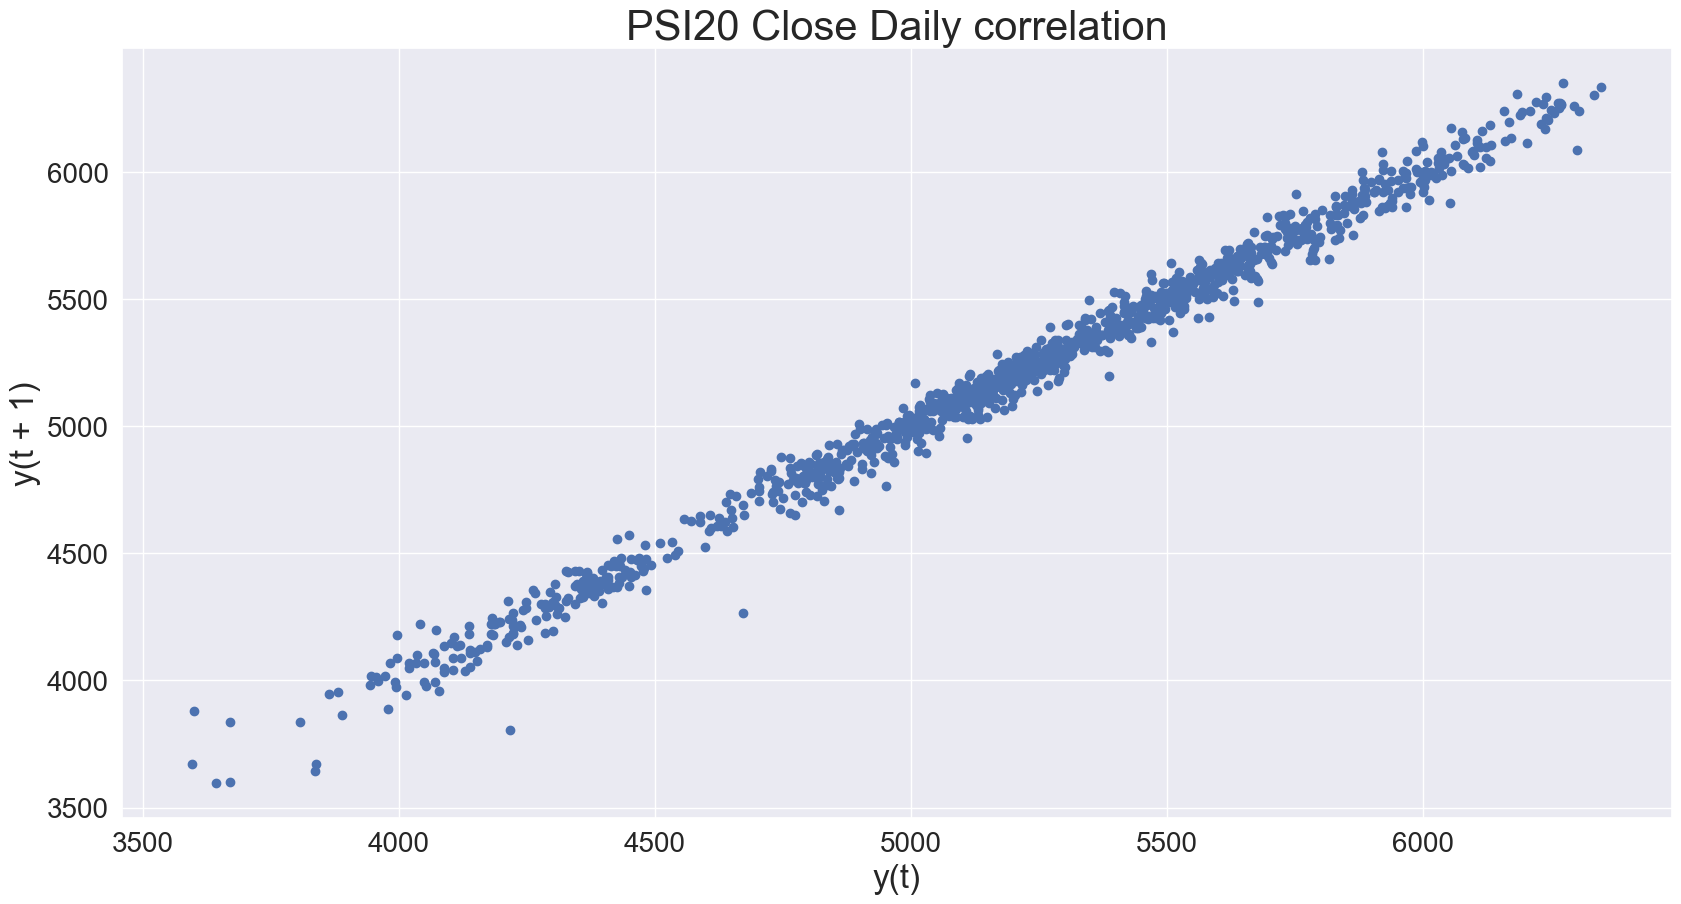

In [150]:
from pandas.plotting import lag_plot
plt.title("PSI20 Close Daily correlation", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#lag_plot(df['Close'], lag=1)
lag_plot(df['Close'], lag=1)







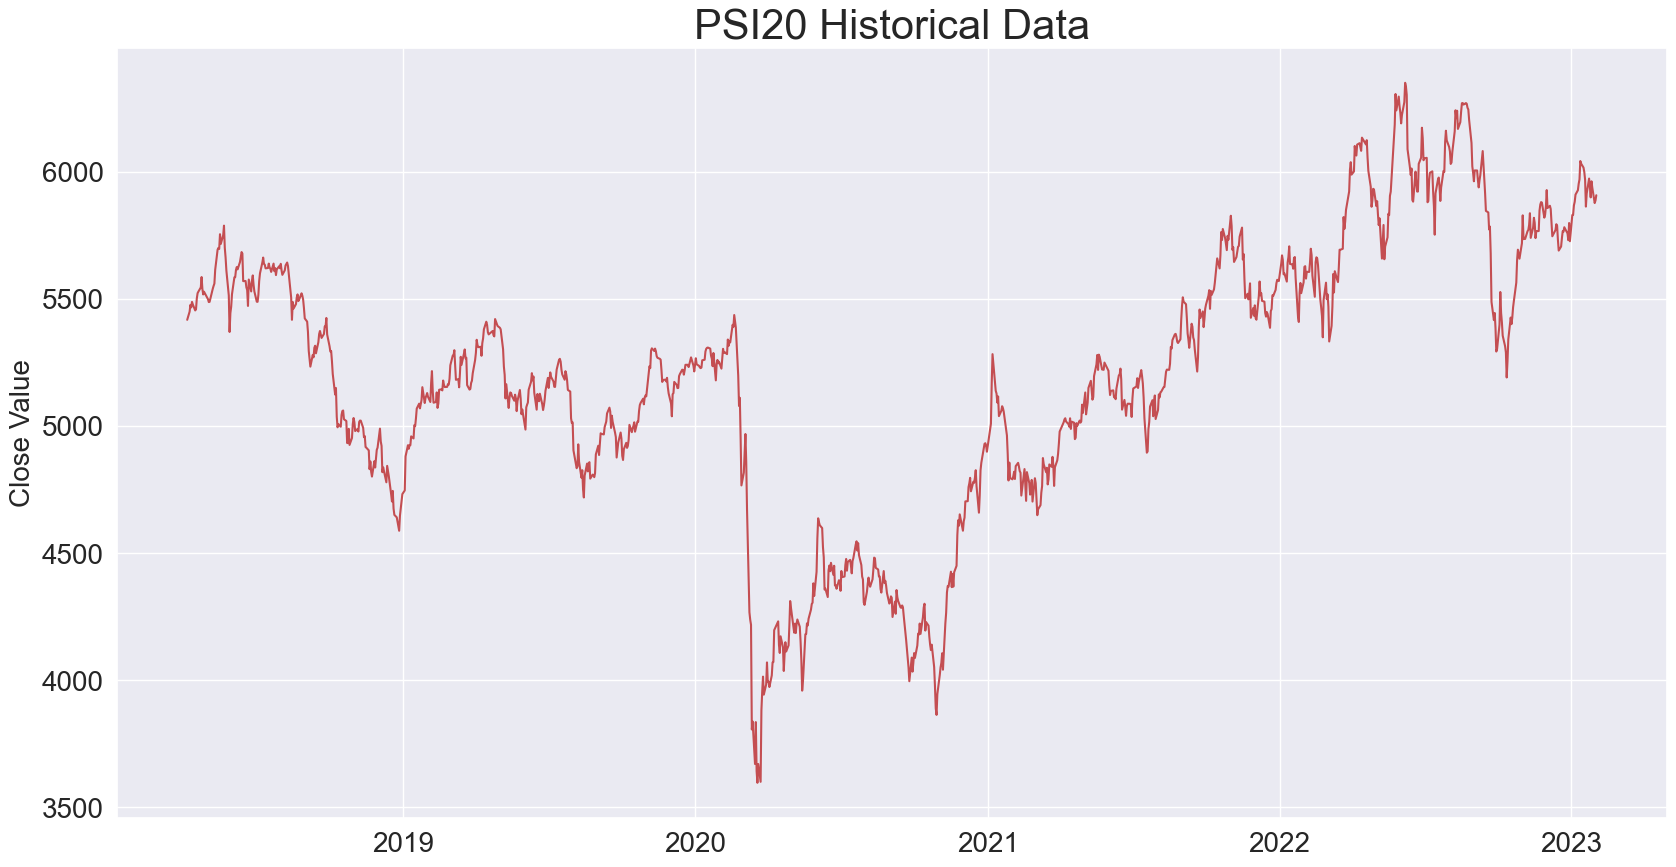

In [151]:
import seaborn as sns
plt.plot(df["Close"], 'r', label='PSI20 Daily Closing Values')
plt.title("PSI20 Historical Data", fontsize=30)
plt.ylabel('Close Value', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
import seaborn as sns
sns.set(font_scale=2)
#sns.set(rc={'figure.figsize':(15.27,15.27)})
#plt.hist(accuracies3)
#plt.show()
plt.show()  




In [152]:
df.Close

Date
2018-04-06 00:00:00+01:00   5417.06
2018-04-09 00:00:00+01:00   5448.99
2018-04-10 00:00:00+01:00   5475.84
2018-04-11 00:00:00+01:00   5465.71
2018-04-12 00:00:00+01:00   5487.54
                              ...  
2023-01-26 00:00:00+00:00   5961.77
2023-01-27 00:00:00+00:00   5936.73
2023-01-30 00:00:00+00:00   5876.20
2023-01-31 00:00:00+00:00   5886.34
2023-02-01 00:00:00+00:00   5907.01
Name: Close, Length: 1228, dtype: float64

In [153]:
df.describe()


Open    High     Low   Close       Volume  Dividends  Stock Splits
count 1228.00 1228.00 1228.00 1228.00      1228.00    1228.00       1228.00
mean  5197.10 5227.98 5164.30 5195.97  80119480.21       0.00          0.00
std    540.08  539.46  541.18  541.03  42451787.18       0.00          0.00
min   3554.70 3613.67 3500.02 3596.08    628400.00       0.00          0.00
25%   4902.50 4933.77 4877.55 4903.75  51431350.00       0.00          0.00
50%   5218.57 5240.35 5191.09 5219.03  68041800.00       0.00          0.00
75%   5586.11 5614.23 5553.40 5583.12  96078125.00       0.00          0.00
max   6362.88 6370.78 6314.64 6349.21 325218900.00       0.00          0.00

In [154]:
df.Close.describe()

count   1228.00
mean    5195.97
std      541.03
min     3596.08
25%     4903.75
50%     5219.03
75%     5583.12
max     6349.21
Name: Close, dtype: float64

#### Intraday Data

In [155]:
dfs = []
for i in range(0, len(dates)) :
    dfs.append(load_df_intraday(names[0],dates[i]))

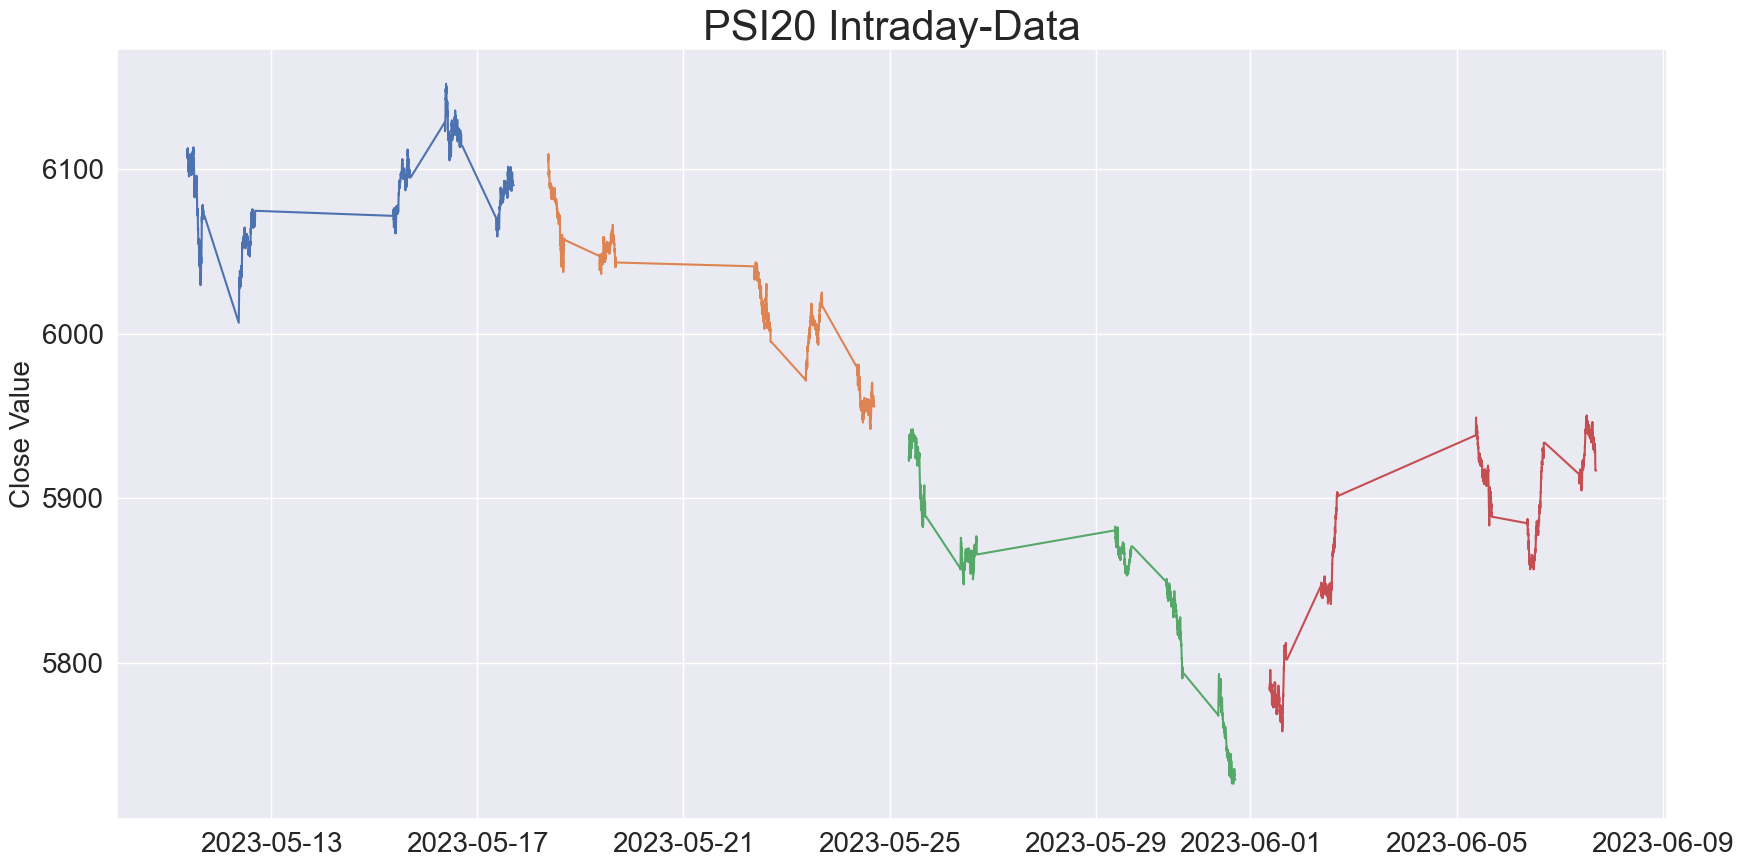

In [156]:
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("PSI20 Intraday-Data", fontsize=30)
plt.ylabel('Close Value', fontsize=20)
for i in range (len(dfs)):
    plt.plot(dfs[i]['Close'])
    #plt.plot(dfs[i]['Open'])

In [157]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
for i in range (len(dfs)):
    print("************ || Period ending in: || "+ dates[i] +" || ***************")
    print(dfs[i].Close.describe())
    
    

************ || Period ending in: || 18-05-2023 || ***************
count   2408.00
mean    6087.01
std       26.20
min     6006.54
25%     6068.38
50%     6089.78
75%     6105.06
max     6151.50
Name: Close, dtype: float64
************ || Period ending in: || 25-05-2023 || ***************
count   2405.00
mean    6021.19
std       41.40
min     5942.35
25%     5995.73
50%     6021.46
75%     6052.54
max     6108.92
Name: Close, dtype: float64
************ || Period ending in: || 01-06-2023 || ***************
count   2395.00
mean    5845.95
std       56.45
min     5726.81
25%     5819.23
50%     5860.12
75%     5872.14
max     5941.95
Name: Close, dtype: float64
************ || Period ending in: || 08-06-2023 || ***************
count   2402.00
mean    5874.07
std       54.81
min     5758.63
25%     5843.07
50%     5886.68
75%     5919.16
max     5950.34
Name: Close, dtype: float64


## Setting the Model

##### Data Preparation

In [158]:
#Dropping unwanted columns
def selectData(type='univariate', datframe=df) :
    if type=='univariate' :
        #data = datframe.drop(columns=['Open', 'High', 'Low','Volume','Dividends','Stock Splits'])
        data = datframe[["Close"]]
    else :
        data = datframe.drop(columns=['Open', 'High', 'Low','Dividends','Stock Splits'])
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [159]:
# Divides Data into Train Data and Test Data
def divideData(data, size) : 
    train_data=data.values[0:size,:]
    test_data=data[-(LOOK_BACK+PERIODS_TO_PREDICT):].values
    return train_data,test_data

#### Scalers

In [160]:
# Scale Data between 0 and 1 
def scaleData(data,*scaler) :
    if len(scaler) == 1 :
        d1=data.copy()
        temp = scaler[0].fit_transform(d1[:, 0].reshape(-1,1))
        d1[:,0] = temp.squeeze()
        return d1
    else: 
        a1=scaler[0].fit_transform(data[:,0].reshape(-1,1))
        a2=scaler[1].fit_transform(data[:,1].reshape(-1,1))    
        scaled_data = np.array([a1,a2]).squeeze()
    return np.transpose(scaled_data)

In [161]:
def scaleDataMulti(data) : 
    scalers, sc_data = [], []
    
    for i in range (data.shape[1]) :
        scaler=MinMaxScaler(feature_range=(0,1))
        scalers.append(scaler)
        sc_data.append(scaler.fit_transform(data[:,i].reshape(-1,1)))
    
    sc_data = np.array(sc_data).squeeze().T

    return sc_data, scalers


In [162]:
def diffLogData (data, numVariables=1) : 
    if numVariables==1 :
        data = np.reshape(data,(data.shape[1], data.size))
        return np.diff(np.log(data)).T
    elif numVariables==2: 
        data=data.T
        return np.c_[np.diff(np.log(data[0])) , np.diff(np.log(data[1]))]

    #return np.transpose(np.diff(np.log(data)))

In [163]:
def diffLogData_new (data) : 
    numFeatures = data.shape[1]
    data=data.T
    result = np.diff(np.log(data[0]))
    
    for i in range (1, numFeatures) :
        result = np.c_[result , np.diff(np.log(data[i]))]

    return result









In [164]:
def undiffLogData (data, v0) :
    "Data is the array of logarithmic Differences and v0 is the initial absolute (price) of the test dataset"
    return v0 * np.concatenate(([1], np.exp(np.cumsum(data))))
    


In [165]:
def undiffLogData2 (actualData, diffLoggedData) :
    "Data is the array of logarithmic Differences and v0 is the actual prices on the period"
    #TODO in the data array add a "1" on position 0. - Concatenate.
    
    temp = np.exp(np.log(actualData[:-1]) - diffLoggedData)

    return np.concatenate((actualData[0:1], temp))

#### Train/Test Vector Creators

In [166]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"
    
    x_train=[]

    for i in range(LOOK_BACK,len(data)):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [167]:
def createBivTrainVector(data, size) :
    x0, x1 = [],[]
    for i in range(LOOK_BACK,size):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    
    return np.transpose(x_data, (1, 2, 0))

    #x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    #return  np.reshape(x_data,(x_data.shape[1],x_data.shape[2],x_data.shape[0]))
   

In [168]:
def createMultiTrainVector(data):
    x_data = []
    #features = data.shape[1]
    
    for i in range(LOOK_BACK, len(data)):
        x_data.append(data[i-LOOK_BACK:i, :])
    
    return np.array(x_data)
    

In [169]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [170]:
#%% Creates a vectors with target data for multiple horizon models (more than one day prediction)
def createTargetVectorHorizon(data,horizon) :
    "Horizon is the numbe of days predicted by the model"
    y_train=[]

    for i in range (LOOK_BACK,(len(data)-horizon)):
        y_train.append(data[i:i+horizon,0])
    
    return np.asarray(y_train)

In [171]:
#%% Creates a vectors with target data
from keras.utils import to_categorical
def createTargetClassVector(data, numCat=5) :
    data = data[LOOK_BACK:]
    percentiles = []
    y_data = []

    # Calculate Percentiles
    for i in range(0,numCat) :
            percentiles.append(np.percentile(data, (100/numCat)*i))
            
            
    # fill the vector with a classification number from 0 to [numCat]
    for i in range(0,len(data)):
        for j in reversed(range(0,numCat)) :
            if(data[i]>=percentiles[j]):
                y_data.append(j)
                break
                

    from keras.utils import to_categorical       
    #one hot encode the vector 
    return np.asarray(to_categorical(y_data, num_classes=len(np.unique(y_data))))
    


In [172]:
# CREATES a VECTOR FOR TEST WITH LENGTH = PERIODS_TO_PREDICT + LOOK_BACK
def selectTestData (data, size):
    test_data=data[size-LOOK_BACK:].values
    return test_data.reshape(-1,1)
    

In [173]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)

    #Reshaopes the vector for the predict function
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [174]:
def createBivTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x0,x1=[],[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    X_test = np.array([np.array(x0),np.array(x1)])
        
    return np.transpose(X_test, (1, 2, 0))

    #X_test = np.array([np.array(x0),np.array(x1)])
    #return np.reshape(X_test, (X_test.shape[1],X_test.shape[2],X_test.shape[0]))

#### LSTM Model

In [175]:
#%% Creates a LSTM Sequential model
def createLstmModel (data,outputs=1,type="regression") : 

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
    try:
        numSources = data.shape[2]
    except:
        numSources = 1
    

    input_shape=(np.shape(data)[1],numSources)
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            #lstm_model.add(Dropout(0.01))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    
    # For single or multiple output (regression)
    if (type=="regression") : 
        lstm_model.add(Dense(units=outputs))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
    #For Multiple outputs ( #(Category/Calssification))
    else : 
        lstm_model.add(Dense(units=outputs, activation = 'softmax'))
        lstm_model.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=Adam(learning_rate=LEARN_RATE)
                )
    return lstm_model

In [176]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train,epoch=EPOCHS) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=epoch,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

In [177]:
def plotHistory(history, yaxis="MAE", title="") :
    plt.plot(history.history['loss'], label='Train Data')
    plt.plot(history.history['val_loss'], label='Validation Data')
    plt.xlabel("EPOCHS", fontsize=20)
    plt.ylabel(yaxis, fontsize=20)
    plt.title(title, fontsize=30, loc="center")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()




# == RUNNING THE MODEL ==

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [195]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)

test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler)
X_test = createTestVector(scaled_test_data)

In [196]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.64086088 0.63761599 0.64207378 ... 0.44836868 0.40947402 0.44309192]
 [0.63761599 0.64207378 0.65322897 ... 0.40947402 0.44309192 0.46610545]
 [0.64207378 0.65322897 0.66696463 ... 0.44309192 0.46610545 0.46785713]
 ...
 [0.45697493 0.43969732 0.44647696 ... 0.53690975 0.53195187 0.51762197]
 [0.43969732 0.44647696 0.43225808 ... 0.53195187 0.51762197 0.52428317]
 [0.44647696 0.43225808 0.40984611 ... 0.51762197 0.52428317 0.52431219]]

y data - target

[[0.46610545]
 [0.46785713]
 [0.47375244]
 ...
 [0.52428317]
 [0.52431219]
 [0.54375463]]


In [197]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200


44/44 [==============================] - 4s 40ms/step - loss: 0.0308 - val_loss: 0.0024
Epoch 2/200
44/44 [==============================] - 1s 25ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/200
44/44 [==============================] - 1s 25ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/200
44/44 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/200
44/44 [==============================] - 1s 25ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/200
44/44 [==============================] - 1s 25ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 7/200
44/44 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/200
44/44 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/200
44/44 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/200
44/44 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 11/20

KeyboardInterrupt: 

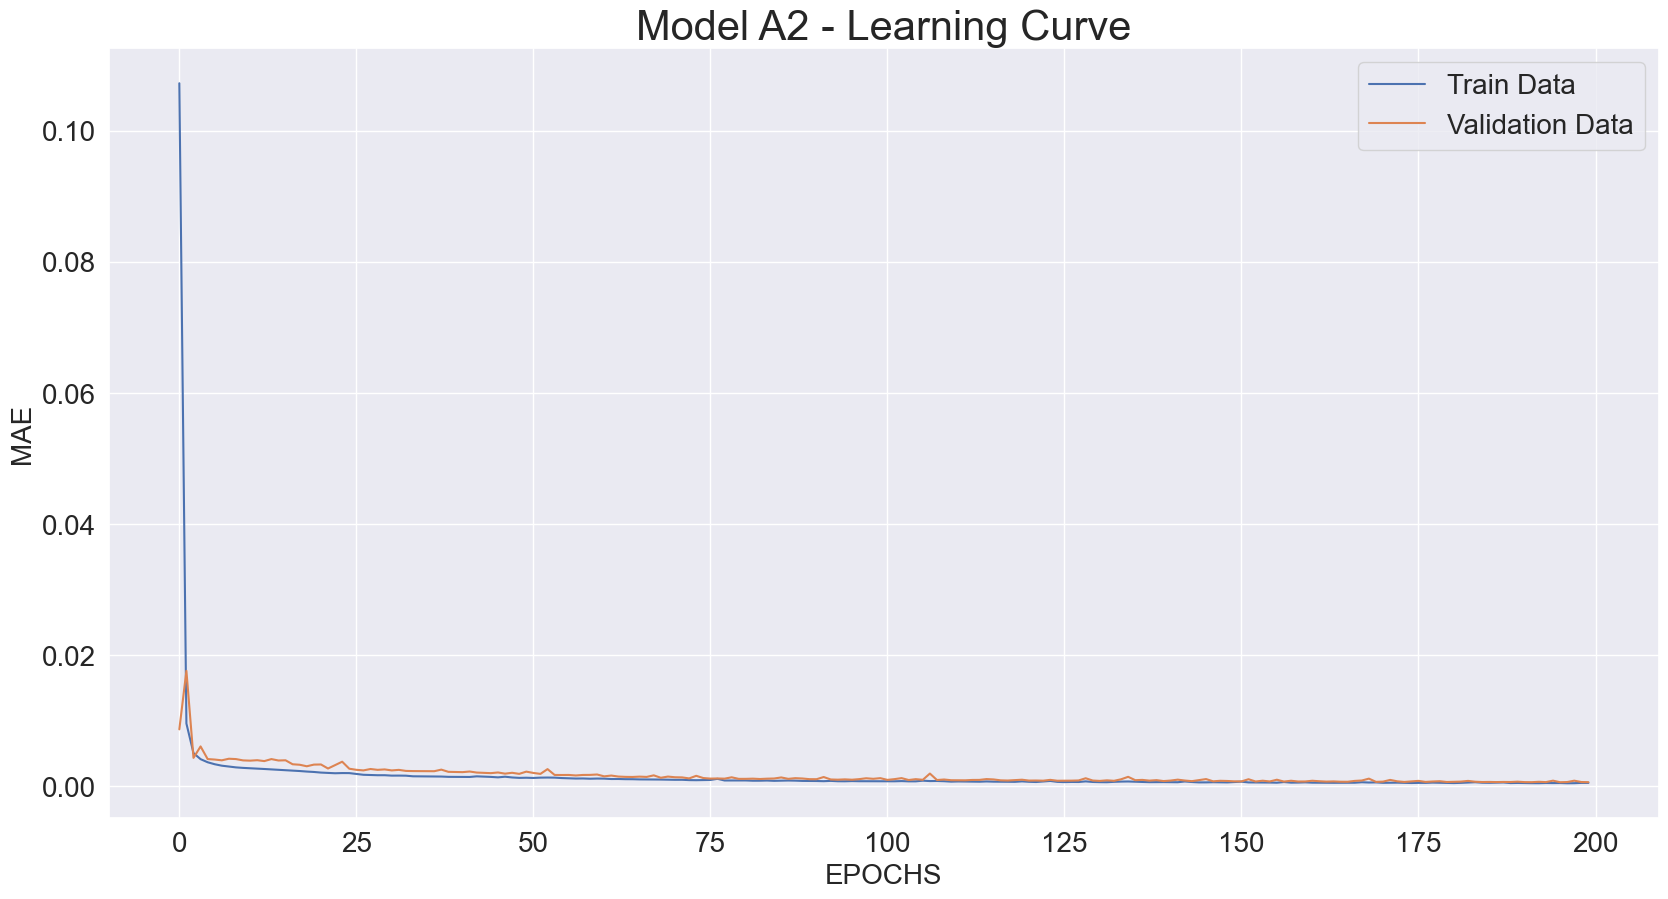

In [ ]:

plotHistory(history, title="Model A2 - Learning Curve")

#### Bivariate Model

In addition to the univariate method (above) This model also considers the volume of trading during the [LOOK_BACK] days before, to estimate the value of the index. 

In [248]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='bivariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


In [249]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[[0.64086088 0.        ]
  [0.63761599 0.        ]
  [0.64207378 0.        ]
  ...
  [0.44836868 0.        ]
  [0.40947402 0.        ]
  [0.44309192 0.        ]]

 [[0.63761599 0.        ]
  [0.64207378 0.        ]
  [0.65322897 0.        ]
  ...
  [0.40947402 0.        ]
  [0.44309192 0.        ]
  [0.46610545 0.        ]]

 [[0.64207378 0.        ]
  [0.65322897 0.        ]
  [0.66696463 0.        ]
  ...
  [0.44309192 0.        ]
  [0.46610545 0.        ]
  [0.46785713 0.        ]]

 ...

 [[0.45697493 0.03217627]
  [0.43969732 0.02817576]
  [0.44647696 0.02382066]
  ...
  [0.53690975 0.03932611]
  [0.53195187 0.04236443]
  [0.51762197 0.03177746]]

 [[0.43969732 0.02817576]
  [0.44647696 0.02382066]
  [0.43225808 0.04532881]
  ...
  [0.53195187 0.04236443]
  [0.51762197 0.03177746]
  [0.52428317 0.01904675]]

 [[0.44647696 0.02382066]
  [0.43225808 0.04532881]
  [0.40984611 0.03037804]
  ...
  [0.51762197 0.03177746]
  [0.52428317 0.01904675]
  [0.52431219 0.01380682]]]

y

In [250]:
np.shape(x_train_data)[1],x_train_data.shape[2]

(40, 2)

In [251]:

lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 50)            10600     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
44/44 [==============================] - 4s 40ms/step - loss: 0.0384 - val_loss: 0.0047
Epoch 2/200
44/44 [==============================] - 1s 25ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 3/200
44/44 [==============================] - 1s 26ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/2

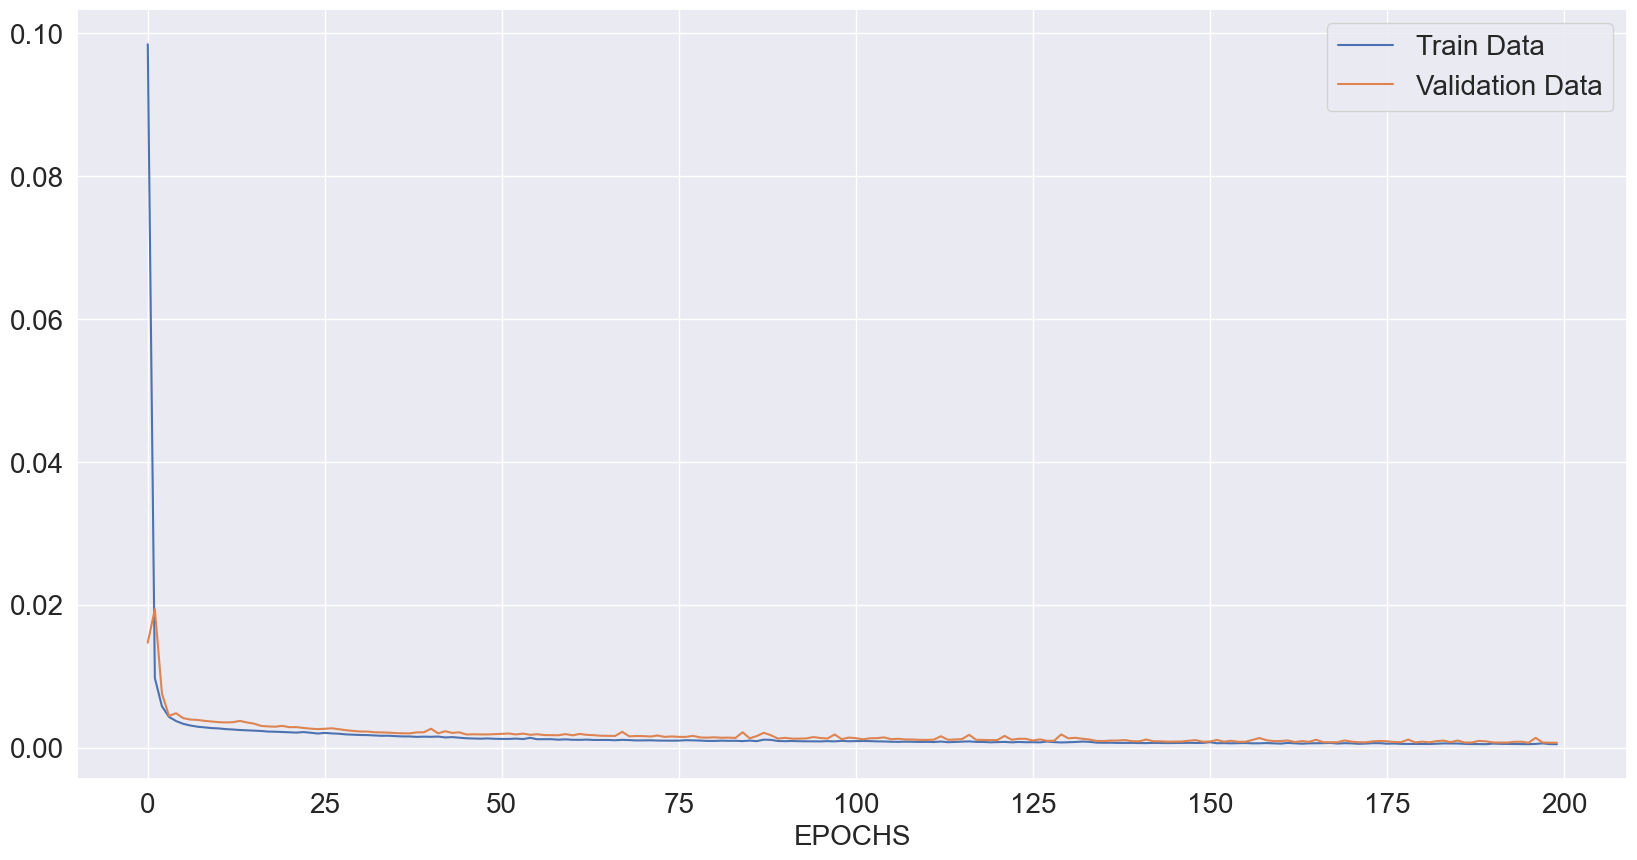

In [121]:

plotHistory(history, "")

In [122]:

lstm_biv_model.save('.\models\model_B1.h5')  # creates a HDF5 file 'my_model.h5'

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [ ]:
df = load_df_other()
df = df.truncate(after=pd.Timestamp('2021-05-05 00:00:00+00:00'))
df


In [127]:

global_data, size_train_data = selectData(type='univariate',datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)


In [ ]:

#EPOCHS=5
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 20, 25)            7600      
                                                                 
 lstm_4 (LSTM)               (None, 12)                1824      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 19,837
Trainable params: 19,837
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
18/18 [==============================] - 9s 186ms/step - loss: 1.4660e-04 - val_loss: 1.5411e-04
Epoch 2/150
18/18 [==============================] - 1s 53ms/step - 

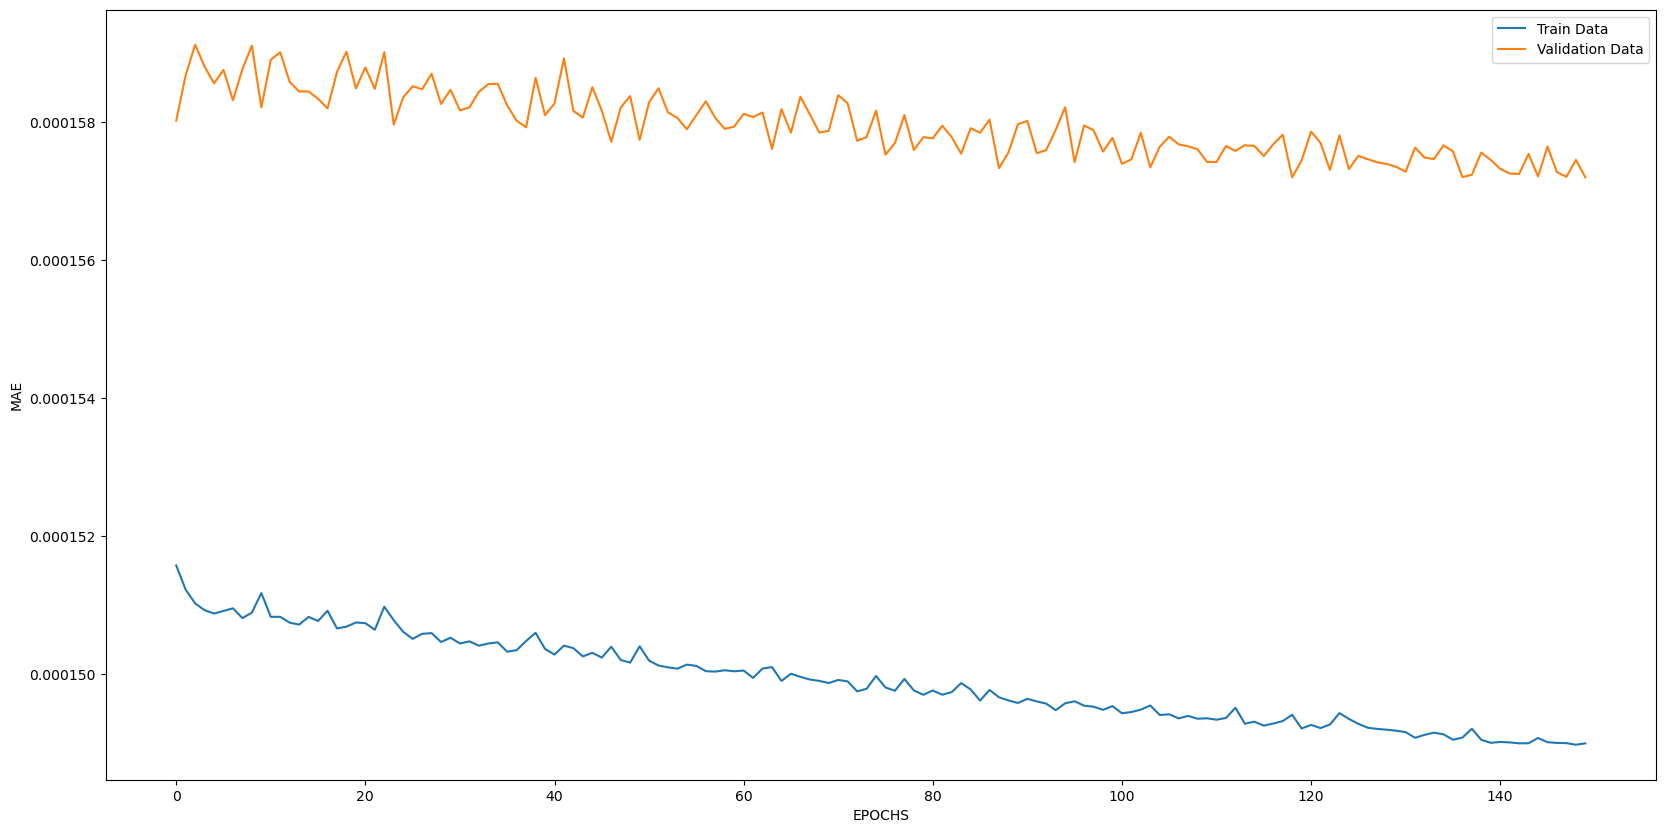

In [ ]:
                        
plotHistory(history)


#### Classification Model (based on Diff(log) model)

##### This model classifies the forecast into n different categories

In [50]:
#df=df.truncate(after=pd.Timestamp('2022-02-01 00:00:00+00:00'))
df = load_df_portugal();
global_data, size_train_data = selectData(type='univariate', datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
difflogged_train_data=diffLogData(train_data)


In [51]:

#Number of CAtegories to classify the data
numCat=3

# Preparing the arrays for the model
x_train_data = createTrainVector(difflogged_train_data)


In [52]:

x_train_data = x_train_data[:-1]
y_train_data = createTargetClassVector(difflogged_train_data, numCat)


# Preparing Test Data
test_data=selectTestData(global_data,size_train_data)
difflogged_test_data=diffLogData(test_data)
X_test = createTestVector(difflogged_test_data)
Y_test = createTargetClassVector(difflogged_test_data, numCat)




In [53]:
#Show how many observations are in each percentile

numCat=y_train_data.shape[1]
for i in range(0, numCat):
    print('percentile ' + str(i*int(100/numCat)) + ' = ' + str(np.count_nonzero(y_train_data[:,i] == 1)))


percentile 0 = 379
percentile 33 = 379
percentile 66 = 379


In [54]:
lstm_class_model = createLstmModel(x_train_data, y_train_data.shape[1], type="classification")
print(lstm_class_model.summary())
print(len(x_train_data))
print("number of Epochs " + str(EPOCHS))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 3)                 78        
                                                                 
Total params: 18,078
Trainable params: 18,078
Non-trainable params: 0
_________________________________________________________________
None
1136
number of Epochs 150


In [55]:

history = trainLstmModel(lstm_class_model, x_train_data, y_train_data)


Epoch 1/150


37/37 [==============================] - 4s 40ms/step - loss: 1.0995 - accuracy: 0.3392 - val_loss: 1.1026 - val_accuracy: 0.2544
Epoch 2/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0983 - accuracy: 0.3535 - val_loss: 1.1033 - val_accuracy: 0.2544
Epoch 3/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0984 - accuracy: 0.3535 - val_loss: 1.1086 - val_accuracy: 0.2544
Epoch 4/150
37/37 [==============================] - 1s 22ms/step - loss: 1.0987 - accuracy: 0.3535 - val_loss: 1.1058 - val_accuracy: 0.2544
Epoch 5/150
37/37 [==============================] - 1s 22ms/step - loss: 1.0981 - accuracy: 0.3535 - val_loss: 1.1066 - val_accuracy: 0.2544
Epoch 6/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0981 - accuracy: 0.3535 - val_loss: 1.1067 - val_accuracy: 0.2544
Epoch 7/150
37/37 [==============================] - 1s 21ms/step - loss: 1.0993 - accuracy: 0.3535 - val_loss: 1.1063 - val_accuracy: 0.2544
Epoch 8/150
37/37 

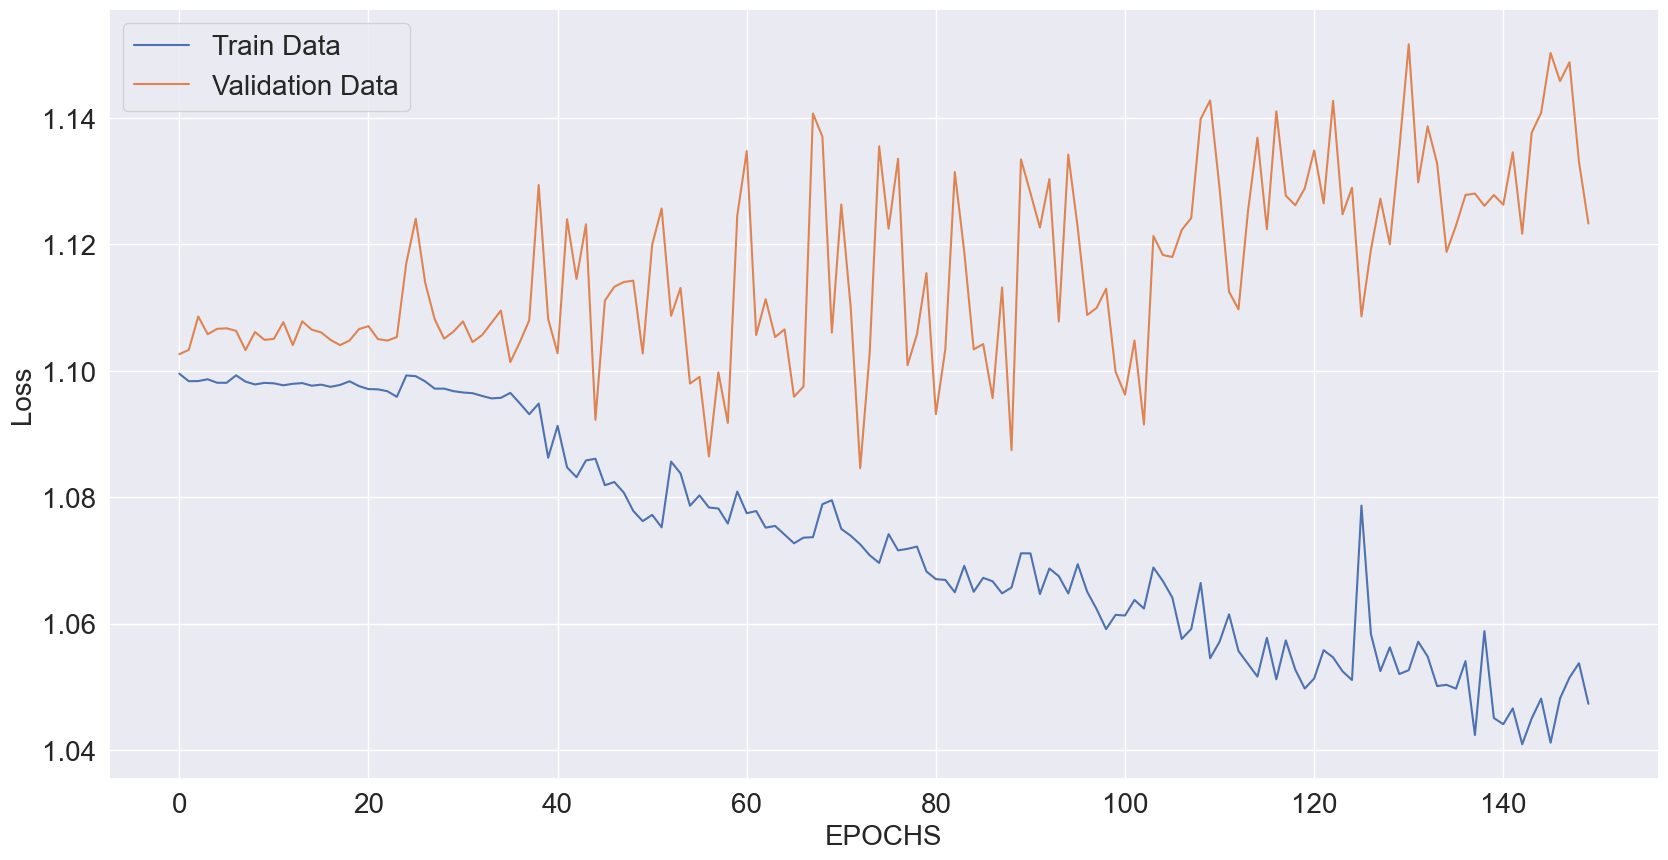

In [56]:
plotHistory(history, yaxis="Loss")

In [57]:
from keras.models import load_model

lstm_model.save('.\models\model_c1.h5')  # creates a HDF5 file 'my_model.h5'

NameError: name 'lstm_model' is not defined

## Linear Model with foreign X_Data

#### This model predicts the PSI-20 index based on the information from the last 90 days of another stock exchange

In [396]:
df, df_other = load_multiple_index(end_date="2023-01-01")
df


Open         High          Low        Close     Volume  \
2018-05-04  5493.379883  5511.290039  5485.919922  5487.790039   57870500   
2018-05-07  5513.689941  5531.500000  5506.319824  5527.759766   59076900   
2018-05-08  5510.660156  5539.560059  5480.609863  5539.560059  116329700   
2018-05-09  5557.060059  5568.930176  5542.729980  5550.390137   89739500   
2018-05-10  5569.100098  5576.879883  5533.459961  5559.620117   62554800   
...                 ...          ...          ...          ...        ...   
2022-12-23  5767.140137  5789.259766  5745.490234  5781.180176   38794100   
2022-12-27  5800.410156  5821.209961  5749.109863  5756.979980   45676700   
2022-12-28  5751.479980  5770.799805  5718.850098  5730.279785   62113100   
2022-12-29  5718.930176  5797.759766  5704.350098  5797.759766   99755800   
2022-12-30  5762.069824  5771.729980  5726.109863  5726.109863   71268600   

            Dividends  Stock Splits  
2018-05-04          0             0  
2018-05-07          0             0  
2018-05-08          0             0  
2018-05-09          0             0  
2018-05-10          0             0  
...               ...           ...  
2022-12-23          0             0  
2022-12-27          0             0  
2022-12-28          0             0  
2022-12-29          0             0  
2022-12-30          0             0  

[1187 rows x 7 columns]

In [397]:
df_other

Open         High          Low        Close    Volume  \
2018-05-04  5495.709961  5516.049805  5485.990234  5516.049805  85333000   
2018-05-07  5511.939941  5532.120117  5503.700195  5531.419922  45591900   
2018-05-08  5523.910156  5529.149902  5496.390137  5521.930176  70214400   
2018-05-09  5520.649902  5535.240234  5511.580078  5534.629883  72894200   
2018-05-10  5532.370117  5547.200195  5522.910156  5545.950195  48972800   
...                 ...          ...          ...          ...       ...   
2022-12-23  6513.200195  6533.580078  6476.049805  6504.899902  42984900   
2022-12-27  6559.629883  6579.330078  6543.259766  6550.660156  33013100   
2022-12-28  6561.500000  6572.120117  6505.669922  6510.490234  40109400   
2022-12-29  6486.649902  6577.080078  6474.729980  6573.470215  41261600   
2022-12-30  6533.120117  6540.509766  6470.640137  6473.759766  42838300   

            Dividends  Stock Splits  
2018-05-04          0             0  
2018-05-07          0             0  
2018-05-08          0             0  
2018-05-09          0             0  
2018-05-10          0             0  
...               ...           ...  
2022-12-23          0             0  
2022-12-27          0             0  
2022-12-28          0             0  
2022-12-29          0             0  
2022-12-30          0             0  

[1187 rows x 7 columns]

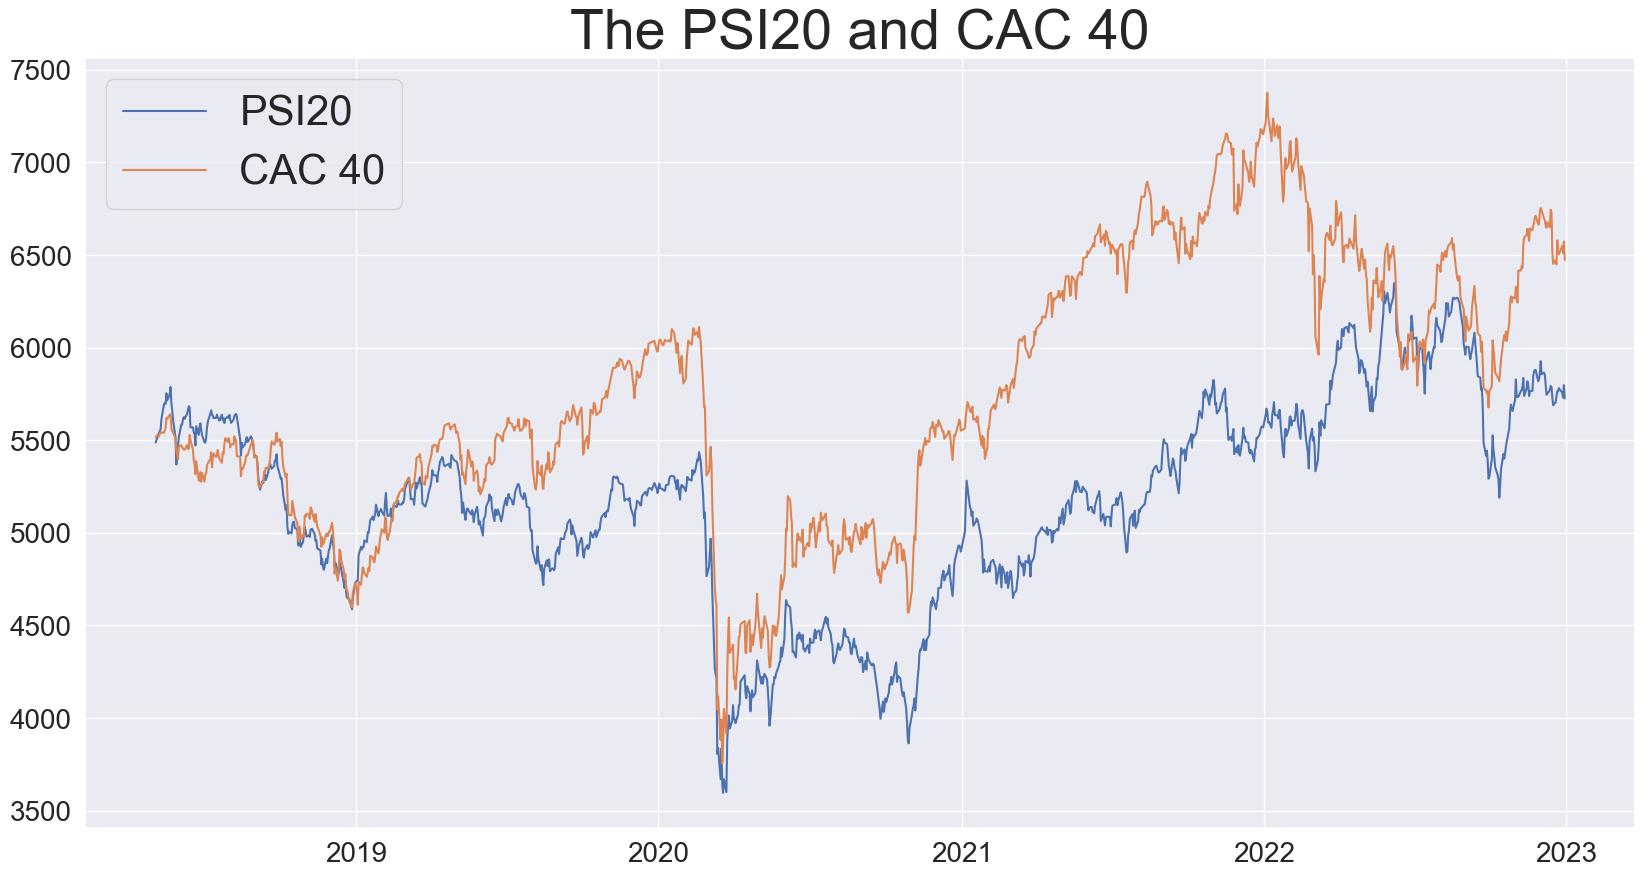

In [398]:
plt.plot(df['Close'], label='PSI20')
plt.plot(df_other['Close'], label=NAME_FOREIGN)
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("The PSI20 and "+NAME_FOREIGN, fontsize=40)
plt.legend(fontsize=30)
plt.show()

In [399]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)

#Scales the data
scaler_f=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler_f)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data)

In [400]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaler_p=MinMaxScaler(feature_range=(0,1))
scaled_train_data_p=scaleData(train_data_p,scaler_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

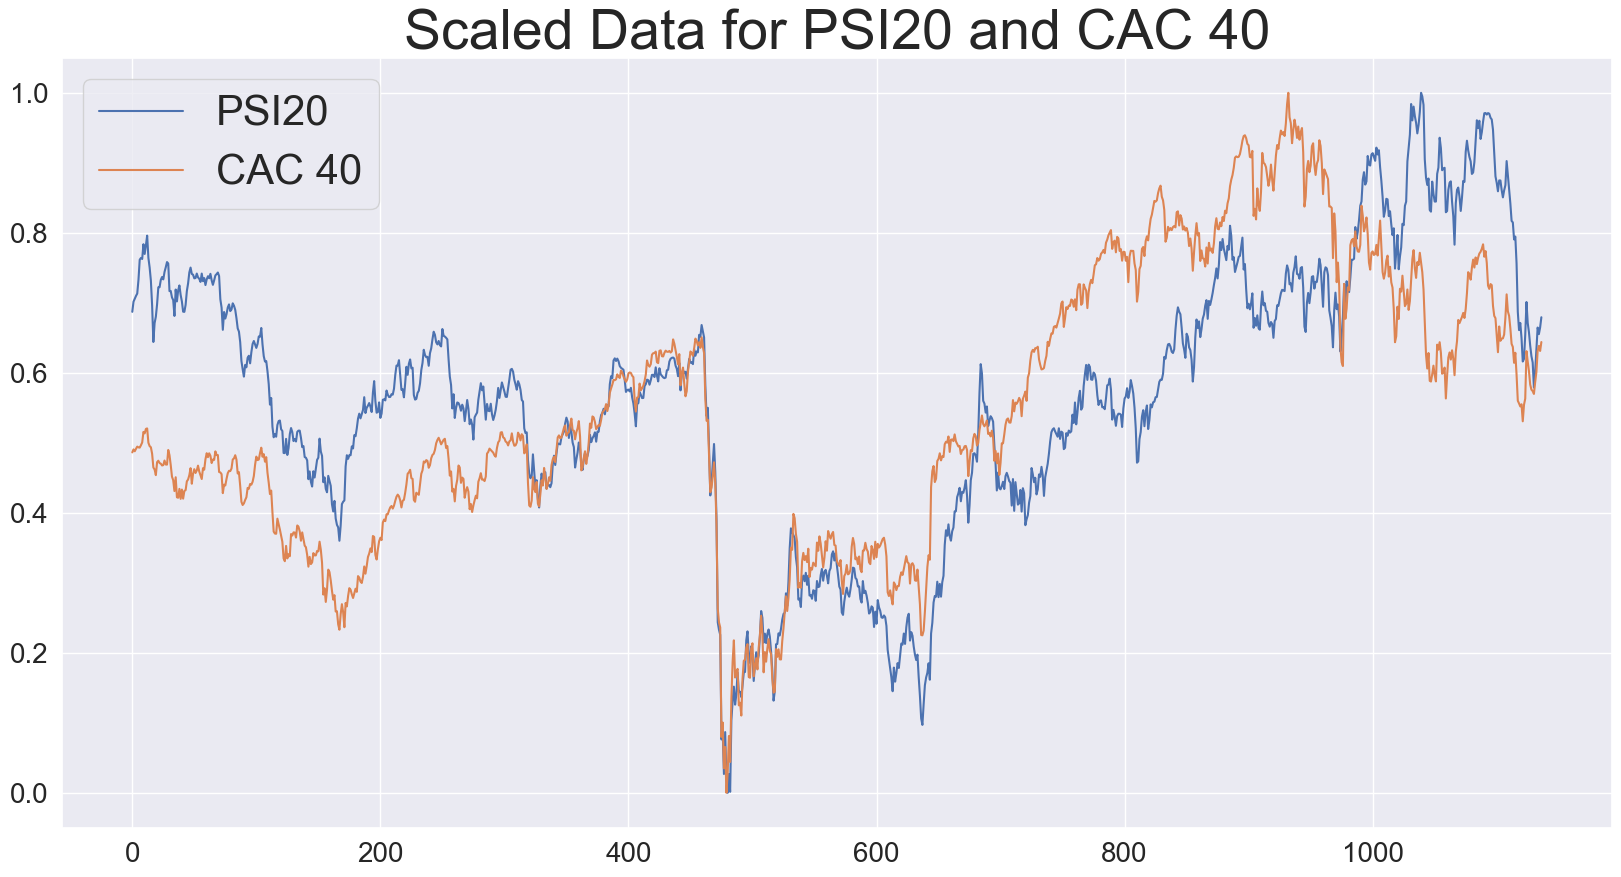

In [401]:
plt.plot(scaled_train_data_p, label='PSI20')
plt.plot(scaled_train_data, label=NAME_FOREIGN)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Scaled Data for PSI20 and "+ NAME_FOREIGN, fontsize=40)
plt.legend(fontsize=30)
plt.show()

In [402]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler_f)
X_test = createTestVector(scaled_test_data)

print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)


x data

[[0.48631647 0.49056057 0.4879402  ... 0.42149311 0.43417011 0.41993302]
 [0.49056057 0.4879402  0.49144692 ... 0.43417011 0.41993302 0.43315662]
 [0.4879402  0.49144692 0.49457276 ... 0.41993302 0.43315662 0.42024218]
 ...
 [0.71991117 0.72674247 0.72530669 ... 0.58658905 0.60114919 0.63117524]
 [0.72674247 0.72530669 0.69567825 ... 0.60114919 0.63117524 0.63844836]
 [0.72530669 0.69567825 0.68132521 ... 0.63117524 0.63844836 0.63119182]]

y data - target

[[0.70189929]
 [0.6873122 ]
 [0.68708714]
 ...
 [0.65521787]
 [0.66478156]
 [0.6793722 ]]


In [403]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
36/36 [==============================] - 4s 40ms/step - loss: 0.0417 - val_loss: 0.0315
Epoch 2/150
36/36 [==============================] - 1s 23ms/step - loss: 0.0145 - val_loss: 0.0508
Epoch 3/150
36/36 [==============================] - 1s 23ms/step - loss: 0.0138 - val_loss: 0.0469
Epoch 4/1

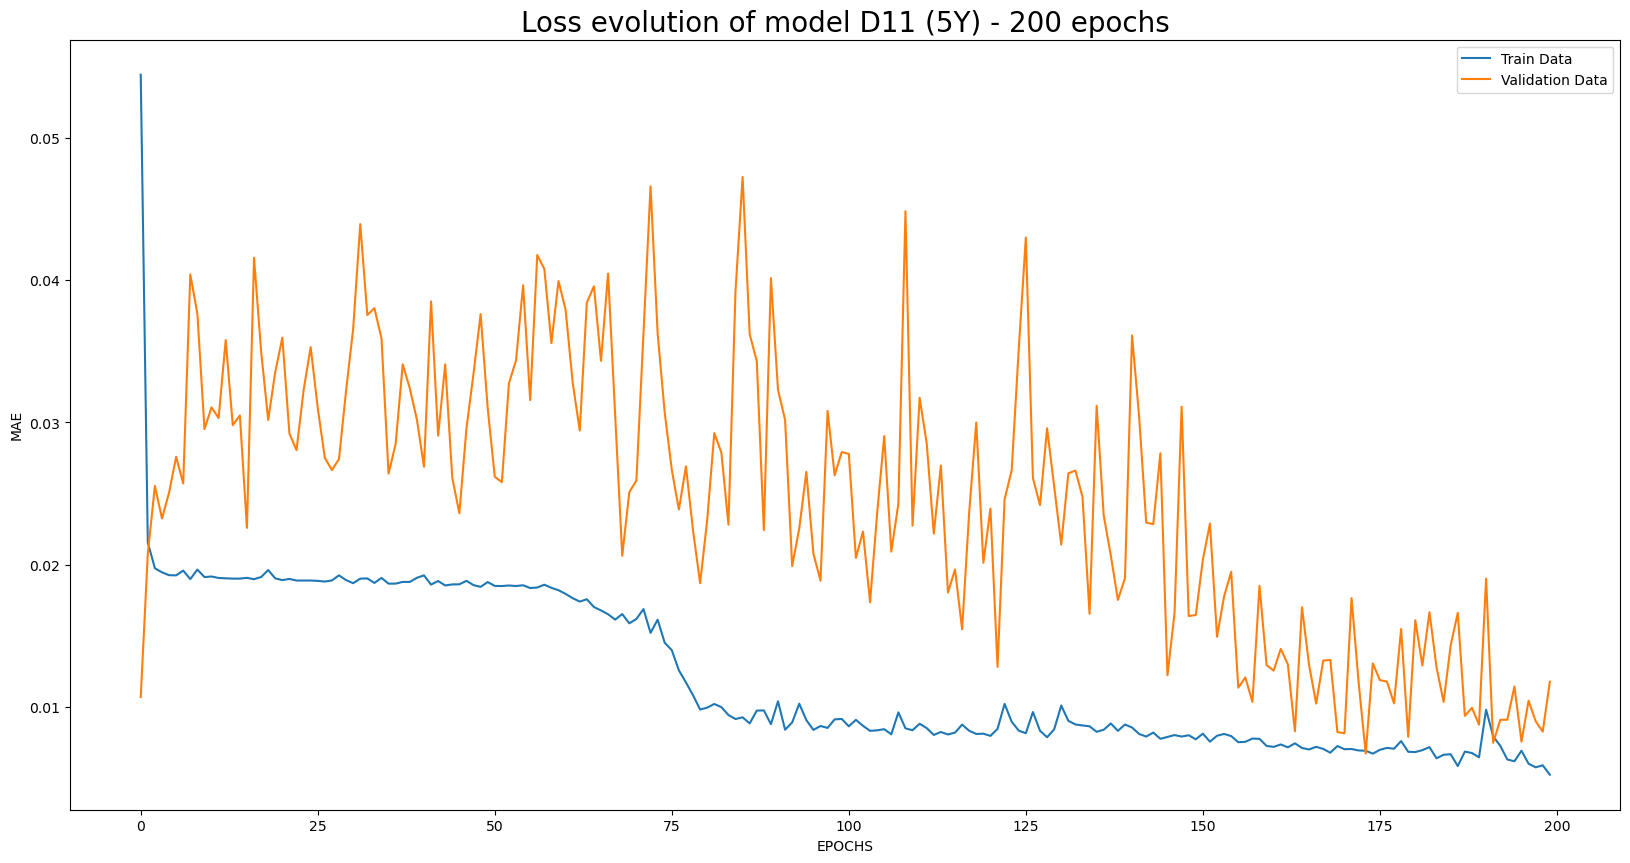

In [ ]:
plotHistory(history, title="Loss evolution of model E4 (5Y) - 150 epochs")

## Bi-Index Stocks model

#### This model predicts the PSI-20 index based on the information from the last 90 days of the PSI-20 AND another stock exchange

In [475]:
# Loads Data (includes disregarding dates only present in one dataframe)
df, df_other = load_multiple_index(end_date="2023-01-01")

# Cleans PSI-20 unwanted columns leaving only index and close value
global_data_p, size_train_data = selectData(type='univariate', datframe=df) 


# Cleans Foreign unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Renames the column of the close value of the foreign stock exchange
global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)


# Joins the thow tables in one
global_data=global_data_p.join(global_data_f["Other1"])


global_data



C:\Users\queir\AppData\Local\Temp\ipykernel_5436\648302589.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)


Close        Other1
2018-05-08  5539.560059  12519.750000
2018-05-09  5550.390137  12520.240234
2018-05-10  5559.620117  12632.490234
2018-05-11  5613.819824  12731.639648
2018-05-15  5699.720215  12772.030273
...                 ...           ...
2022-12-22  5763.540039  15219.549805
2022-12-23  5781.180176  15081.530273
2022-12-28  5730.279785  15218.259766
2022-12-29  5797.759766  15037.320312
2022-12-30  5726.109863  15241.209961

[920 rows x 2 columns]

In [476]:
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values
scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


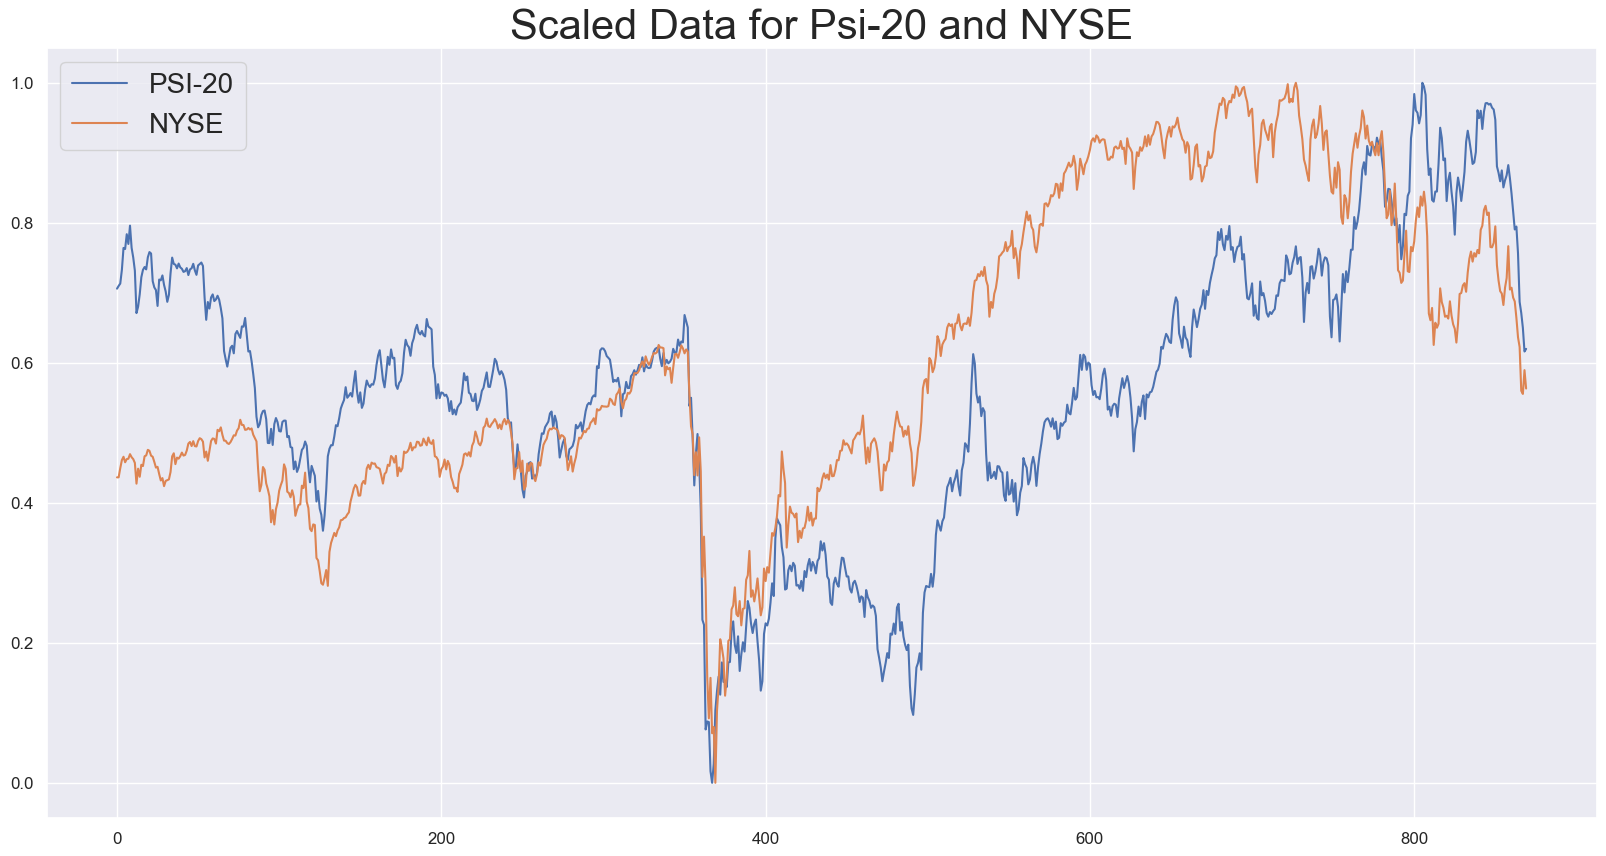

In [477]:
plt.plot(scaled_train_data[:,0], label='PSI-20')
plt.plot(scaled_train_data[:,1], label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [478]:
"""
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)
"""

'\nprint("x data\n")\nprint(x_train_data)\nprint("\ny data - target\n")\nprint(y_train_data)\n'

In [479]:
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 50)            10600     
                                                                 
 lstm_7 (LSTM)               (None, 25)                7600      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
27/27 [==============================] - 4s 48ms/step - loss: 0.0566 - val_loss: 0.0562
Epoch 2/150
27/27 [==============================] - 1s 23ms/step - loss: 0.0077 - val_loss: 0.0249
Epoch 3/150
27/27 [==============================] - 1s 23ms/step - loss: 0.0055 - val_loss: 0.0100
Epoch 4/1

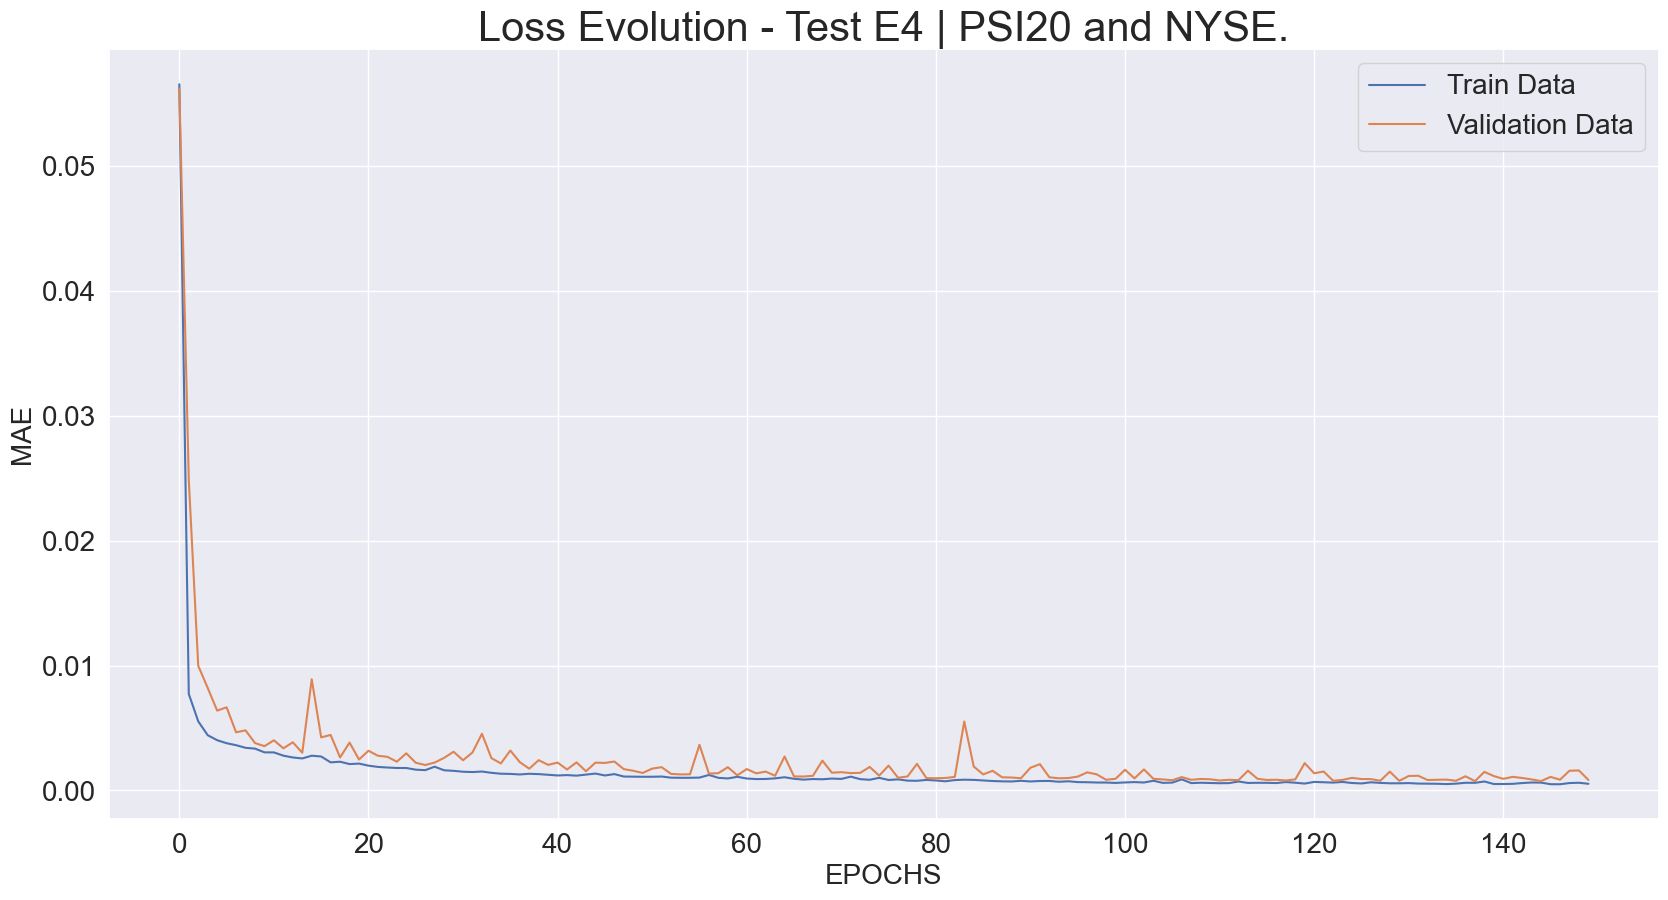

In [483]:
plotHistory(history,title="Loss Evolution - Test E4 | PSI20 and " + NAME_FOREIGN +"." )

## Multi predictor

In [101]:
HORIZON = 10
PERIODS_TO_PREDICT = HORIZON + 2

df = load_df_portugal()
df = df.truncate(after=pd.Timestamp('2022-04-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate',datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
df



Open         High          Low        Close  \
Date                                                                            
2018-04-06 00:00:00+01:00  5462.390137  5464.299805  5407.589844  5417.060059   
2018-04-09 00:00:00+01:00  5492.680176  5507.770020  5444.040039  5448.990234   
2018-04-10 00:00:00+01:00  5458.560059  5482.720215  5443.790039  5475.839844   
2018-04-11 00:00:00+01:00  5464.990234  5505.879883  5462.930176  5465.709961   
2018-04-12 00:00:00+01:00  5460.149902  5494.180176  5442.240234  5487.540039   
...                                ...          ...          ...          ...   
2022-03-28 00:00:00+01:00  5843.839844  5921.040039  5843.839844  5904.990234   
2022-03-29 00:00:00+01:00  5944.799805  5964.379883  5893.839844  5921.839844   
2022-03-30 00:00:00+01:00  5928.220215  6007.680176  5909.950195  6007.680176   
2022-03-31 00:00:00+01:00  6005.830078  6069.270020  5977.640137  6036.970215   
2022-04-01 00:00:00+01:00  6046.890137  6046.890137  5979.299805  5988.120117   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-04-06 00:00:00+01:00   58771500          0             0  
2018-04-09 00:00:00+01:00   54414200          0             0  
2018-04-10 00:00:00+01:00   47036700          0             0  
2018-04-11 00:00:00+01:00   46407600          0             0  
2018-04-12 00:00:00+01:00   73885100          0             0  
...                              ...        ...           ...  
2022-03-28 00:00:00+01:00  214343800          0             0  
2022-03-29 00:00:00+01:00  250690800          0             0  
2022-03-30 00:00:00+01:00  183456100          0             0  
2022-03-31 00:00:00+01:00  156673300          0             0  
2022-04-01 00:00:00+01:00  108895100          0             0  

[1013 rows x 7 columns]

In [102]:
#This x_train is smaller as the horizon of prediction values are removed.
x_train_data = createTrainVector(scaled_train_data[:-HORIZON])
#And Y train data is bi-dimensional
y_train_data = createTargetVectorHorizon(scaled_train_data, HORIZON)

In [103]:

#Test Data Preparation
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data[:-HORIZON])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
Total params: 18,260
Trainable params: 18,260
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
24/24 [==============================] - 4s 69ms/step - loss: 1.4612e-04 - val_loss: 9.7301e-05
Epoch 2/150
24/24 [==============================] - 1s 34ms/step - loss: 1.4606e-04 - val_loss: 9.7328e-05
Epoch 3/150
24/24 [==============================] - 1s 35ms/step - loss: 1.4604e-04 - val_lo

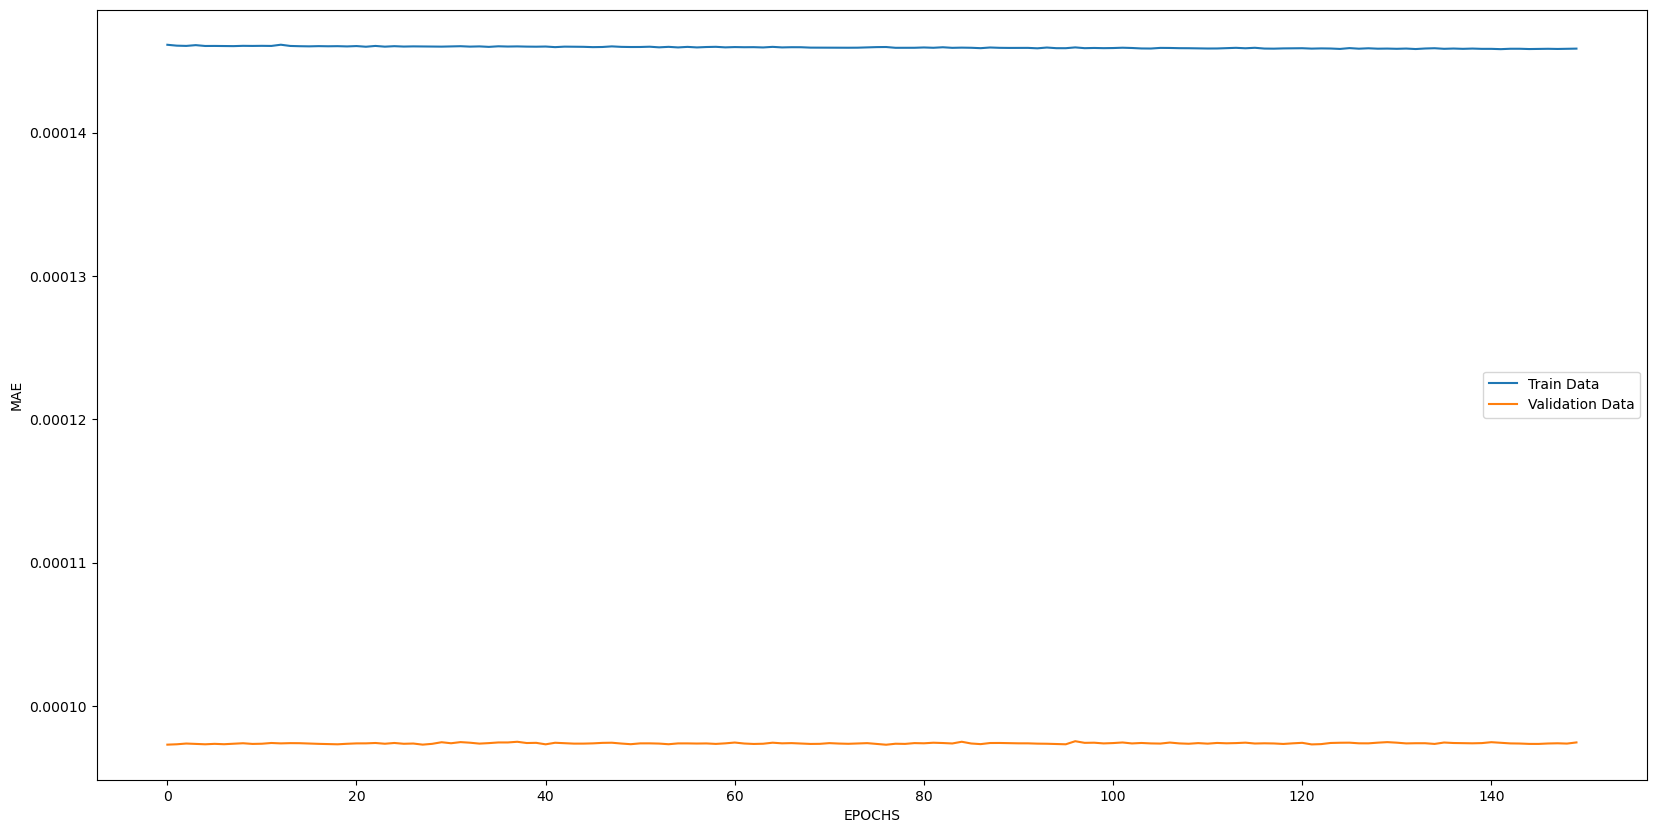

In [104]:
lstm_difflog_model = createLstmModel(x_train_data,outputs=HORIZON)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      

plotHistory(history)

## Bi-Index based on variation

In [263]:
# Loads Data (includes disregarding dates only present in one dataframe)
df, df_other = load_multiple_index(end_date="2023-01-01")

# Cleans PSI-20 unwanted columns leaving only index and close value
global_data_p, size_train_data = selectData(type='univariate', datframe=df) 

# Cleans Foreign unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Renames the column of the close value of the foreign stock exchange
global_data_f.rename(columns = {'Close':'Other1'}, inplace = True)

# Joins the thow tables in one
global_data=global_data_p.join(global_data_f["Other1"])

#NECESSARY TO RECALCULATE
#size_train_data=len(global_data)-PERIODS_TO_PREDICT
global_data

Close       Other1
2018-05-04  5487.790039  5516.049805
2018-05-07  5527.759766  5531.419922
2018-05-08  5539.560059  5521.930176
2018-05-09  5550.390137  5534.629883
2018-05-10  5559.620117  5545.950195
...                 ...          ...
2022-12-23  5781.180176  6504.899902
2022-12-27  5756.979980  6550.660156
2022-12-28  5730.279785  6510.490234
2022-12-29  5797.759766  6573.470215
2022-12-30  5726.109863  6473.759766

[1187 rows x 2 columns]

In [264]:
train_data,test_data = divideData(global_data, size_train_data)
scaled_train_data = diffLogData(train_data, numVariables=train_data.shape[1])

x_train_data = createBivTrainVector(scaled_train_data, scaled_train_data.shape[0])
y_train_data = createTargetVector(scaled_train_data[:,0])


In [265]:

test_data=global_data[size_train_data-LOOK_BACK:].values

scaled_test_data=diffLogData(test_data, numVariables=2)

X_test = createBivTestVector(scaled_test_data)



In [266]:
#EPOCHS=150
lstm_biv_model = createLstmModel(x_train_data)
#lstm_biv_model._init_set_name="Multi Index Variation Based"
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 60, 50)            10600     
                                                                 
 lstm_27 (LSTM)              (None, 25)                7600      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
108/108 [==============================] - 5s 28ms/step - loss: 1.5340e-04 - val_loss: 1.3000e-04
Epoch 2/150
108/108 [==============================] - 2s 22ms/step - loss: 1.4409e-04 - val_loss: 1.3036e-04
Epoch 3/150
108/108 [==============================] - 2s 22ms/step - loss: 1.4491e-04 -

## Linear Foreing VAR BASED

In [180]:
df, df_other = load_multiple_index(end_date="2022-01-01")

In [181]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)


In [182]:

#Scales the data
scaled_train_data=diffLogData(train_data)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data)

In [183]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaled_train_data_p=diffLogData(train_data_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

In [184]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)

print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)



x data

[[-0.00497828  0.00648368  0.00363555 ...  0.00013365  0.00482072
  -0.00718829]
 [ 0.00648368  0.00363555  0.00267854 ...  0.00482072 -0.00718829
   0.0078941 ]
 [ 0.00363555  0.00267854  0.00520868 ... -0.00718829  0.0078941
   0.00894762]
 ...
 [ 0.00663148 -0.00869849  0.00395804 ... -0.00611767  0.00489708
   0.00803486]
 [-0.00869849  0.00395804  0.00600454 ...  0.00489708  0.00803486
  -0.00680313]
 [ 0.00395804  0.00600454 -0.01266763 ...  0.00803486 -0.00680313
   0.0067253 ]]

y data - target

[[-4.90662791e-03]
 [ 3.97211412e-03]
 [ 2.21830625e-03]
 [-1.41194092e-03]
 [ 3.10386791e-03]
 [-4.56940278e-03]
 [-3.15022678e-03]
 [ 3.14491895e-03]
 [ 3.46011338e-03]
 [ 9.35371388e-04]
 [ 1.07997931e-03]
 [-2.43990198e-03]
 [-1.63700040e-02]
 [-5.92481721e-03]
 [-1.60145887e-02]
 [ 1.28303073e-02]
 [-4.69483719e-03]
 [ 3.19558833e-03]
 [ 4.78527072e-03]
 [ 2.16292564e-03]
 [-4.77117199e-03]
 [ 1.17947364e-03]
 [ 4.35635611e-03]
 [-1.70582196e-03]
 [-2.91615206e-03]
 [-6.024

In [185]:
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_15 (LSTM)              (None, 25)                7600      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
82/82 [==============================] - 5s 30ms/step - loss: 1.6832e-04 - val_loss: 8.5626e-05
Epoch 2/150
82/82 [==============================] - 2s 22ms/step - loss: 1.6267e-04 - val_loss: 9.6078e-05
Epoch 3/150
82/82 [==============================] - 2s 22ms/step - loss: 1.5855e-04 - val_lo

## Using Week Days  BIV

#### For predicting the model use the Biv Predictions

In [99]:
df = load_df_portugal()
#df = df.truncate(after=pd.Timestamp('2022-06-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='bivariate') 


In [100]:
#crates a column with the day of the weeks


for i in range (0, len(global_data.index)) :
    global_data.Volume[i] = global_data.index[i].weekday()

C:\Users\queir\AppData\Local\Temp\ipykernel_3712\2572488897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_data.Volume[i] = global_data.index[i].weekday()


In [103]:
#One hot encodes days of the week
#global_data = global_data.join(pd.get_dummies(global_data.Volume,prefix="day")).drop(["Volume"], axis=1)

In [104]:
global_data

Close  Volume
Date                                     
2013-04-30 00:00:00+01:00 6248.52       1
2013-05-02 00:00:00+01:00 6235.09       3
2013-05-03 00:00:00+01:00 6253.54       4
2013-05-06 00:00:00+01:00 6299.71       0
2013-05-07 00:00:00+01:00 6356.56       1
...                           ...     ...
2023-01-26 00:00:00+00:00 5961.77       3
2023-01-27 00:00:00+00:00 5936.73       4
2023-01-30 00:00:00+00:00 5876.20       0
2023-01-31 00:00:00+00:00 5886.34       1
2023-02-01 00:00:00+00:00 5907.01       2

[2487 rows x 2 columns]

In [105]:
train_data,test_data = divideData(global_data, size_train_data)


In [118]:

scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)



In [119]:
x_train_data = createMultiTrainVector(scaled_train_data)


In [120]:

y_train_data = createTargetVector(scaled_train_data[:,0])

In [178]:
x_train_data

array([[[0.64086088, 0.25      ],
        [0.63761599, 0.75      ],
        [0.64207378, 1.        ],
        ...,
        [0.44836868, 1.        ],
        [0.40947402, 0.        ],
        [0.44309192, 0.25      ]],

       [[0.63761599, 0.75      ],
        [0.64207378, 1.        ],
        [0.65322897, 0.        ],
        ...,
        [0.40947402, 0.        ],
        [0.44309192, 0.25      ],
        [0.46610545, 0.5       ]],

       [[0.64207378, 1.        ],
        [0.65322897, 0.        ],
        [0.66696463, 0.25      ],
        ...,
        [0.44309192, 0.25      ],
        [0.46610545, 0.5       ],
        [0.46785713, 0.75      ]],

       ...,

       [[0.45697493, 1.        ],
        [0.43969732, 0.        ],
        [0.44647696, 0.25      ],
        ...,
        [0.53690975, 0.25      ],
        [0.53195187, 0.5       ],
        [0.51762197, 0.75      ]],

       [[0.43969732, 0.        ],
        [0.44647696, 0.25      ],
        [0.43225808, 0.5       ],
        .

In [122]:

#test_data=global_data[size_train_data-LOOK_BACK:].drop(["Close"], axis=1).values

# For only the last day
#x_train_data[:,:-1,1]=-1

# For the CONTROL
#x_train_data[:,:,1]=0
x_train_data

array([[[0.64086088, 0.25      ],
        [0.63761599, 0.75      ],
        [0.64207378, 1.        ],
        ...,
        [0.44836868, 1.        ],
        [0.40947402, 0.        ],
        [0.44309192, 0.25      ]],

       [[0.63761599, 0.75      ],
        [0.64207378, 1.        ],
        [0.65322897, 0.        ],
        ...,
        [0.40947402, 0.        ],
        [0.44309192, 0.25      ],
        [0.46610545, 0.5       ]],

       [[0.64207378, 1.        ],
        [0.65322897, 0.        ],
        [0.66696463, 0.25      ],
        ...,
        [0.44309192, 0.25      ],
        [0.46610545, 0.5       ],
        [0.46785713, 0.75      ]],

       ...,

       [[0.45697493, 1.        ],
        [0.43969732, 0.        ],
        [0.44647696, 0.25      ],
        ...,
        [0.53690975, 0.25      ],
        [0.53195187, 0.5       ],
        [0.51762197, 0.75      ]],

       [[0.43969732, 0.        ],
        [0.44647696, 0.25      ],
        [0.43225808, 0.5       ],
        .

In [123]:
test_data=global_data[size_train_data-LOOK_BACK:].values


In [126]:

scaled_test_data=scaleData(test_data,scaler,scaler2)


In [179]:

#The following line reverses the scaling of the weekday
#scaled_test_data[:,1]=test_data[:,1]
#X_test = createMultiTrainVector(scaled_test_data)

#X_test[:,:-1,1]=0
#X_test[:,:,1]=0
X_test


array([[[0.22888117, 0.5       ],
        [0.11992583, 0.75      ],
        [0.13211795, 1.        ],
        ...,
        [0.67625916, 1.        ],
        [0.67640025, 0.        ],
        [0.77091924, 0.25      ]],

       [[0.11992583, 0.75      ],
        [0.13211795, 1.        ],
        [0.24368113, 0.        ],
        ...,
        [0.67640025, 0.        ],
        [0.77091924, 0.25      ],
        [0.79929754, 0.5       ]],

       [[0.13211795, 1.        ],
        [0.24368113, 0.        ],
        [0.39481563, 0.25      ],
        ...,
        [0.77091924, 0.25      ],
        [0.79929754, 0.5       ],
        [0.81028008, 0.75      ]],

       ...,

       [[0.78261812, 1.        ],
        [0.79307244, 0.        ],
        [0.77816638, 0.25      ],
        ...,
        [0.83193946, 0.5       ],
        [0.9061853 , 0.75      ],
        [0.8767735 , 1.        ]],

       [[0.79307244, 0.        ],
        [0.77816638, 0.25      ],
        [0.71578402, 0.5       ],
        .

In [180]:
EPOCHS = 150
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 50)            10600     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
77/77 [==============================] - 5s 29ms/step - loss: 0.0122 - val_loss: 0.0016
Epoch 2/150
77/77 [==============================] - 2s 21ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/150
77/77 [==============================] - 2s 21ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/1

## Multi-Index based on ABS values

##### Model that estimates the variation of the PSI20 based on the closing values of the PSI20 historical value and the closing values with other world indexes

In [61]:
dfs = load_multiple_index_new(end_date="2022-06-01")
global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])

for i in range (1, len(dfs)) :
    nameCol = 'Other' + str(i) 
    #Renames the column of the close value of the foreign stock exchange
    dfs[i].rename(columns = {'Close':nameCol}, inplace = True)
    #Joins in one Dataframe
    global_data=global_data.join(dfs[i][nameCol])
global_data

Open         High          Low        Close     Volume  \
2013-05-02  6229.669922  6279.600098  6202.830078  6235.089844          0   
2013-05-03  6222.720215  6257.470215  6188.990234  6253.540039          0   
2013-05-06  6249.609863  6299.709961  6239.319824  6299.709961          0   
2013-05-07  6318.540039  6384.779785  6318.540039  6356.560059          0   
2013-05-08  6315.240234  6361.680176  6244.700195  6266.330078          0   
...                 ...          ...          ...          ...        ...   
2022-05-26  6216.729980  6323.850098  6216.729980  6305.140137  174254200   
2022-05-27  6307.120117  6328.209961  6224.910156  6240.720215  155119500   
2022-05-30  6269.479980  6299.720215  6234.830078  6294.979980  113316700   
2022-05-31  6309.129883  6344.229980  6257.500000  6257.500000  171577800   
2022-06-01  6277.009766  6299.189941  6227.220215  6231.149902  147784800   

            Dividends  Stock Splits  
2013-05-02          0             0  
2013-05-03          0             0  
2013-05-06          0             0  
2013-05-07          0             0  
2013-05-08          0             0  
...               ...           ...  
2022-05-26          0             0  
2022-05-27          0             0  
2022-05-30          0             0  
2022-05-31          0             0  
2022-06-01          0             0  

[2113 rows x 7 columns]

In [145]:
train_data,test_data = divideData(global_data, size_train_data)
scaled_train_data, scalers = scaleDataMulti(train_data)
scaled_train_data
x_train_data = createMultiTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])

scaled_test_data, testscaler = scaleDataMulti(test_data)
X_test = createMultiTrainVector(scaled_test_data)
X_test

In [151]:
EPOCHS=5
lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40, 50)            11000     
                                                                 
 lstm_9 (LSTM)               (None, 25)                7600      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,626
Trainable params: 18,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
71/71 [==============================] - 3s 20ms/step - loss: 0.0199 - val_loss: 0.0292
Epoch 2/5
71/71 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0238
Epoch 3/5
71/71 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0159
Epoch 4/5
71/71

## Multi index based on Variation (Diff log)

##### This models uses the difflogged data of the Psi20 and 3 (or more) world indexes 

In [61]:
stocks = ["IBEX 35","NYSE","CAC 40","DAX","Ishares China ETF"]
dfs = load_multiple_index_new(features=stocks, end_date="2022-06-01")
global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])

#Adds the other markets to the global_data
for i in range (1, len(dfs)) :
    nameCol = 'Other' + str(i) 
    #Renames the column of the close value of the foreign stock exchange
    dfs[i].rename(columns = {'Close':nameCol}, inplace = True)
    #Joins in one Dataframe
    global_data=global_data.join(dfs[i][nameCol])
global_data

Close       Other1        Other2       Other3        Other4  \
2013-06-06  5793.189941  8216.691406   9178.410156  3814.280029   8098.810059   
2013-06-07  5850.069824  8266.590820   9260.480469  3872.590088   8254.679688   
2013-06-11  5766.899902  8089.291504   9358.000000  3810.560059   8222.459961   
2013-06-12  5765.209961  8123.791504   9255.480469  3793.699951   8143.270020   
2013-06-13  5731.839844  8071.691895   9189.429688  3797.979980   8095.390137   
...                 ...          ...           ...          ...           ...   
2022-05-24  6130.899902  8631.200195  15342.959961  6253.140137  13919.750000   
2022-05-25  6184.839844  8760.200195  15290.379883  6298.640137  14007.929688   
2022-05-26  6305.140137  8888.799805  15412.190430  6410.580078  14231.290039   
2022-05-27  6240.720215  8933.599609  15664.000000  6515.750000  14462.190430   
2022-06-01  6231.149902  8747.200195  15827.049805  6418.890137  14340.469727   

               Other5  
2013-06-06  27.731815  
2013-06-07  27.910528  
2013-06-11  27.467625  
2013-06-12  27.055803  
2013-06-13  26.877096  
...               ...  
2022-05-24  29.593906  
2022-05-25  28.462807  
2022-05-26  28.823587  
2022-05-27  29.954687  
2022-06-01  31.066290  

[1770 rows x 6 columns]

In [50]:
train_data,test_data = divideData(global_data, size_train_data)

In [51]:
scaled_train_data = diffLogData_new(train_data)

In [52]:
x_train_data = createMultiTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])

In [53]:
scaled_test_data=diffLogData_new(test_data)
X_test = createMultiTrainVector(scaled_test_data)
X_test


array([[[ 1.51957065e-03,  1.74508913e-02,  1.37175287e-02,
          1.81981582e-02,  1.35414303e-02,  2.90919510e-02],
        [ 9.78226513e-03,  8.50023650e-03,  1.23682520e-02,
          7.77009435e-03,  9.40889771e-03, -2.18698099e-03],
        [-4.22715601e-04,  1.22896238e-02,  7.69613543e-03,
          5.23423120e-03,  1.03886733e-02,  2.46011107e-03],
        ...,
        [ 5.56704279e-04,  3.36649181e-02,  2.09084292e-02,
          1.96787902e-02,  2.86848982e-02, -4.28878395e-03],
        [ 3.39347601e-03, -3.49220114e-02, -4.01943661e-02,
         -1.51149538e-02, -3.92190492e-02, -2.00775217e-03],
        [-8.87378544e-03,  1.60883226e-02,  1.57480791e-02,
          1.92147252e-02,  6.82753979e-03, -7.49277713e-03]],

       [[ 9.78226513e-03,  8.50023650e-03,  1.23682520e-02,
          7.77009435e-03,  9.40889771e-03, -2.18698099e-03],
        [-4.22715601e-04,  1.22896238e-02,  7.69613543e-03,
          5.23423120e-03,  1.03886733e-02,  2.46011107e-03],
        [ 8.99409

In [54]:
#EPOCHS=150
lstm_biv_model = createLstmModel(x_train_data)
#lstm_biv_model._init_set_name="Multi Index Variation Based"
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 50)            11400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 19,026
Trainable params: 19,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
168/168 [==============================] - 10s 37ms/step - loss: 2.0230e-04 - val_loss: 1.4212e-04
Epoch 2/200
168/168 [==============================] - 7s 39ms/step - loss: 1.9468e-04 - val_loss: 1.4844e-04
Epoch 3/200
168/168 [==============================] - 4s 24ms/step - loss: 1.9415e-04 - v

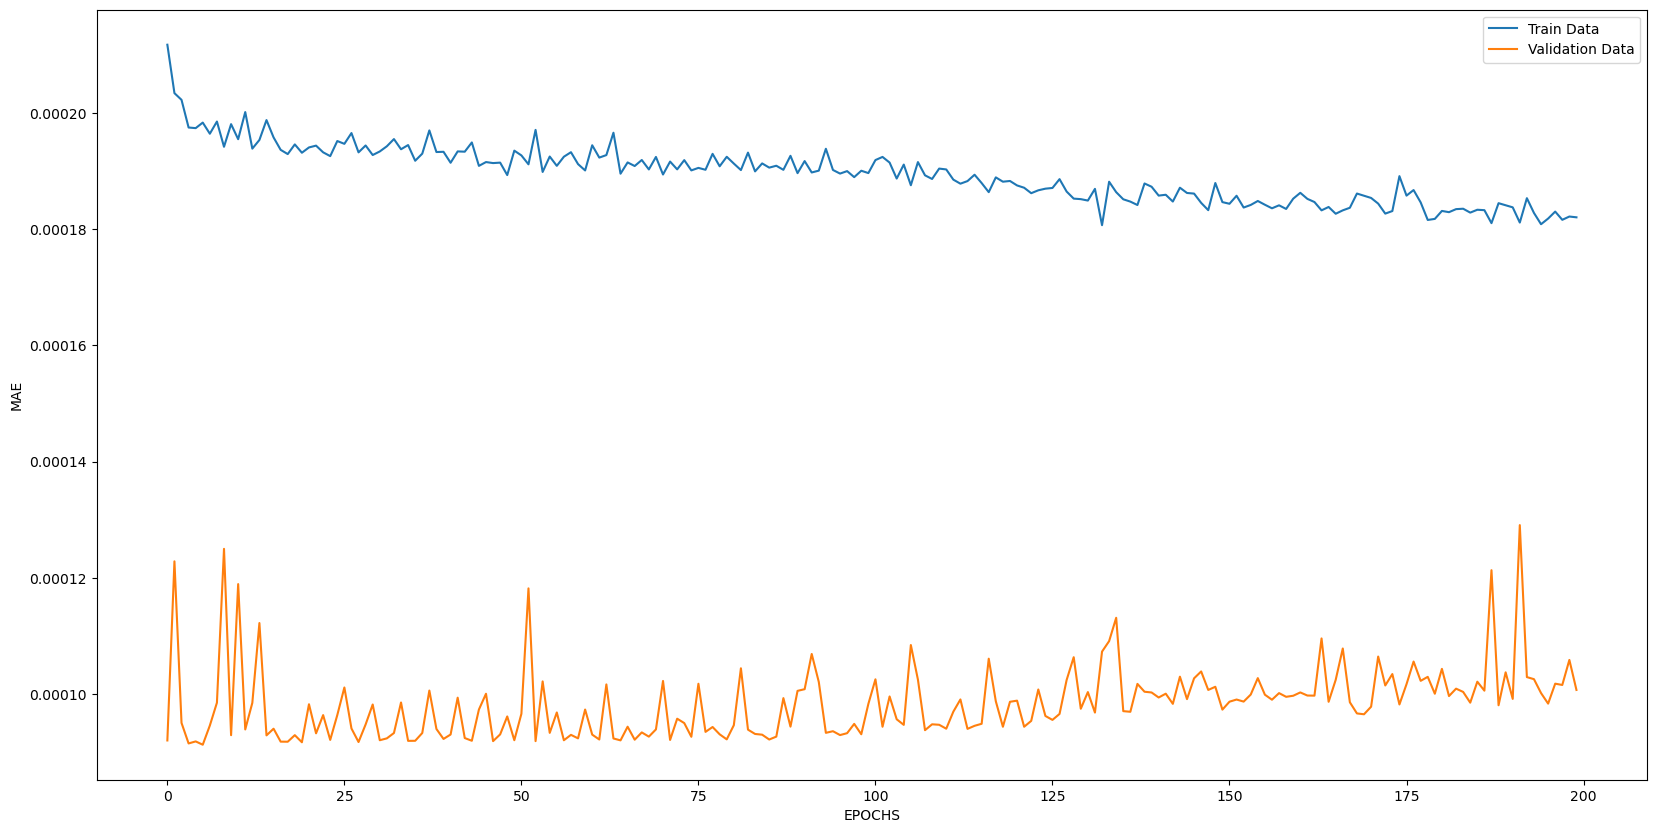

In [226]:
plotHistory(history)

## Intraday Model with multi index

In [205]:
dfs = load_multiple_index_id_all(names,dates)
#dfs= load_multiple_index_id(names, end=dates[0])
dfs[0]
#temp = load_df_intraday(names[1])


Open    High     Low   Close  Adj Close  Volume
Datetime                                                              
2023-05-11 09:00:00 6108.63 6110.19 6108.63 6109.37    6109.37       0
2023-05-11 09:01:00 6112.95 6112.95 6111.67 6111.67    6111.67       0
2023-05-11 09:02:00 6112.13 6112.13 6110.97 6111.26    6111.26       0
2023-05-11 09:03:00 6111.42 6111.42 6107.44 6107.44    6107.44       0
2023-05-11 09:04:00 6107.30 6107.30 6106.22 6106.41    6106.41       0
...                     ...     ...     ...     ...        ...     ...
2023-06-07 16:57:00 5916.85 5916.85 5916.85 5916.85    5916.85       0
2023-06-07 16:58:00 5916.85 5916.85 5916.85 5916.85    5916.85       0
2023-06-07 16:59:00 5916.85 5916.85 5916.85 5916.85    5916.85       0
2023-06-07 17:00:00 5916.85 5916.85 5916.85 5916.85    5916.85       0
2023-06-07 17:05:00 5916.85 5916.85 5916.85 5916.85    5916.85       0

[9610 rows x 6 columns]

In [206]:

global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])
global_data = add_Other_Markets_global_data(dfs, global_data)
global_data

Close  Other1  Other2   Other3
Datetime                                            
2023-05-11 09:00:00 6109.37 9182.40 7388.49      NaN
2023-05-11 09:01:00 6111.67 9195.90 7396.18      NaN
2023-05-11 09:02:00 6111.26     NaN 7400.93      NaN
2023-05-11 09:03:00 6107.44 9195.80     NaN 15945.64
2023-05-11 09:04:00 6106.41 9195.70 7406.67 15940.49
...                     ...     ...     ...      ...
2023-06-07 16:57:00 5916.85 9361.40 7200.72 15950.45
2023-06-07 16:58:00 5916.85 9361.40 7201.47 15952.02
2023-06-07 16:59:00 5916.85 9361.80 7202.22 15951.89
2023-06-07 17:00:00 5916.85 9362.50 7200.14 15951.25
2023-06-07 17:05:00 5916.85 9370.10 7205.99 15959.07

[9610 rows x 4 columns]

In [207]:
import datetime
global_data = global_data[global_data.index.time <= datetime.time(16, 30)].dropna() 
global_data

Close  Other1  Other2   Other3
Datetime                                            
2023-05-11 09:04:00 6106.41 9195.70 7406.67 15940.49
2023-05-11 09:05:00 6106.80 9196.00 7406.37 15940.03
2023-05-11 09:06:00 6107.25 9203.20 7410.29 15950.57
2023-05-11 09:07:00 6108.48 9202.80 7407.66 15955.18
2023-05-11 09:08:00 6108.83 9202.10 7408.56 15951.04
...                     ...     ...     ...      ...
2023-06-07 16:26:00 5927.68 9369.00 7210.48 15963.56
2023-06-07 16:27:00 5928.98 9367.40 7210.03 15963.97
2023-06-07 16:28:00 5930.17 9366.40 7210.15 15964.70
2023-06-07 16:29:00 5929.52 9366.90 7211.34 15967.05
2023-06-07 16:30:00 5929.51 9372.00 7212.15 15970.14

[8935 rows x 4 columns]

In [118]:
print(names[3])
global_data.Other3.describe()

DAX


count    8935.00
mean    15981.02
std       140.45
min     15676.41
25%     15883.97
50%     15948.03
75%     16051.15
max     16330.78
Name: Other3, dtype: float64

(array([15600., 15700., 15800., 15900., 16000., 16100., 16200., 16300.,
        16400.]),
 [Text(0, 15600.0, '15600'),
  Text(0, 15700.0, '15700'),
  Text(0, 15800.0, '15800'),
  Text(0, 15900.0, '15900'),
  Text(0, 16000.0, '16000'),
  Text(0, 16100.0, '16100'),
  Text(0, 16200.0, '16200'),
  Text(0, 16300.0, '16300'),
  Text(0, 16400.0, '16400')])

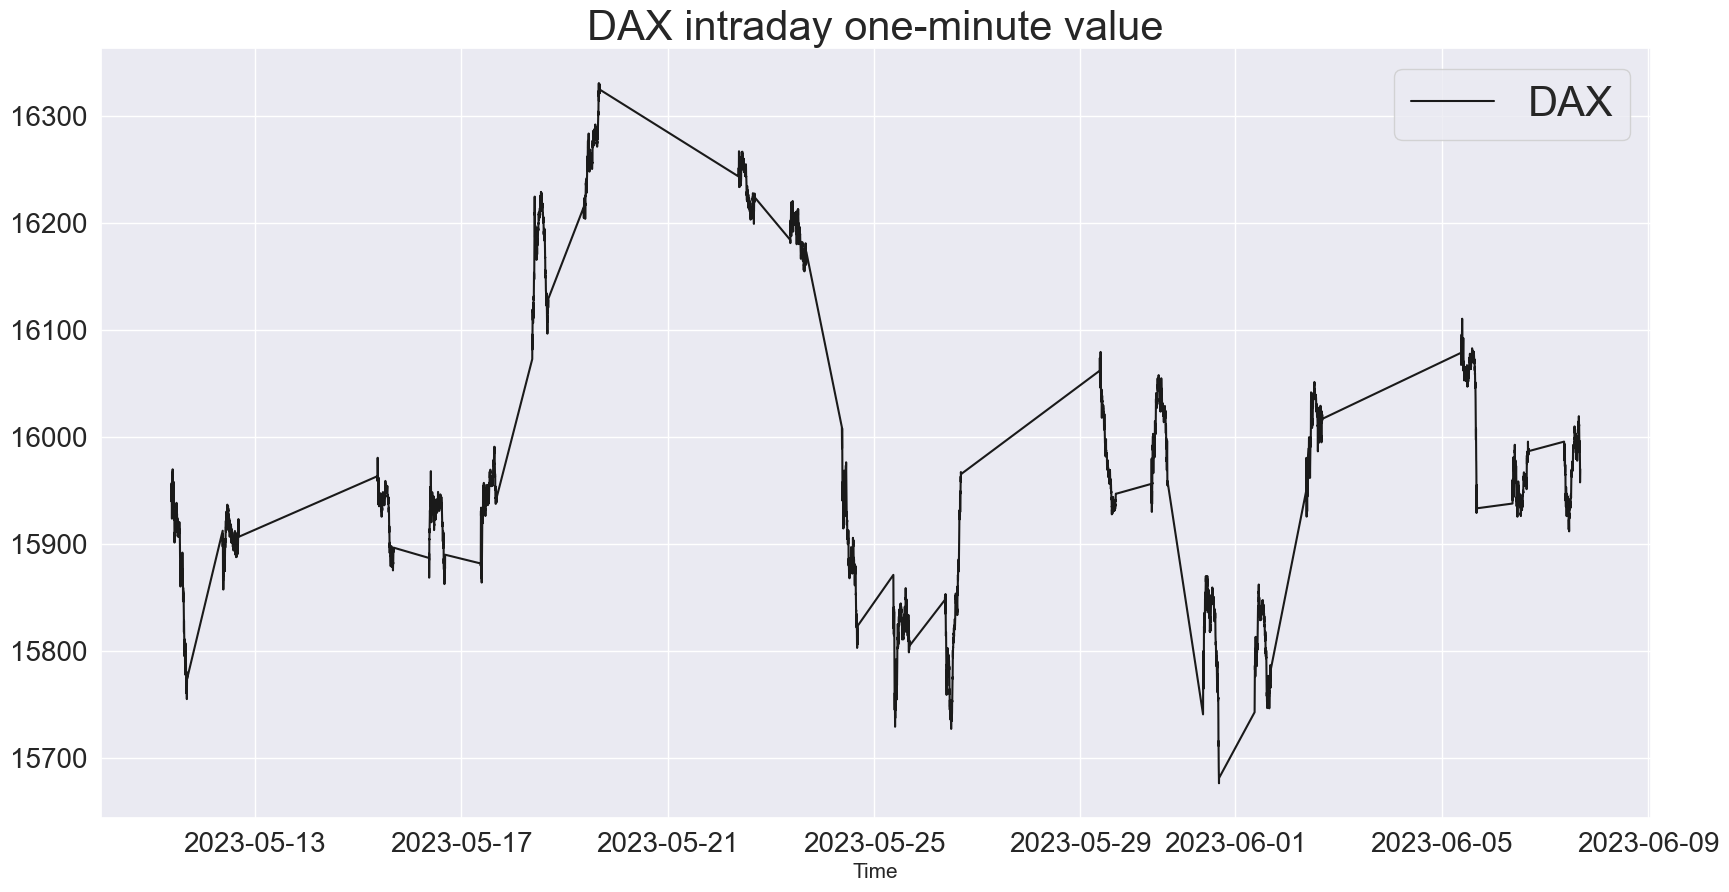

In [123]:
st=names[3]
#plt.plot(global_data['Other1'], 'r', label=st)
#plt.plot(global_data['Other2'], 'b', label=st)
plt.plot(global_data['Other3'], 'k',  label=st)
plt.legend(fontsize=20)
plt.title(st + " intraday one-minute value", fontsize=30)
plt.xlabel('Time', fontsize=15)

plt.legend(fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



In [124]:

size_train_data = global_data.shape[0] - PERIODS_TO_PREDICT
train_data,test_data = divideData(global_data, size_train_data)

In [125]:
#For model based in difflog use this
#scaled_train_data = diffLogData_new(train_data)
#scaled_train_data
#For model based in ABS values use this:
scaled_train_data, scalers = scaleDataMulti(train_data)
scaled_train_data


array([[0.89382879, 0.41647934, 0.73068128, 0.40356378],
       [0.89474628, 0.41732817, 0.72998516, 0.40286087],
       [0.89580634, 0.43771376, 0.73908686, 0.41896803],
       ...,
       [0.48409398, 0.95356907, 0.2851764 , 0.48915718],
       [0.48235213, 0.95668234, 0.2885663 , 0.49167929],
       [0.47983191, 0.94875538, 0.289403  , 0.49270306]])

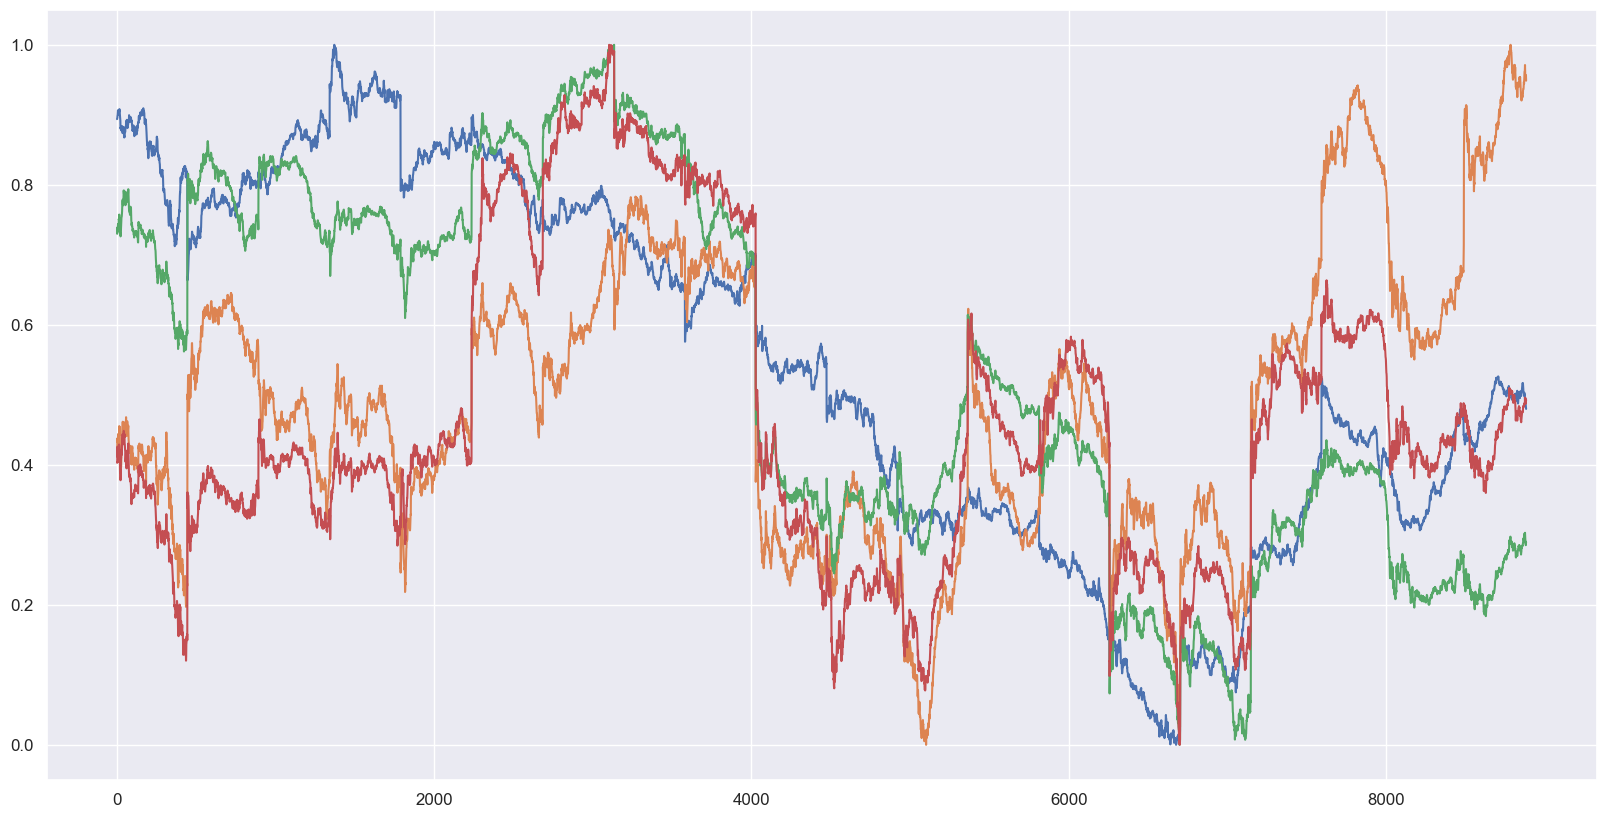

In [127]:
plt.plot(scaled_train_data)

In [53]:

x_train_data = createMultiTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
x_train_data

array([[[0.68444397, 0.48957736, 0.56160581, 0.78597685],
        [0.68717088, 0.49147126, 0.55928981, 0.78402712],
        [0.69032152, 0.53695581, 0.58957124, 0.82870531],
        ...,
        [0.66722822, 0.60455031, 0.74693055, 0.82870531],
        [0.66799709, 0.58685741, 0.7396695 , 0.8178928 ],
        [0.67541579, 0.559695  , 0.707917  , 0.77648072]],

       [[0.68717088, 0.49147126, 0.55928981, 0.78402712],
        [0.69032152, 0.53695581, 0.58957124, 0.82870531],
        [0.6989294 , 0.53442649, 0.56925537, 0.848244  ],
        ...,
        [0.66799709, 0.58685741, 0.7396695 , 0.8178928 ],
        [0.67541579, 0.559695  , 0.707917  , 0.77648072],
        [0.67814269, 0.5445376 , 0.71170407, 0.761984  ]],

       [[0.69032152, 0.53695581, 0.58957124, 0.82870531],
        [0.6989294 , 0.53442649, 0.56925537, 0.848244  ],
        [0.70137952, 0.53000327, 0.57620713, 0.83069644],
        ...,
        [0.67541579, 0.559695  , 0.707917  , 0.77648072],
        [0.67814269, 0.544537

In [54]:

#For model based in difflog use this
#scaled_test_data = diffLogData_new(test_data)

#For model based in ABS values use this:
scaled_test_data, testscaler = scaleDataMulti(test_data)

In [55]:

X_test = createMultiTrainVector(scaled_test_data)
X_test

array([[[0.47182484, 0.12503633, 0.21642632, 0.35013355],
        [0.4484183 , 0.13689473, 0.25518251, 0.35463393],
        [0.46080999, 0.10120328, 0.27733213, 0.3741173 ],
        ...,
        [0.64305863, 0.67860257, 0.40378549, 0.6509824 ],
        [0.57565988, 0.6905191 , 0.42501127, 0.64031686],
        [0.63963329, 0.52380399, 0.38762956, 0.59648385]],

       [[0.4484183 , 0.13689473, 0.25518251, 0.35463393],
        [0.46080999, 0.10120328, 0.27733213, 0.3741173 ],
        [0.5       , 0.09527408, 0.27595764, 0.38516703],
        ...,
        [0.57565988, 0.6905191 , 0.42501127, 0.64031686],
        [0.63963329, 0.52380399, 0.38762956, 0.59648385],
        [0.74968097, 0.54170784, 0.37009914, 0.62813289]],

       [[0.46080999, 0.10120328, 0.27733213, 0.3741173 ],
        [0.5       , 0.09527408, 0.27595764, 0.38516703],
        [0.46698905, 0.13689473, 0.36962596, 0.42806703],
        ...,
        [0.63963329, 0.52380399, 0.38762956, 0.59648385],
        [0.74968097, 0.541707

In [58]:
lstm_biv_model = createLstmModel(x_train_data)
lstm_biv_model._name="Intraday_end_date_" +  dates[0]
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data, epoch=5)

Model: "Intraday_end_date_18-05-2023"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11000     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,626
Trainable params: 18,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
213/213 [==============================] - 12s 38ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 2/5
213/213 [==============================] - 7s 34ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 3/5
213/213 [==============================] - 7s 34ms/step - loss: 0.0012 - val_loss:

# Models Go

#### Intra_day Multi-Stock

In [332]:
def prepareIntradayModel(date) :
    dfs= load_multiple_index_id(names, date)
    global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])
    global_data = add_Other_Markets_global_data(dfs, global_data)   

    import datetime
    global_data = global_data[global_data.index.time <= datetime.time(16, 30)].dropna() 
    
    size_train_data = global_data.shape[0] - PERIODS_TO_PREDICT
    train_data,test_data = divideData(global_data, size_train_data)

    #scaled_train_data = diffLogData_new(train_data)
    scaled_train_data, scalers = scaleDataMulti(train_data)
    
    x_train_data = createMultiTrainVector(scaled_train_data)
    y_train_data = createTargetVector(scaled_train_data[:,0])

    scaled_test_data, testScaler = scaleDataMulti(test_data)
    X_test = createMultiTrainVector(scaled_test_data)

    return global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test


In [333]:

def trainModelsGo (numberOfGos,date, epochs=EPOCHS) :     
    for testNumber in range(1, numberOfGos+1) :
        lstm_biv_model = createLstmModel(x_train_data)
        lstm_biv_model._name="Intraday_end_date_" +  date + "_Go_number_" + str(testNumber)
        print(lstm_biv_model.summary())
        history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data,epochs)
        filename = '.\models_go\model' + date +'_'+str(testNumber)+'.h5'
        lstm_biv_model.save(filename)  # creates a HDF5 file 'my_model.h5'
        

In [334]:
global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test = prepareIntradayModel(dates[3])


In [56]:
trainModelsGo(30, dates[1], epochs=150)

Model: "Intraday_end_date_25-05-2023_Go_number_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11000     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,626
Trainable params: 18,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
213/213 [==============================] - 8s 27ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 2/150
213/213 [==============================] - 5s 23ms/step - loss: 6.2289e-04 - val_loss: 0.0028
Epoch 3/150
213/213 [==============================] - 5s 23ms/step - los

### Intra-day Single Stock

In [85]:
def prepareIntradayModel(date) :
    dfs= load_multiple_index_id(names, date)
    global_data, size_train_data = selectData(type='univariate', datframe=dfs[0])
    global_data = add_Other_Markets_global_data(dfs, global_data)   

    import datetime
    global_data = global_data[global_data.index.time <= datetime.time(16, 30)].dropna() 
    
    size_train_data = global_data.shape[0] - PERIODS_TO_PREDICT
    train_data,test_data = divideData(global_data, size_train_data)

    #scaled_train_data = diffLogData_new(train_data)
    scaled_train_data, scalers = scaleDataMulti(train_data)
    
    #This line is necessary for the single stock model
    scaled_train_data = np.expand_dims(scaled_train_data, axis=1)
    
    x_train_data = createTrainVector(createTrainVector(scaled_train_data))
    y_train_data = createTargetVector(scaled_train_data[:,0])

    scaled_test_data, testScaler = scaleDataMulti(test_data)
    #This line is necessary for the single stock model
    scaled_test_data = np.expand_dims(scaled_test_data, axis=1)

    X_test = createMultiTrainVector(scaled_test_data)

    return global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test

In [151]:
names = ["PSI"]
date = dates[1]

global_data, size_train_data, train_data,test_data, scaled_train_data, x_train_data, y_train_data, scaled_test_data, testScaler, X_test = prepareIntradayModel(date)

In [148]:
global_data

Close
Datetime                   
2023-05-18 09:00:00 6104.22
2023-05-18 09:01:00 6107.79
2023-05-18 09:02:00 6107.51
2023-05-18 09:03:00 6106.46
2023-05-18 09:04:00 6106.15
...                     ...
2023-05-24 16:26:00 5961.64
2023-05-24 16:27:00 5962.12
2023-05-24 16:28:00 5960.70
2023-05-24 16:29:00 5957.77
2023-05-24 16:30:00 5958.16

[2250 rows x 1 columns]

In [63]:
def trainModelsGoSS(numberOfGos,date, epochs=EPOCHS, startGo=1) :     
    for testNumber in range(startGo, numberOfGos+1) :
        lstm_biv_model = createLstmModel(x_train_data)
        lstm_biv_model._name="Intraday_end_date_" +  date + "_Go_number_" + str(testNumber)
        print(lstm_biv_model.summary())
        history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data,epochs)
        filename = '.\models_go\ss\model_ss_' + date +'_'+str(testNumber)+'.h5'
        lstm_biv_model.save(filename)  # creates a HDF5 file 'my_model.h5'



In [64]:
trainModelsGoSS(30, date, epochs=100,startGo=18)

Model: "Intraday_end_date_18-05-2023_Go_number_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
68/68 [==============================] - 5s 33ms/step - loss: 0.0360 - val_loss: 0.0033
Epoch 2/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 3/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0015


# == PREDICTIONS ==

##### Prediction Benchmark

In [183]:

#def generateBenchmark(data=global_data,size=size_train_data): #%% Day - Before Prediction function
def generateBenchmark(data,size=size_train_data): #%% Day - Before Prediction function
        d_before_price = data.iloc[size-1:].copy()
        day_before_price_copy = d_before_price.copy()

 
        for i in range(1,d_before_price.size):
                d_before_price['Close'][i] = day_before_price_copy['Close'][i-1].copy()

        return d_before_price.iloc[1:]

##### Evaluate Predictions:

In [184]:
def testPredictionsScore(data=test_data, type=""):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted_stock_price))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [185]:
## TO check if necessary (only for fopreign becaus of lookback)
def testPredictionsScore_f(actual=test_data, type="", predicted=""):
    
    print('==================================')
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [186]:
def testDayBeforeScore(actual, predicted):
    
    #testScore = np.sqrt(mean_squared_error(global_data.iloc[size_train_data:], day_before_price['Close']))
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    #predicted.to_numpy()

    print('==================================')
    print('Test Score Day before: %.2f RMSE' % (testScore))
    print('==================================')

In [187]:
def generateEvolutionArray(predicted, actual, numCat=2) :  
    predicted_stock_evo = np.where(predicted < 0, 0, 1).squeeze()
    actual_stock_evo = np.where(actual < 0, 0, 1)
    if numCat >2 :
        #threshold_pred = (-np.percentile(predicted, 33)+np.percentile(predicted, 66))/2
        threshold_pred = max(abs(np.percentile(predicted, 33)),np.percentile(predicted, 66))
        threshold_act = max(abs(np.percentile(actual, 33)),np.percentile(actual, 66))
        threshold_act = threshold_pred*1.2
        predicted_stock_evo = np.where(predicted < -threshold_pred, 0, np.where(predicted > threshold_pred, 2, 1)).squeeze()

        actual_stock_evo = np.where(actual < -threshold_act, 0, np.where(actual > threshold_act, 2, 1))
    
    return predicted_stock_evo, actual_stock_evo


#### Plotting the results

In [188]:
def fillDataForPlotting (history,predicted,benchmark): 
    #Setting Vectors for plotting
    tr_data = history.iloc[:size_train_data]
    tt_data = history.iloc[size_train_data:]
    tt_data = tt_data.assign(Predictions=predicted)
    if (not benchmark.empty):
        tt_data = tt_data.assign(Day_Before=benchmark)
    return tr_data,tt_data

In [189]:
def plotAllHistory (train_data,test_data,title): 
    #Plotting all history
    plt.plot(train_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - All history", fontsize=30)
    plt.xlabel('Time', fontsize=15)
    #plt.legend(fontsize=20, loc=3)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  

In [190]:
def plotPredictedPeriod (test_data, title,printBenchmark):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    if printBenchmark:
        plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - Predicted Period", fontsize=30)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Closing Value',fontsize=25)
    #plt.legend(fontsize=20, loc=3)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  


In [191]:
def plotResults(history=global_data, predicted="",benchmark=pd.DataFrame(), title=""):
    tr_data,tt_data = fillDataForPlotting(history,predicted,benchmark);
    plotAllHistory(tr_data,tt_data, title);
    #Only prints benchmark if not empty
    plotPredictedPeriod(tt_data,title,not benchmark.empty);


### Running Predictions

##### Linear Model

In [192]:
#Linear model
day_before_price = generateBenchmark(global_data,size_train_data)
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


2/2 [==============================] - 1s 4ms/step


In [193]:
testPredictionsScore(test_data, predicted_stock_price)


Test Score: 43.57 RMSE


C:\Users\queir\AppData\Local\Temp\ipykernel_7360\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [194]:

testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)


Test Score Day before: 42.33 RMSE


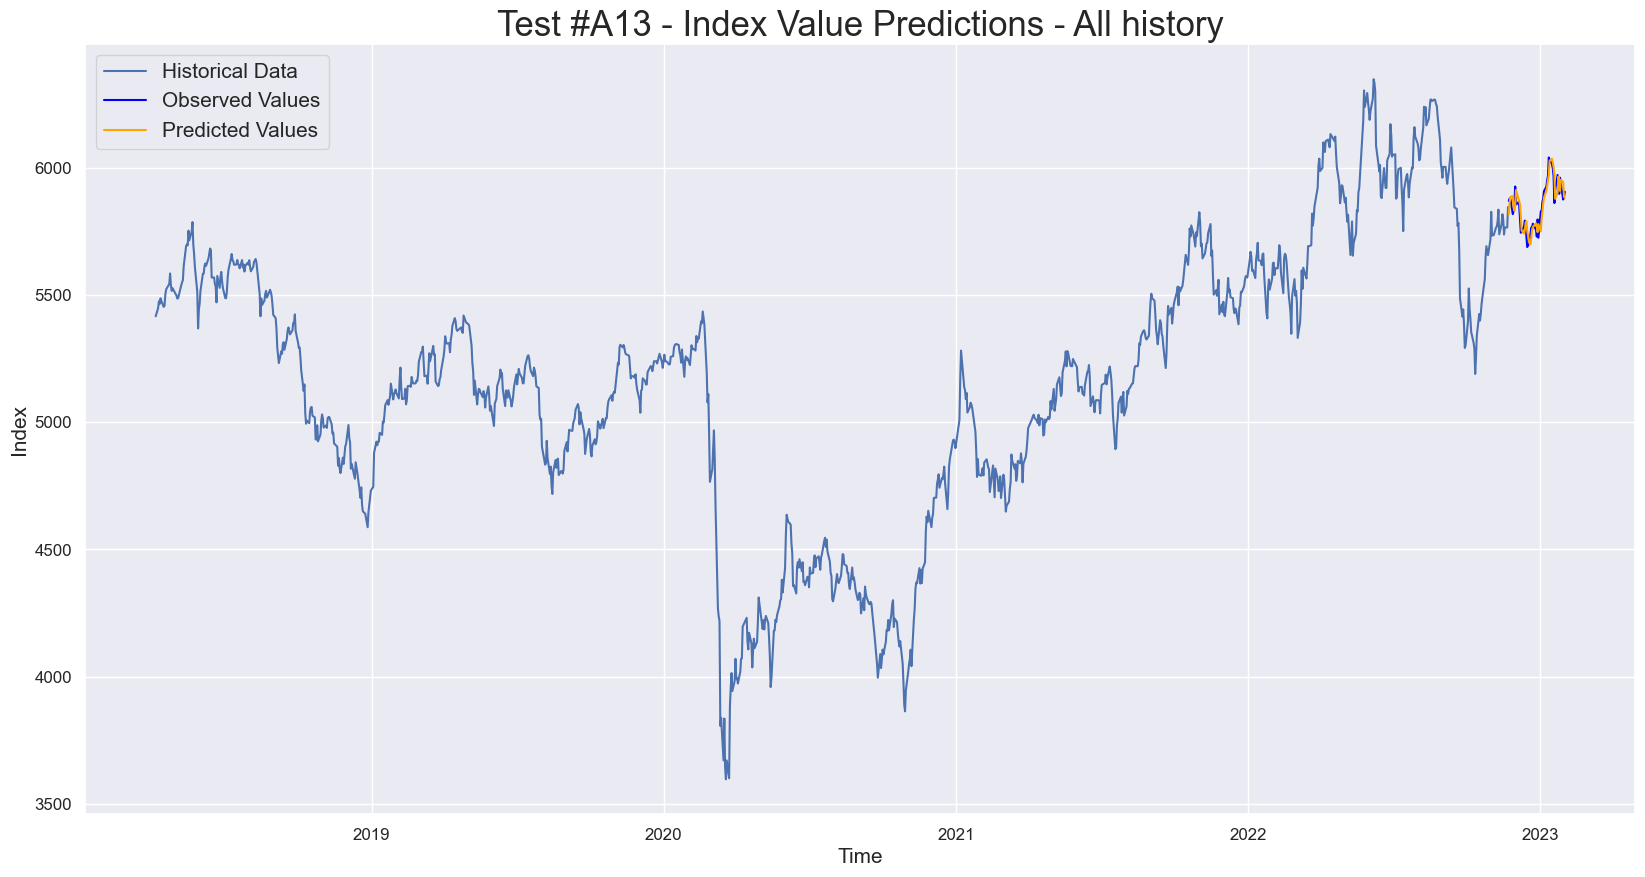

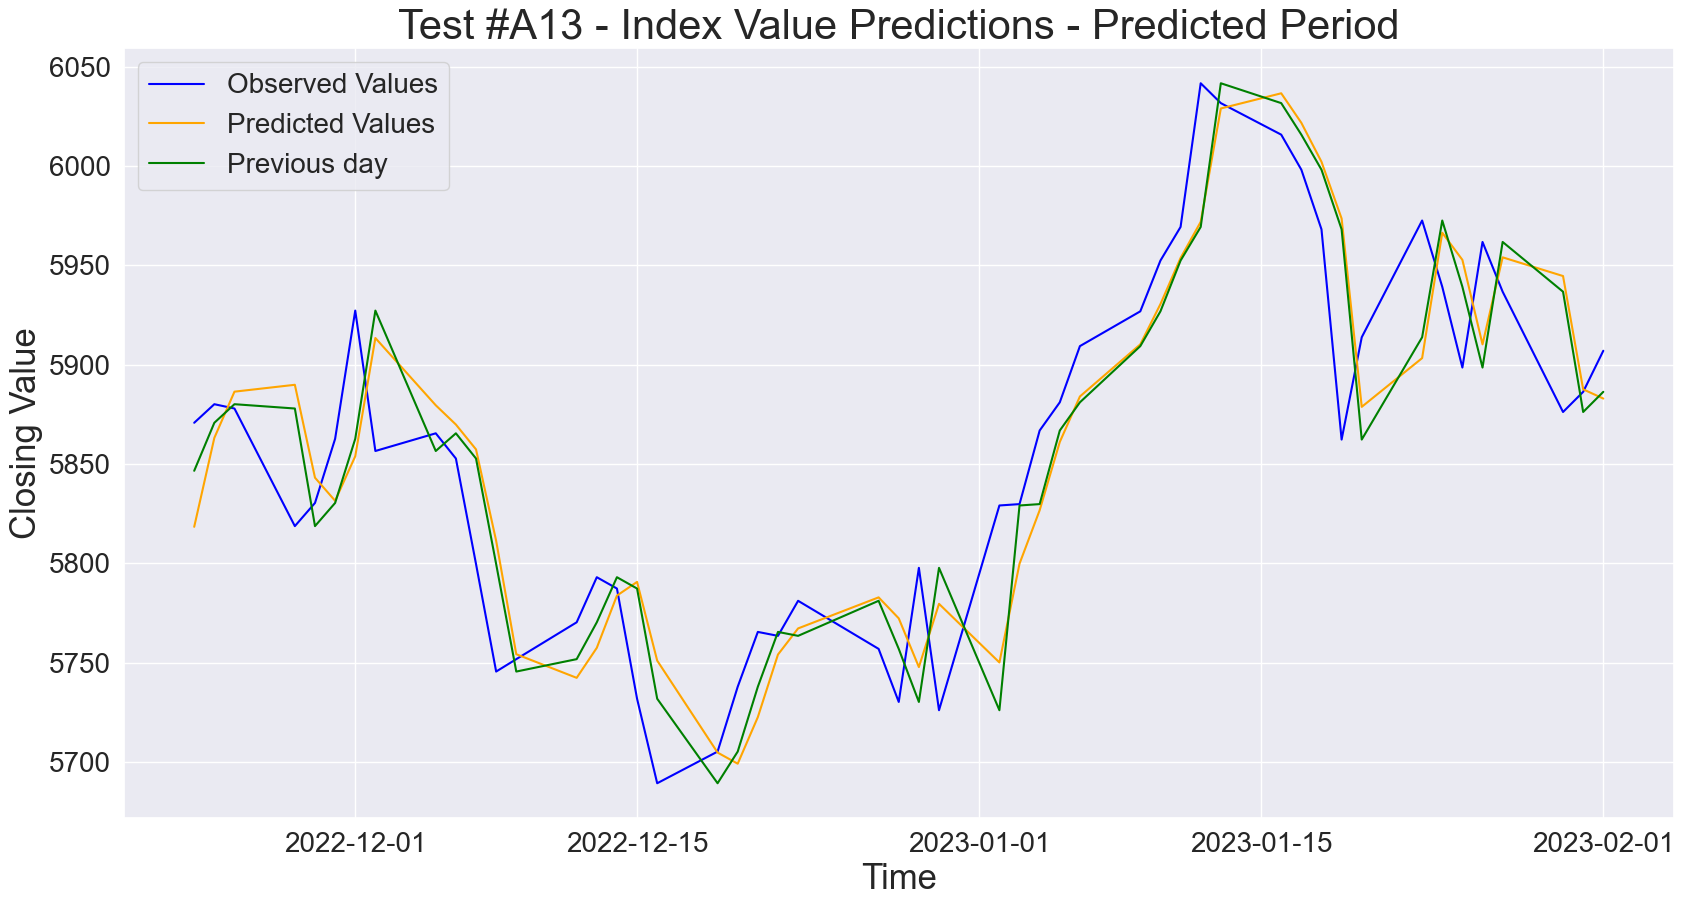

In [205]:
plotResults(predicted=predicted_stock_price,benchmark=day_before_price, title="Test #A13 - Index Value Predictions")

##### Bivariate Model


In [192]:
#Bivariate model
predicted_stock_price=lstm_biv_model.predict(X_test)

predicted_stock_price=scaler.inverse_transform(predicted_stock_price)
#predicted_stock_price=testscaler[0].inverse_transform(predicted_stock_price)

np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_price))
#np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_price))



2/2 [==============================] - 0s 7ms/step


43.754524196323686

In [193]:
testPredictionsScore()

# For bivariate use data=global_data.drop(['Other1']
day_before_price = generateBenchmark(data=global_data[['Close']])

#testDayBeforeScore(predicted=day_before_price, actual=test_data[LOOK_BACK:,0])
testDayBeforeScore(predicted=day_before_price, actual=global_data.iloc[-PERIODS_TO_PREDICT:,0])

Test Score: 43.75 RMSE
Test Score Day before: 42.33 RMSE


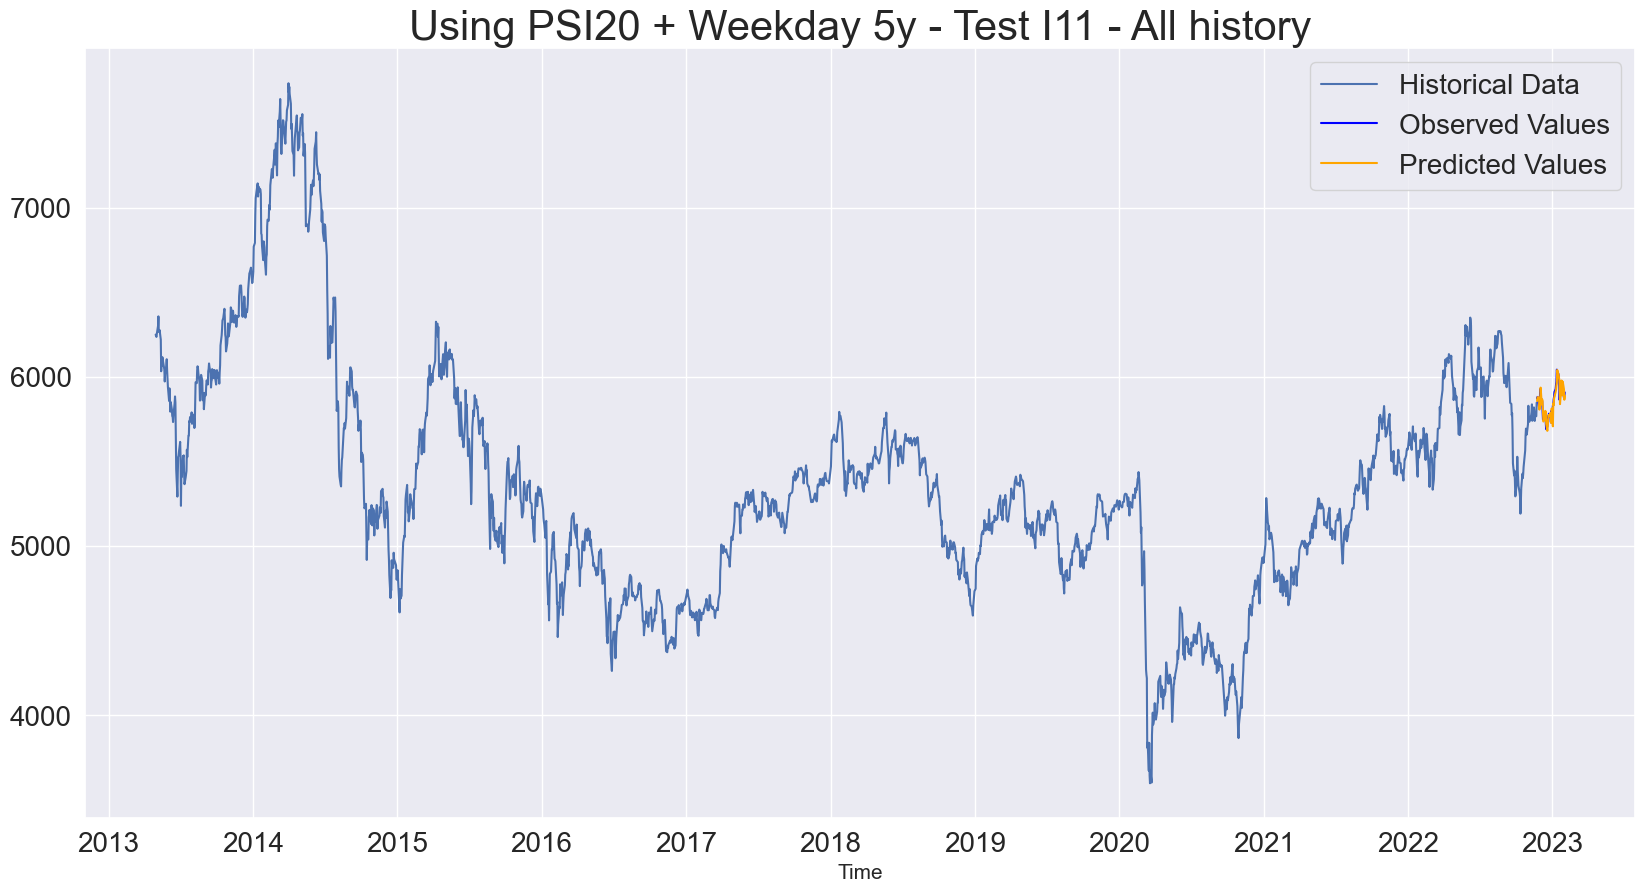

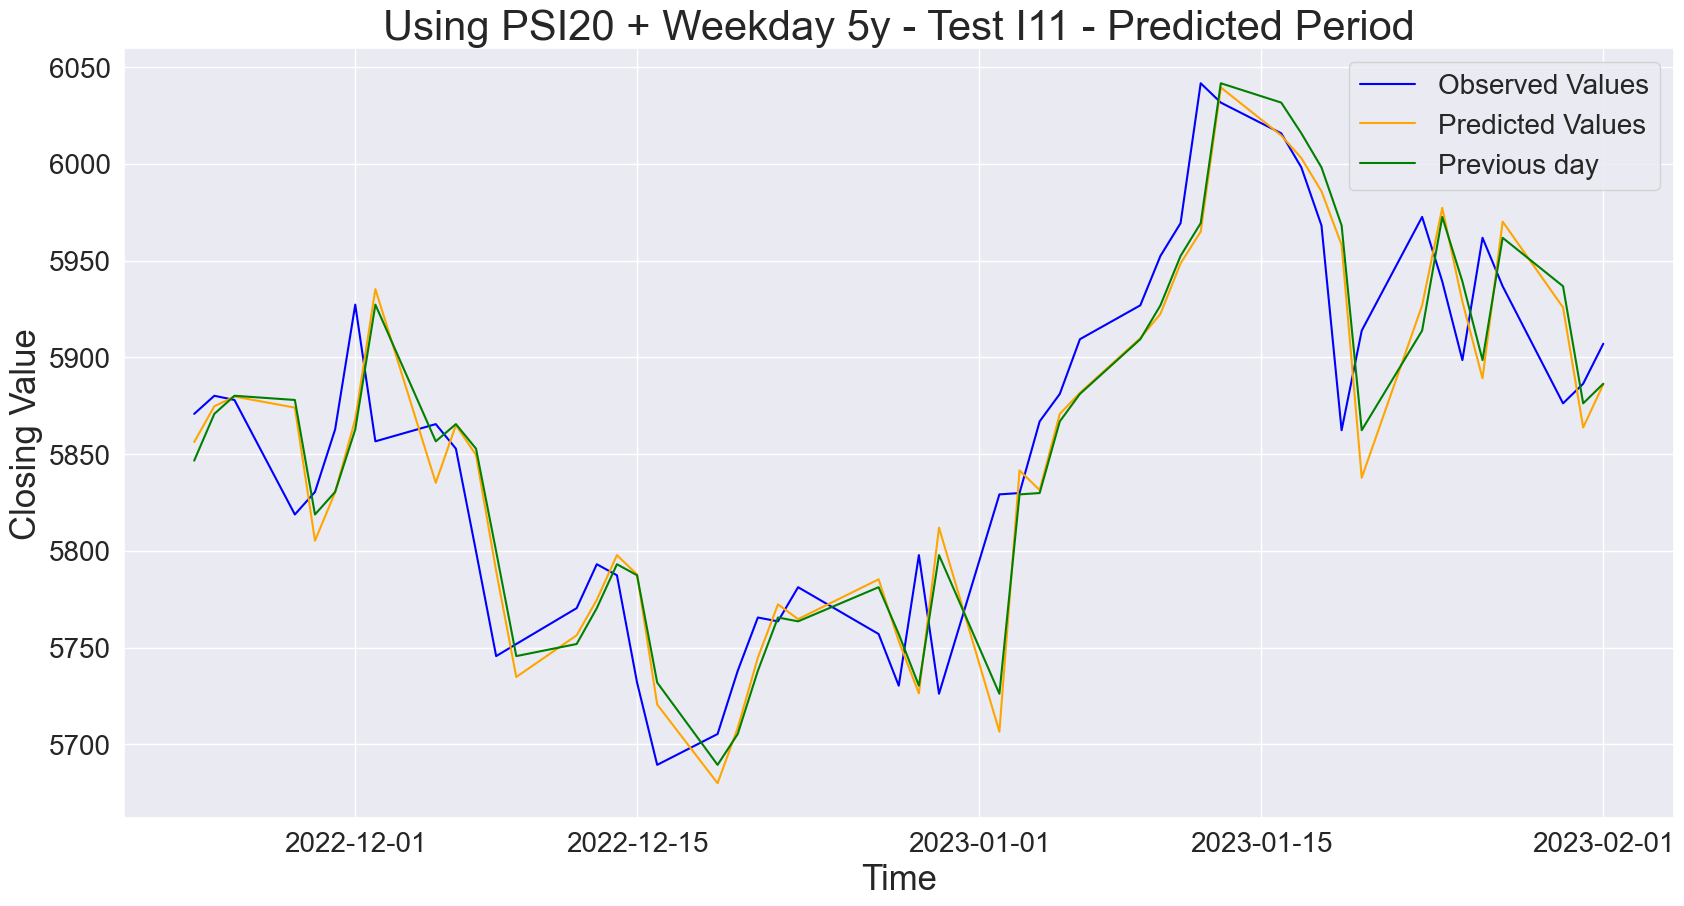

In [194]:
plotResults(history=global_data[['Close']],predicted=predicted_stock_price,benchmark=day_before_price, 
            title="Using PSI20 + Weekday 5y - Test I11")

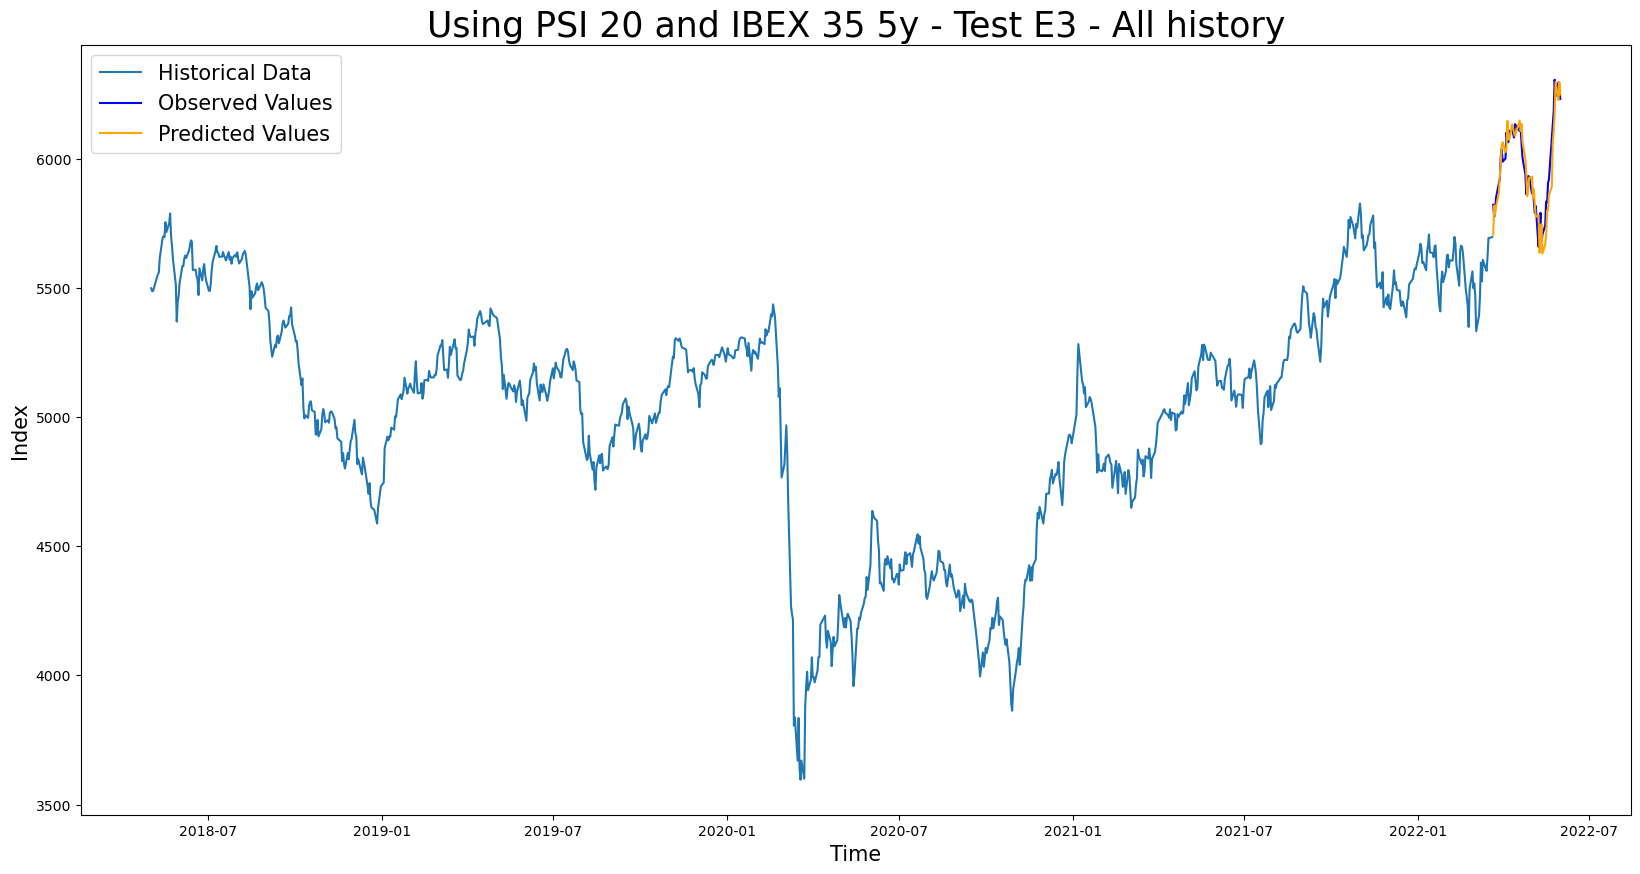

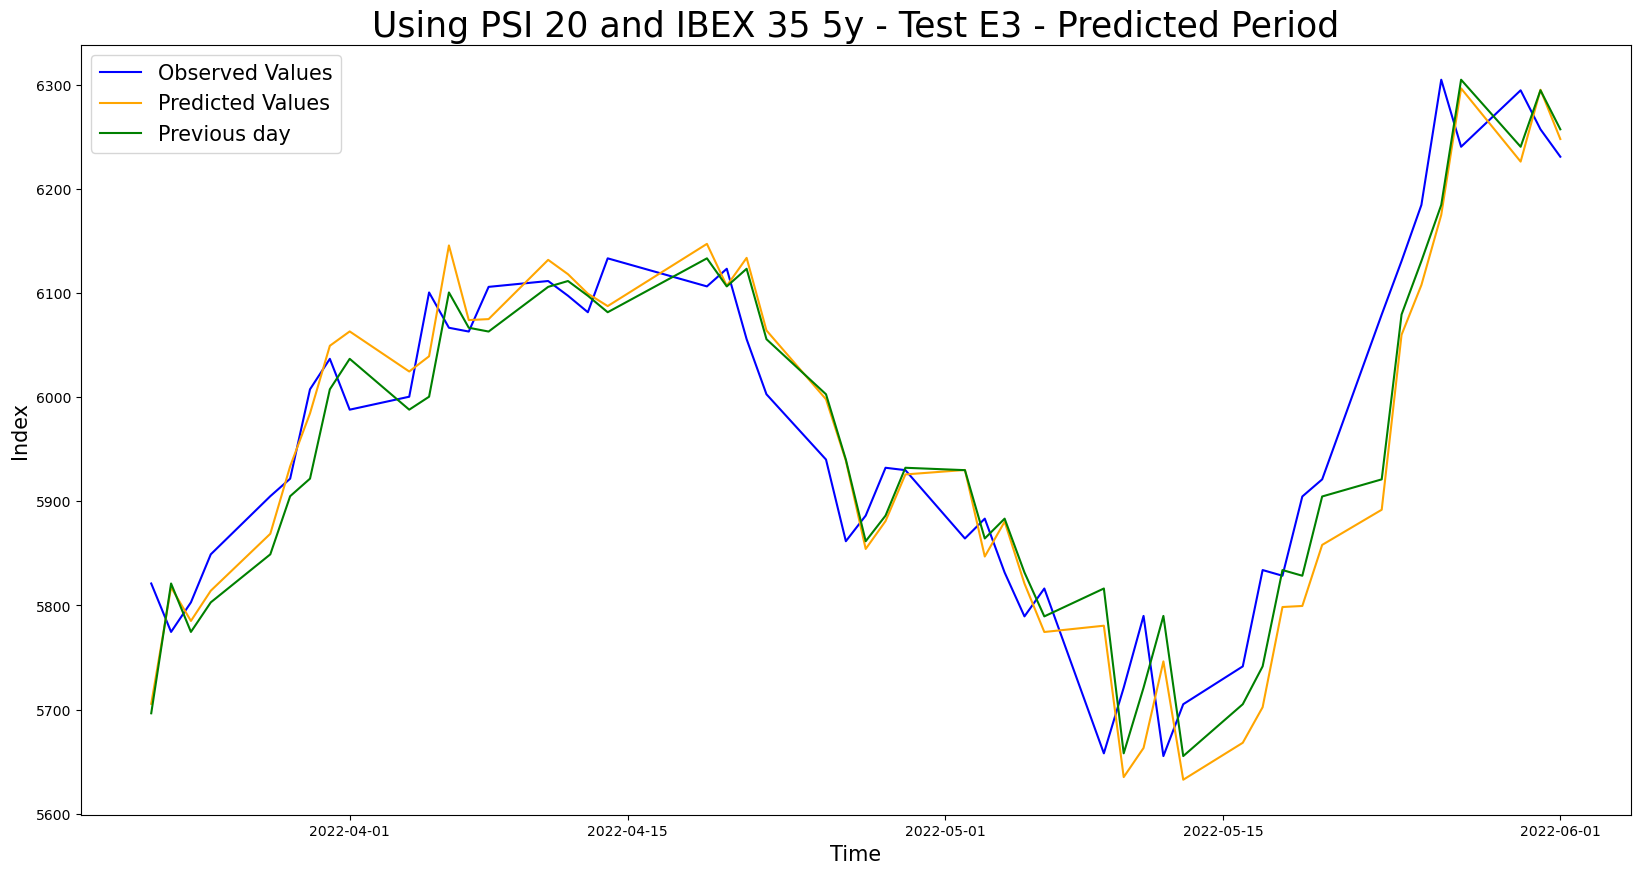

In [155]:
# For bivariate use data=global_data.drop(['Volume']
plotResults(history=global_data.drop(['Other1'], axis=1),predicted=predicted_stock_price,benchmark=day_before_price, 
            title="Using PSI 20 and " + NAME_FOREIGN + " 5y - Test E3")



##### DiffLog Model


In [ ]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

In [78]:
#This is the correct one
predicted_stock_price = undiffLogData2(test_data[LOOK_BACK:], diff_logged_predictions);


In [79]:
testPredictionsScore(test_data, predicted_stock_price)
#testDayBeforeScore()

Test Score: 48.25 RMSE


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_46616\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [80]:
day_before_price = generateBenchmark(global_data,size_train_data)
testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)

Test Score Day before: 51.03 RMSE


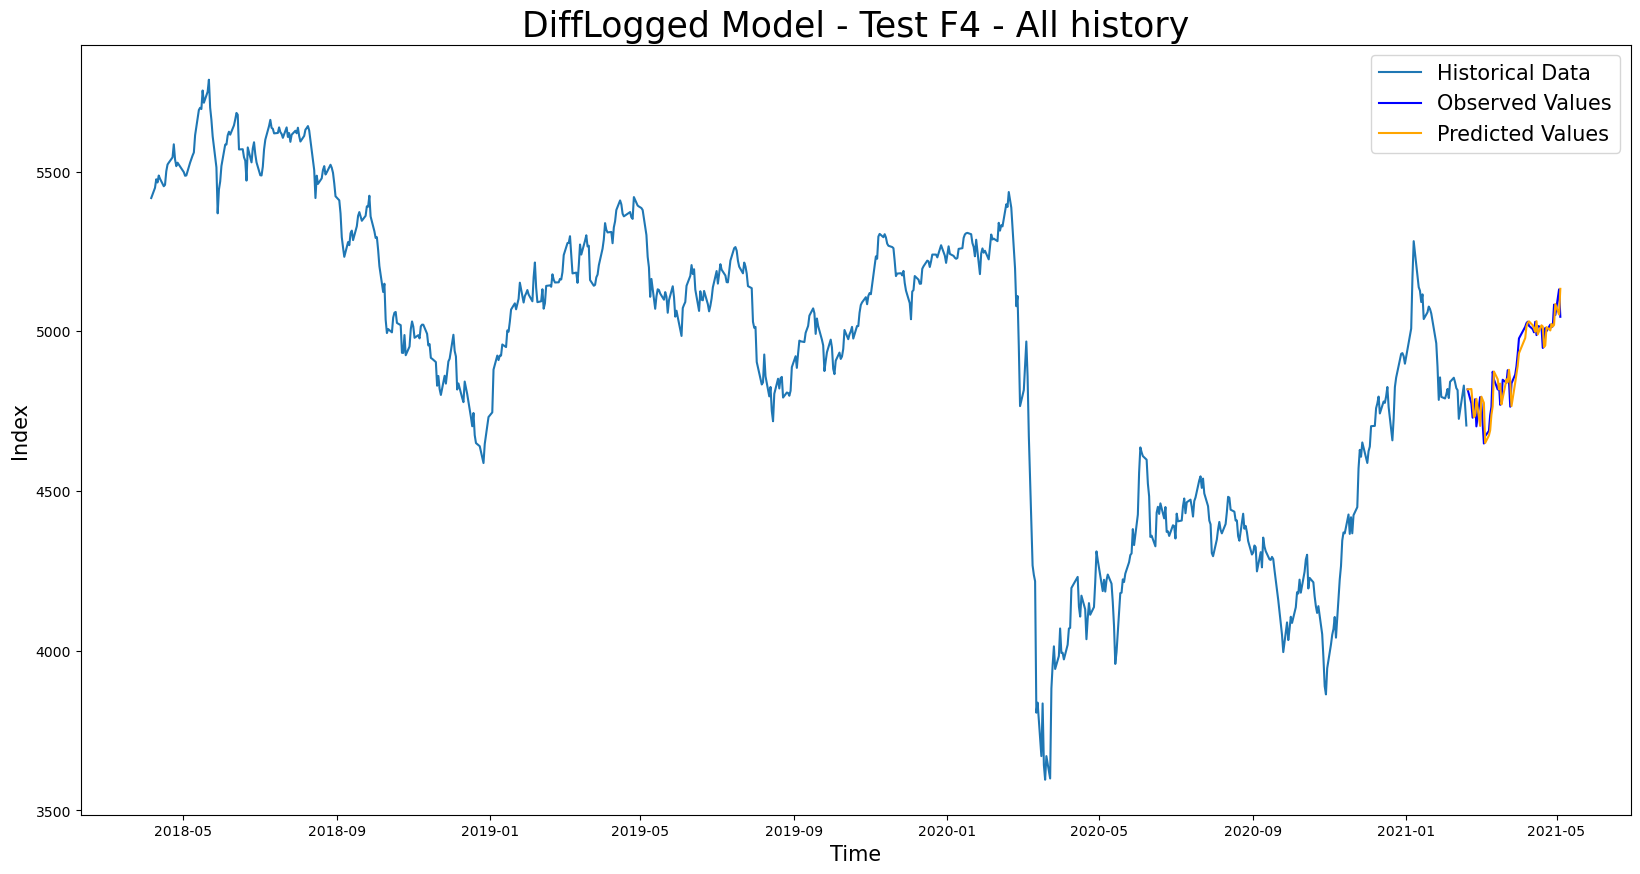

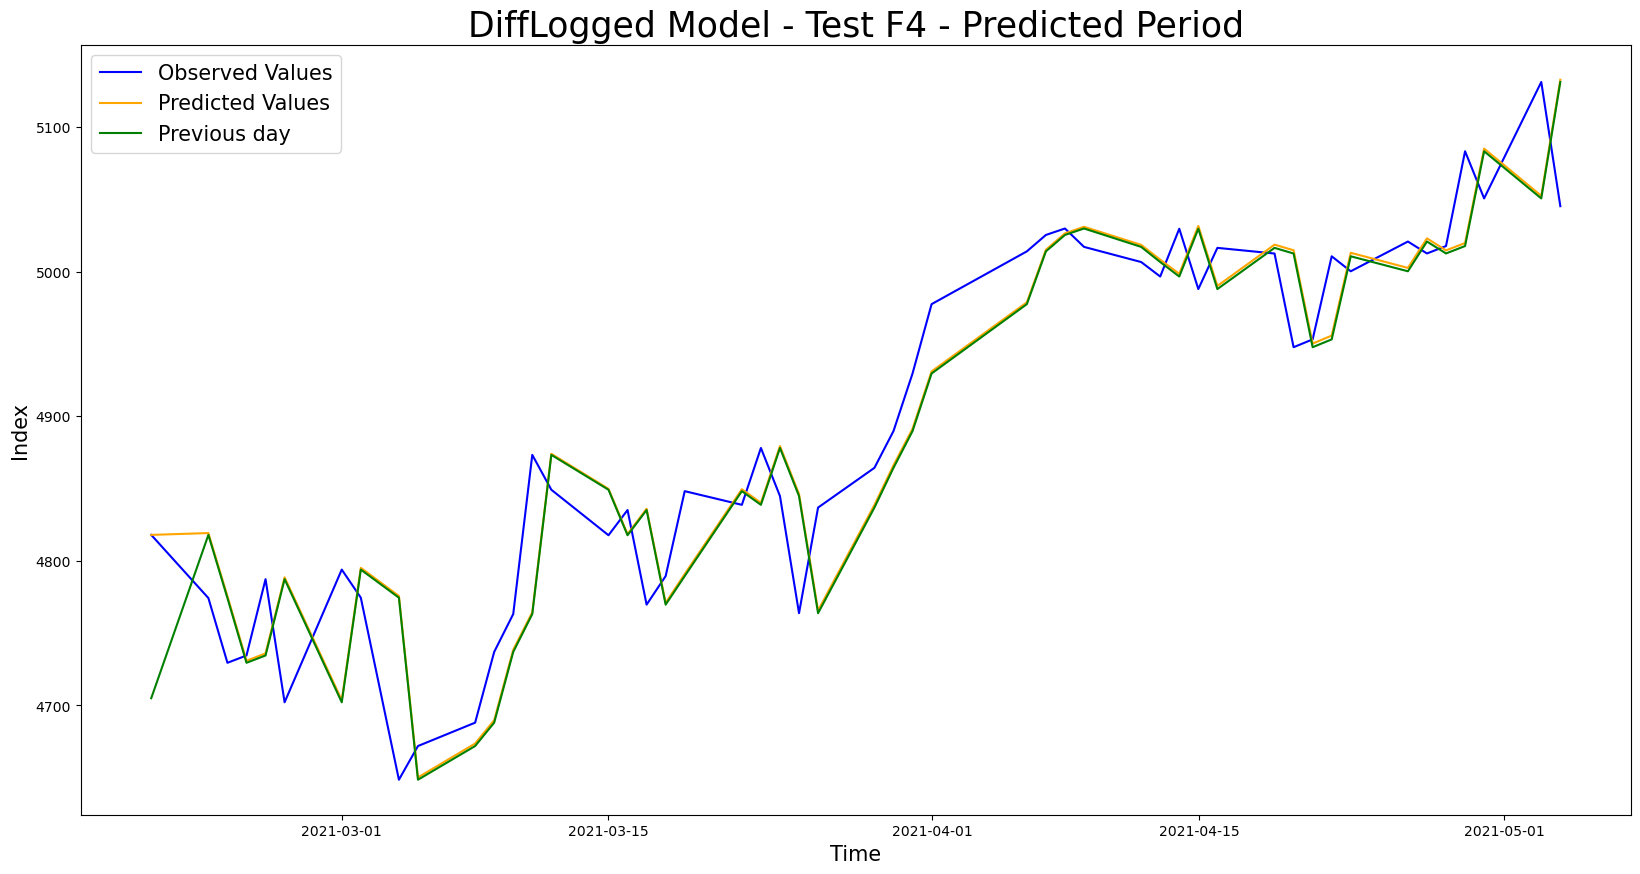

In [81]:
plotResults(history=global_data, predicted=predicted_stock_price,benchmark=day_before_price, title="DiffLogged Model - Test F4")

##### Classification Model

In [76]:
#Category Model
predicted_stock_cat=lstm_class_model.predict(X_test)
print("Test C4")
predicted_stock_cat

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step
Test C4


array([[0.2963217 , 0.4404843 , 0.263194  ],
       [0.29984742, 0.44782916, 0.25232342],
       [0.29946584, 0.45300466, 0.24752955],
       [0.3030627 , 0.45212263, 0.24481463],
       [0.3719363 , 0.36593065, 0.26213306],
       [0.40373418, 0.29470468, 0.3015611 ],
       [0.40331715, 0.26104742, 0.33563545],
       [0.37501842, 0.2623541 , 0.36262754],
       [0.2955931 , 0.40085214, 0.3035547 ],
       [0.28457722, 0.42208582, 0.293337  ],
       [0.30066705, 0.41654572, 0.2827873 ],
       [0.3053262 , 0.40073556, 0.29393822],
       [0.3029196 , 0.38653582, 0.31054452],
       [0.29080692, 0.3689407 , 0.3402523 ],
       [0.28722164, 0.376974  , 0.33580428],
       [0.279835  , 0.3803896 , 0.33977544],
       [0.27821502, 0.38136944, 0.34041545],
       [0.28186426, 0.38250685, 0.33562896],
       [0.28220862, 0.3856775 , 0.3321138 ],
       [0.27867174, 0.39145237, 0.32987595],
       [0.2763742 , 0.40038317, 0.32324266],
       [0.28247157, 0.41270933, 0.30481917],
       [0.

In [77]:
y_train_data[:,0].sum()
y_train_data[:,1].sum()

379.0

In [78]:

predictions=np.argmax(predicted_stock_cat, axis=1)
observations =  np.argmax(Y_test, axis=1)

In [79]:
#print(predicted_stock_cat)
from sklearn.metrics import accuracy_score

print("Predicions:")
print(predictions)

print("Total of " + str(len(predictions)) + " values.\n")

print("Observed:")
print(observations)
print(str(len(observations)) + " values.\n")

print("Accuracy:" + str(accuracy_score(observations, predictions)*100) +"%.")

##testPredictionsScore("categorical")




Predicions:
[1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Total of 49 values.

Observed:
[1 1 0 1 2 2 0 1 1 0 0 1 2 2 1 0 0 1 2 2 1 2 0 0 2 0 2 1 2 1 2 1 2 1 2 1 1
 0 0 0 2 2 0 0 2 0 0 1 2]
49 values.

Accuracy:32.6530612244898%.


In [80]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(observations, predictions)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix




array([[ 1, 15,  0],
       [ 1, 15,  0],
       [ 2, 15,  0]], dtype=int64)

<AxesSubplot: title={'center': '"C4" Heatmap'}>

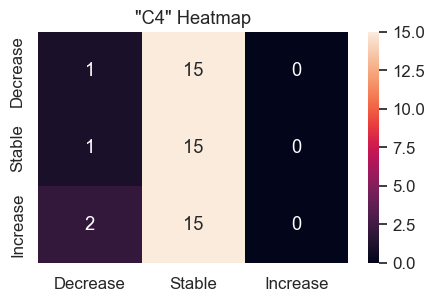

In [81]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable","Increase"],
                  columns = ["Decrease", "Stable","Increase"])
plt.figure(figsize = (5,3))
plt.title('"C4" Heatmap')
sn.heatmap(df_cm,annot=True)

In [166]:
#PARA ELIMINAR
#Making a list with the actual index value variations.

# Selecting the 50 last values and logging
test_data_log = np.log(test_data[90:])
test_data_diff = test_data_log[0:49,]

# iterating the log array and returing the diff to the test_data_diff array
for i in range (len(test_data_log)-1) :
    test_data_diff[i] = test_data_log[i+1] - test_data_log[i]

observed = test_data_diff.T[0]

#test_obs = createTargetClassVector(test_data, numCat=3)

print(observed)





[]


#### Linear with foreign data

In [307]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_price=lstm_model.predict(X_test)


2/2 [==============================] - 1s 8ms/step


In [308]:

#We (un)scale the data back.
pred=scaler_p.inverse_transform(predicted_stock_price)

In [318]:
len(test_data_p[-50:])

50

In [324]:
testPredictionsScore_f(actual=test_data_p[-PERIODS_TO_PREDICT:], predicted=pred)


Test Score: 1510.81 RMSE


In [326]:
testDayBeforeScore(test_data_p[-PERIODS_TO_PREDICT:],day_before_price)

Test Score Day before: 75.02 RMSE


In [310]:
test_data_p

array([[5849.12011719],
       [5904.99023438],
       [5921.83984375],
       [6007.68017578],
       [6036.97021484],
       [5988.12011719],
       [6000.56982422],
       [6100.74023438],
       [6066.81982422],
       [6063.18017578],
       [6106.10986328],
       [6111.74023438],
       [6097.58007812],
       [6081.74023438],
       [6133.52001953],
       [6106.56982422],
       [6123.50976562],
       [6055.83007812],
       [6002.91015625],
       [5940.18994141],
       [5861.72021484],
       [5886.33984375],
       [5932.29980469],
       [5930.00976562],
       [5864.35986328],
       [5883.41992188],
       [5831.68017578],
       [5789.50976562],
       [5816.29003906],
       [5657.91992188],
       [5721.02001953],
       [5789.95996094],
       [5655.29003906],
       [5705.12011719],
       [5741.47998047],
       [5834.02978516],
       [5828.56005859],
       [5904.72021484],
       [5921.16015625],
       [6079.50976562],
       [6130.89990234],
       [6184.839

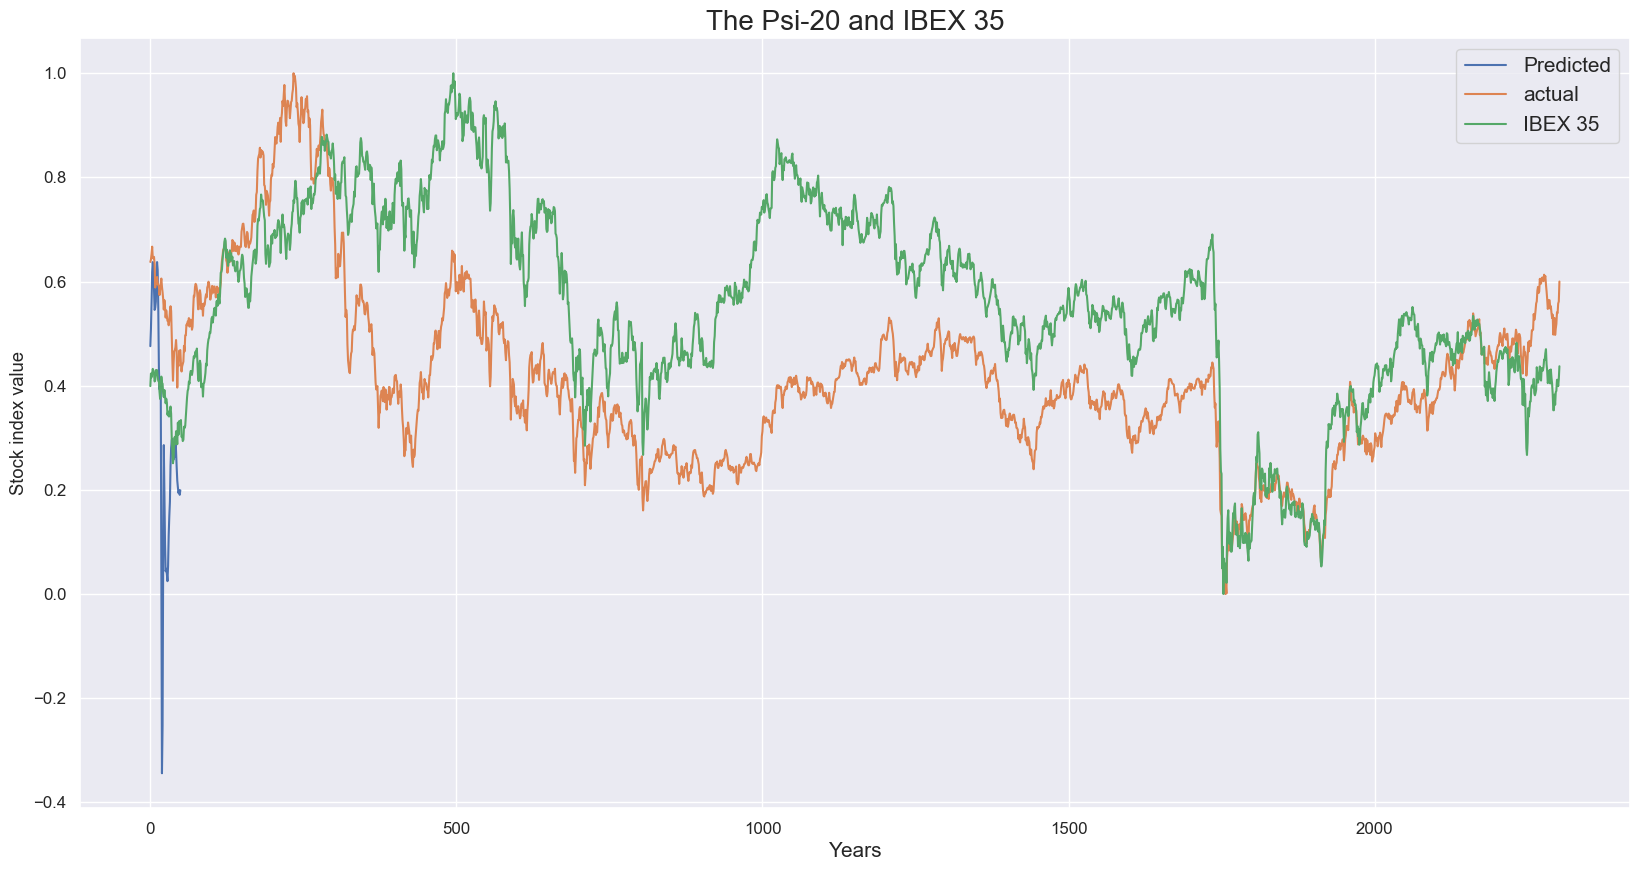

In [328]:
plt.plot(predicted_stock_price, label='Predicted')
plt.plot(scaled_train_data_p, label='actual')
plt.plot(scaled_train_data, label=NAME_FOREIGN)
plt.xlabel("Years", fontsize=15)
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=20)
plt.legend(fontsize=15)
plt.show()

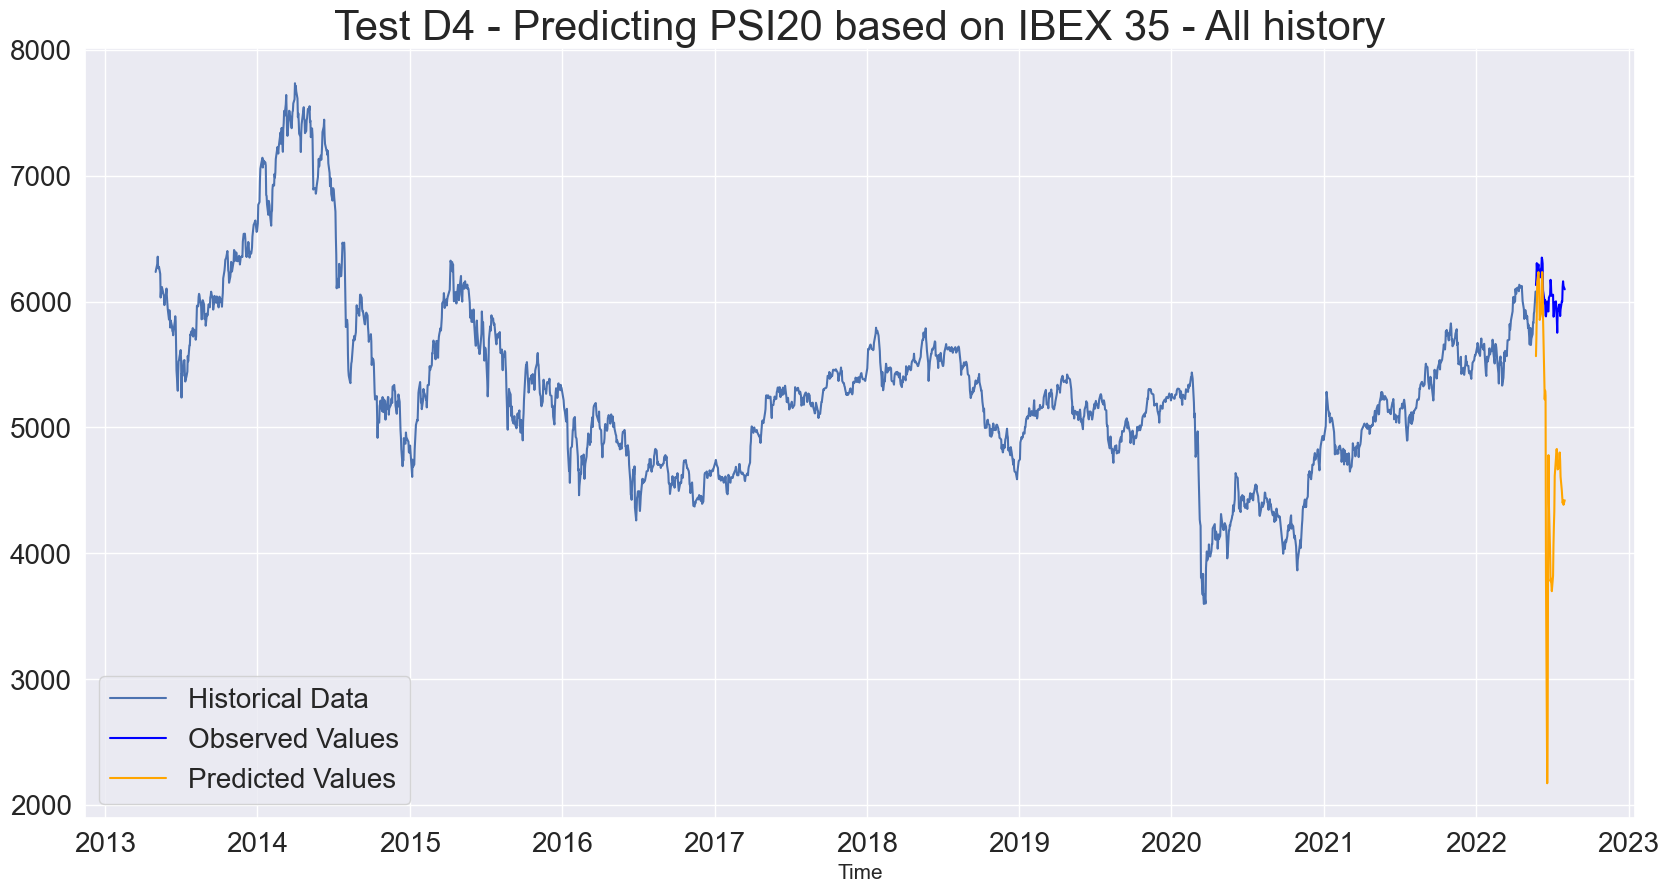

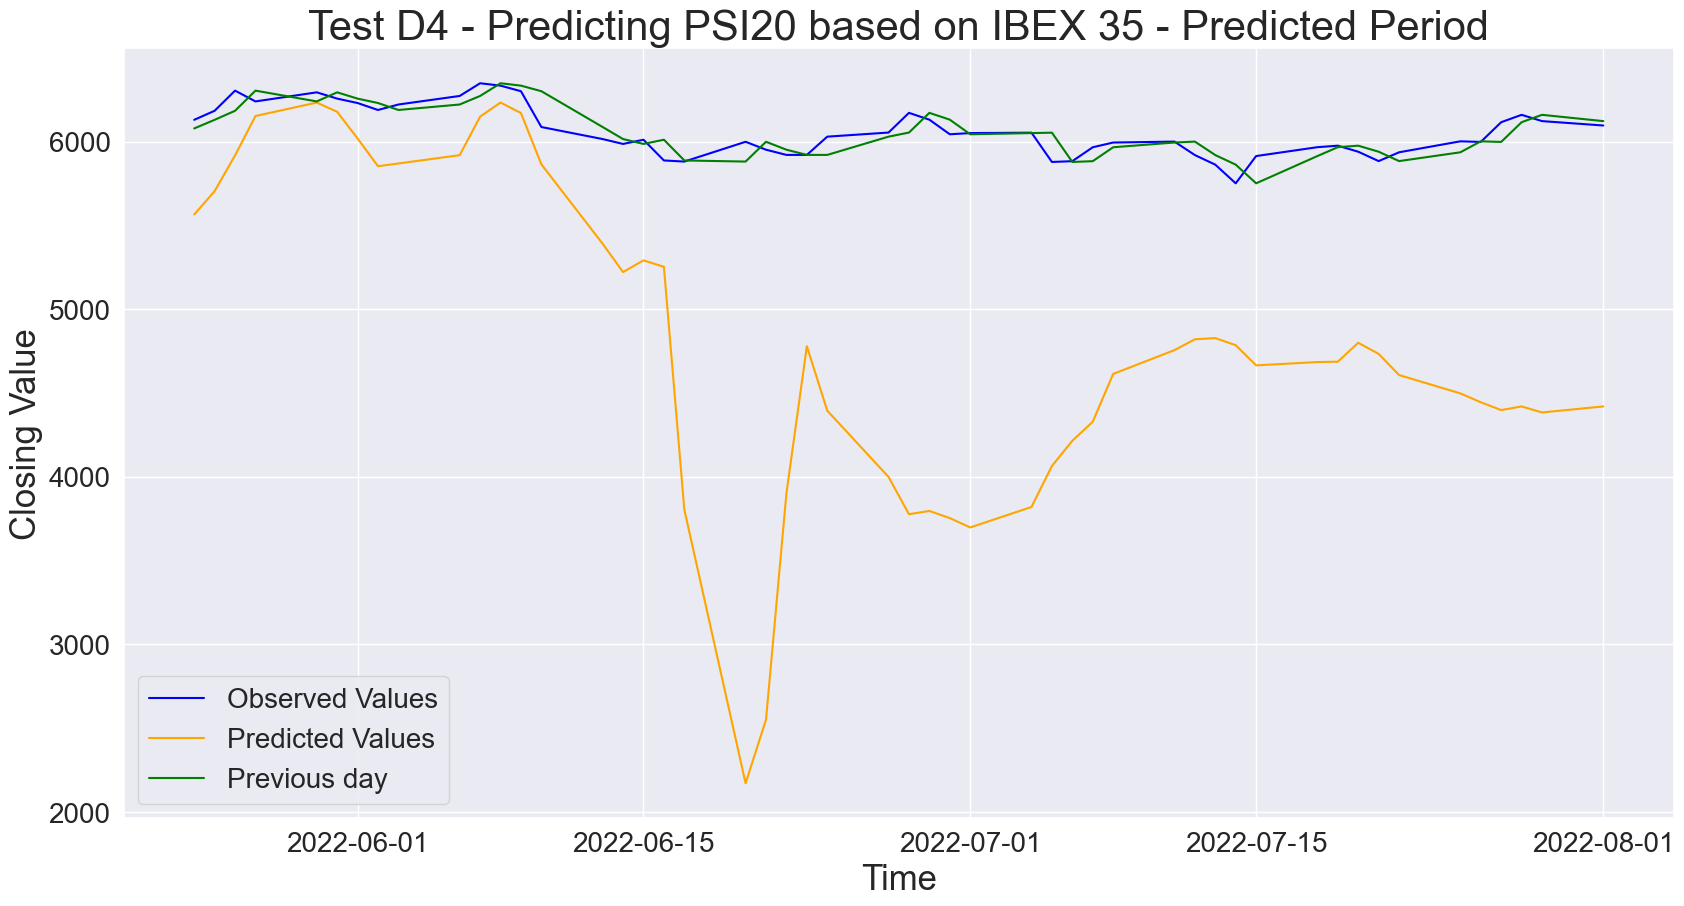

In [343]:
plotResults(history=global_data_p, predicted=pred,benchmark=day_before_price,title="Test D4 - Predicting PSI20 based on " + NAME_FOREIGN + "")



#### Multi Predictor

In [105]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

1/1 [==============================] - 0s 469ms/step


In [106]:
predicted_stock_price= undiffLogData(diff_logged_predictions,test_data[LOOK_BACK])
predicted_stock_price=np.expand_dims(predicted_stock_price, axis=1)  

In [ ]:
day_before_price = generateBenchmark(global_data,size_train_data)[:-1]


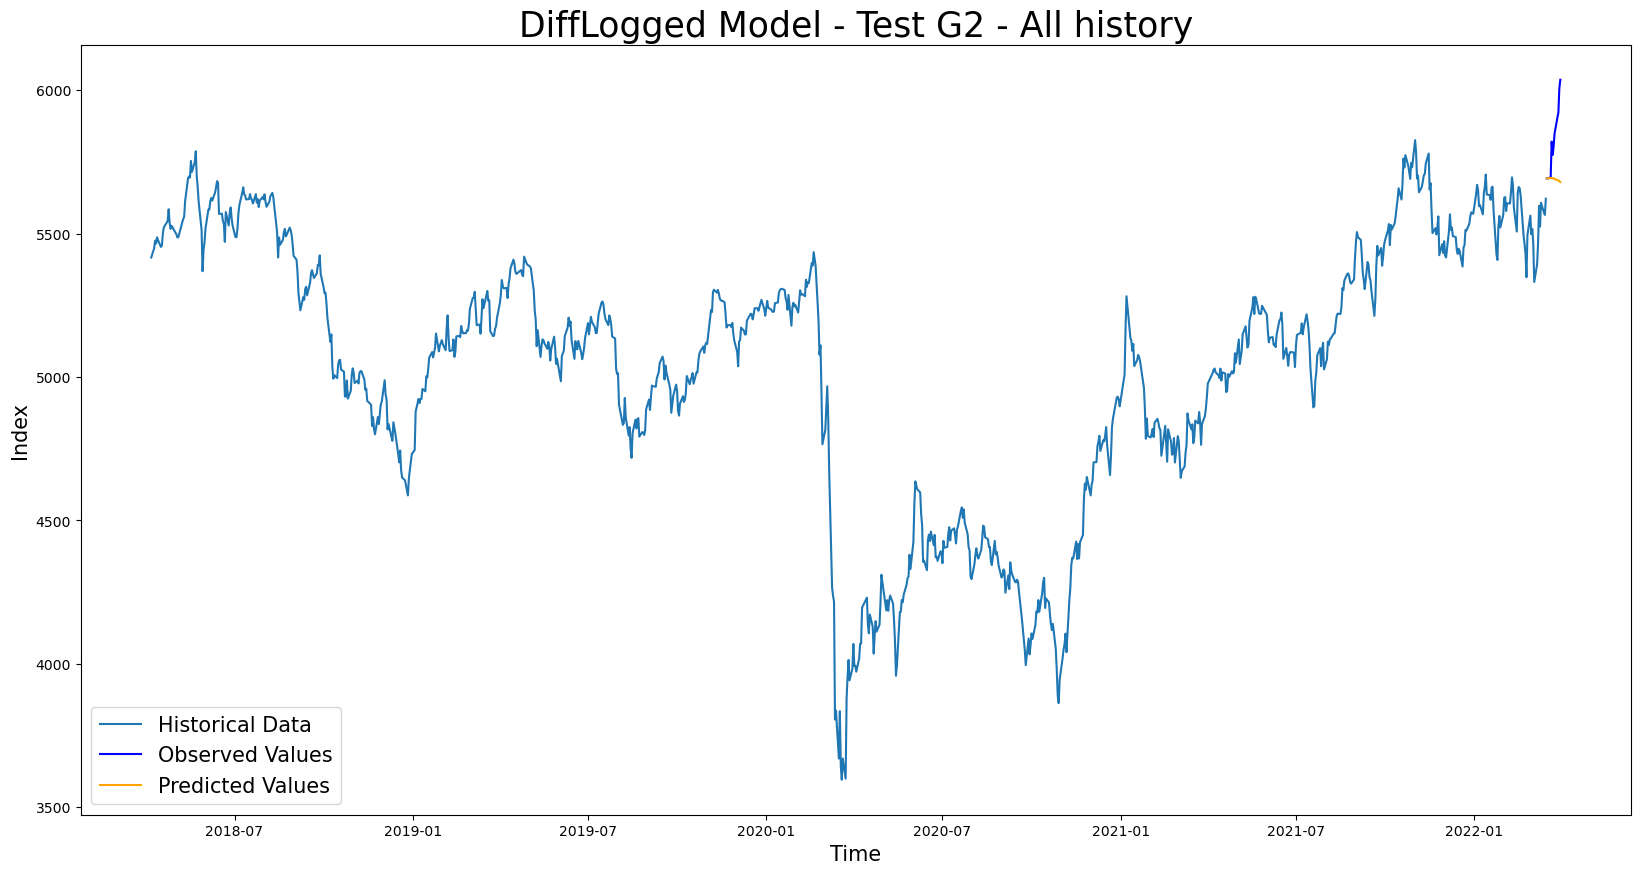

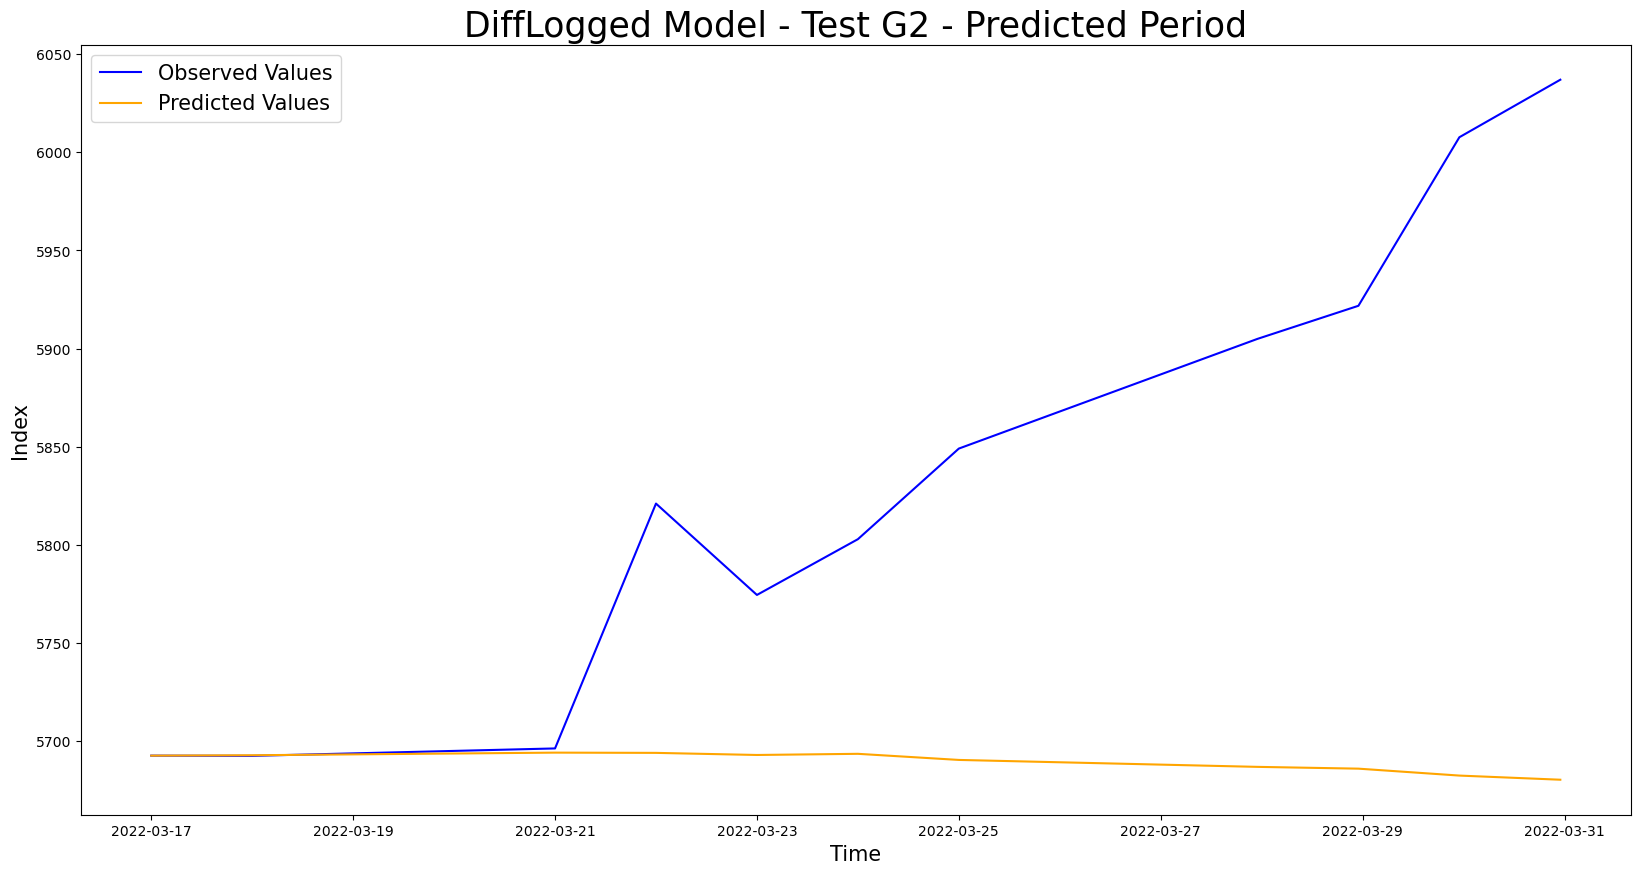

In [110]:
plotResults(history=global_data[:-1], predicted=predicted_stock_price, title="DiffLogged Model - Test G2")

#### Multi-index Variation

In [72]:
#Bivariate model
predicted_stock_var=lstm_biv_model.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [74]:
predicted_stock_var*100

array([[-0.35364866],
       [-0.5132227 ],
       [-0.35104948],
       [-0.14001405],
       [ 0.06421998],
       [ 0.20948145],
       [ 0.4184387 ],
       [ 0.46067443],
       [ 0.05675473],
       [-0.0847625 ],
       [ 0.13007806],
       [-0.13448744],
       [-0.36294818],
       [-0.4683263 ],
       [-0.33579624],
       [-0.28827628],
       [-0.24963564],
       [-0.0302012 ],
       [ 0.17785816],
       [ 0.2644057 ],
       [ 0.25913617],
       [ 0.20703293],
       [-0.03794447],
       [-0.27576593],
       [-0.25611687],
       [-0.19639263],
       [-0.05465432],
       [-0.07199592],
       [-0.2001147 ],
       [-0.41006514],
       [-0.03823212],
       [ 0.24237339],
       [ 0.10836469],
       [-0.35952166],
       [-0.5733569 ],
       [-0.4676688 ],
       [-0.14999665],
       [-0.10111054],
       [ 0.06424516],
       [ 0.01634718],
       [ 0.359231  ],
       [ 0.52817774],
       [ 0.15530366],
       [-0.00916665],
       [-0.24047154],
       [-0

In [75]:
#This is the correct one
predicted_stock_price = undiffLogData2(np.expand_dims(test_data[LOOK_BACK:,0], axis=1), predicted_stock_var);


In [76]:
predicted_stock_price

array([[5468.22021484],
       [5487.59273841],
       [5359.28470138],
       [5487.87150508],
       [5604.97213969],
       [5521.20314553],
       [5596.27432123],
       [5542.20064101],
       [5596.45887423],
       [5689.51025149],
       [5697.45714391],
       [5813.5427993 ],
       [5782.3513875 ],
       [5824.07025807],
       [5876.57733029],
       [5941.7585828 ],
       [6025.02387966],
       [6052.05947018],
       [5989.92887421],
       [6089.89921345],
       [6050.79999528],
       [6047.48862257],
       [6093.48128178],
       [6099.8942113 ],
       [6098.5347473 ],
       [6149.24913316],
       [6118.57446122],
       [6126.85744275],
       [6060.19159862],
       [6014.93488963],
       [5885.80643737],
       [5888.59074645],
       [5917.93889886],
       [5923.58720944],
       [5904.61015878],
       [5865.21255559],
       [5816.64890764],
       [5825.0208255 ],
       [5726.80749898],
       [5786.24138634],
       [5654.36563423],
       [5684.662

In [77]:
testPredictionsScore(test_data, predicted_stock_price)

Test Score: 77.35 RMSE


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_8456\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


In [78]:
# For bivariate use data=global_data.drop(['Volume']
day_before_price = generateBenchmark(data=global_data[['Close']])

In [79]:

testDayBeforeScore(predicted=day_before_price, actual=test_data[-PERIODS_TO_PREDICT:,0])

Test Score Day before: 76.91 RMSE


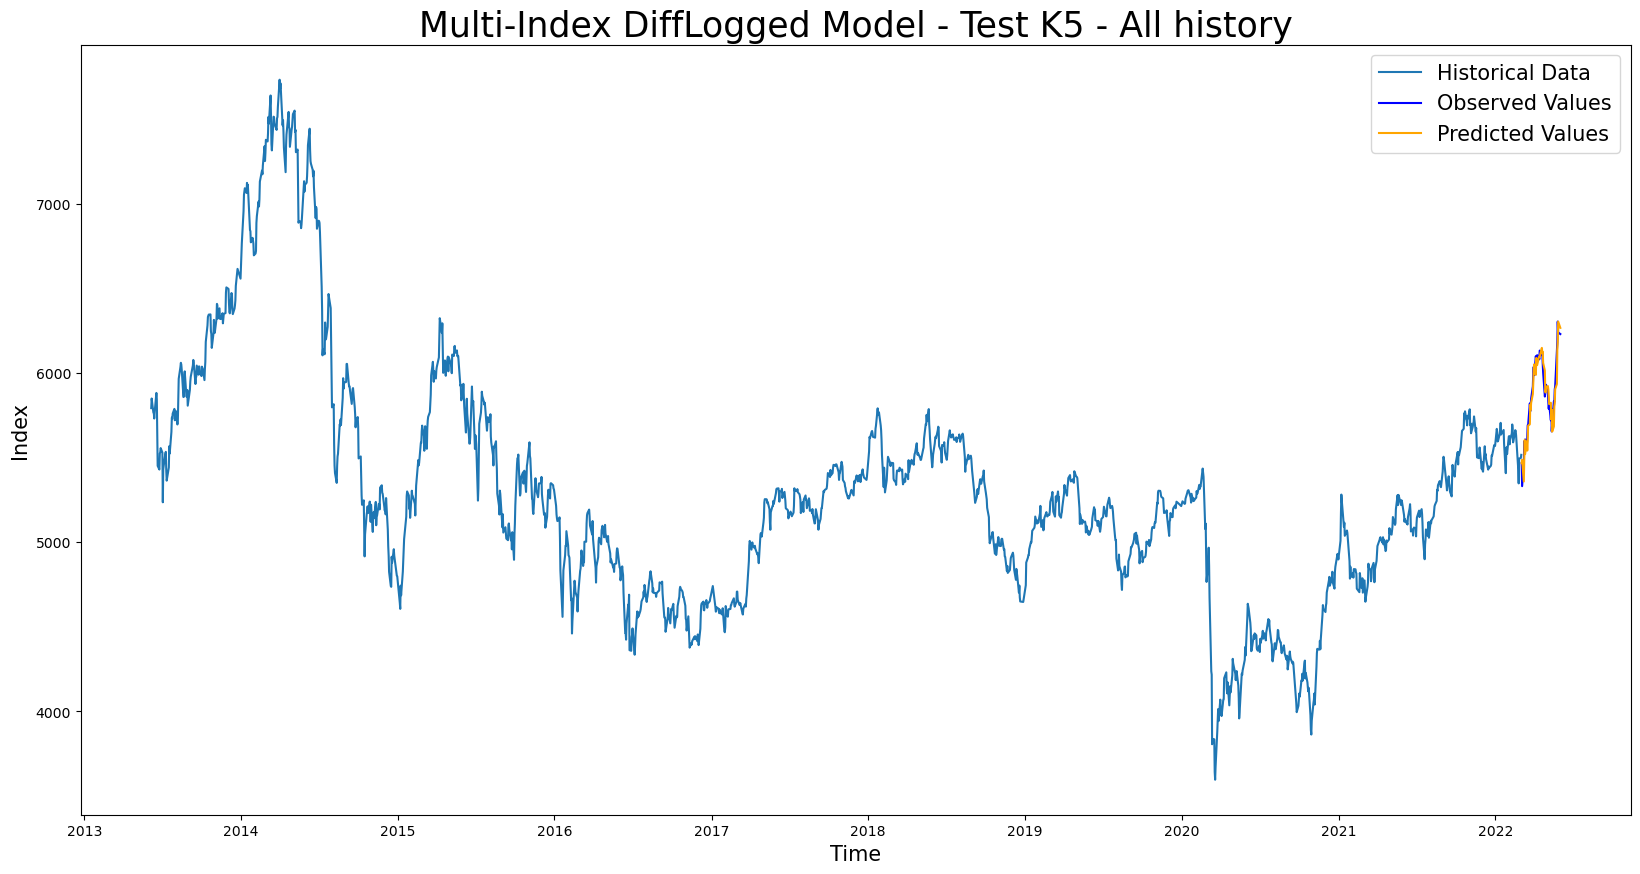

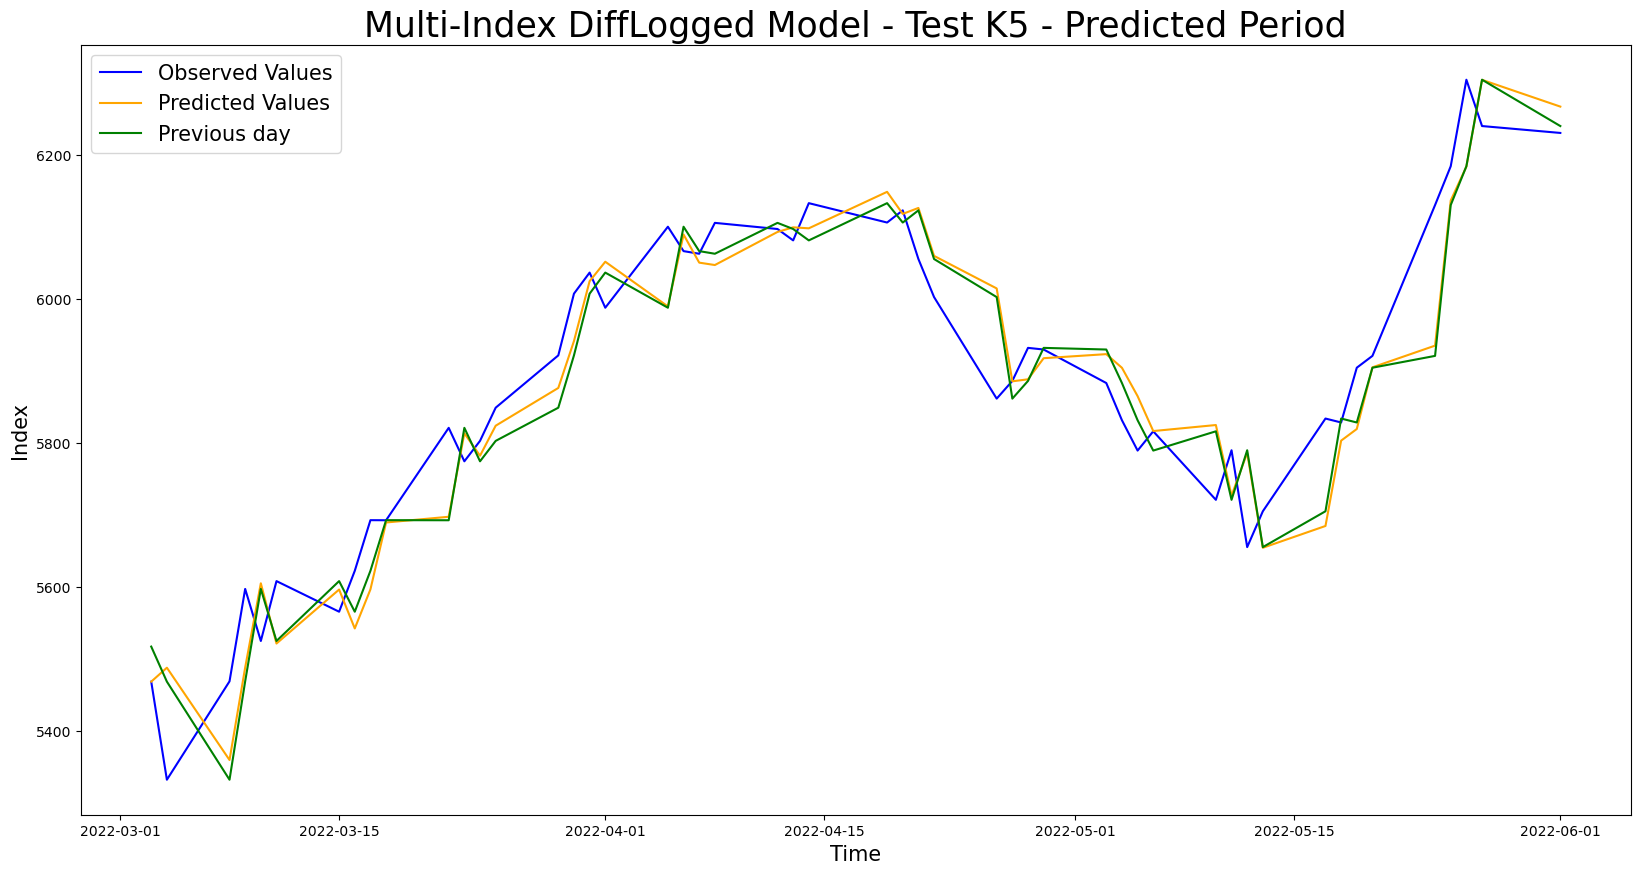

In [80]:
plotResults(history=global_data, benchmark=day_before_price, predicted=predicted_stock_price, title="Multi-Index DiffLogged Model - Test K5" )


In [82]:
predicted_stock_evo, actual_stock_evo = generateEvolutionArray(predicted_stock_var, scaled_test_data[-(PERIODS_TO_PREDICT-1):,0])


In [84]:
from sklearn.metrics import accuracy_score
print("Accuracy:" + str(accuracy_score(predicted_stock_evo, actual_stock_evo)*100) +"%.")

Accuracy:40.816326530612244%.


In [85]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, predicted_stock_evo)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix


array([[12, 11],
       [18,  8]], dtype=int64)

<AxesSubplot:title={'center':'"K5" Heatmap'}>

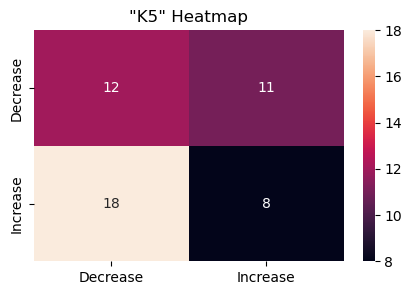

In [87]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Increase"],
                  columns = ["Decrease", "Increase"])
plt.figure(figsize = (5,3))
plt.title('"K5" Heatmap')
sn.heatmap(df_cm,annot=True)

#### Foreign VAR

In [50]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_var=lstm_model.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [ ]:
#This is the correct one
predicted_stock_price = undiffLogData2(test_data[LOOK_BACK:], predicted_stock_var);

# INTRA DAY

In [ ]:
#For model based in difflog use this:
#predicted_stock_var=lstm_biv_model.predict(X_test)
#predicted_stock_price = undiffLogData2(np.expand_dims(test_data[LOOK_BACK:,0], axis=1), predicted_stock_var);
#actual_stock_var=scaled_test_data[-(PERIODS_TO_PREDICT-1):,0]
#For model based in ABS values use this:
predicted_stock_price=lstm_biv_model.predict(X_test)


In [76]:
predicted_stock_price = testscaler[0].inverse_transform(predicted_stock_price)

In [77]:
#predicted_stock_price=testscaler[0].inverse_transform(predicted_stock_price)
predicted_stock_var = diffLogData_new(predicted_stock_price)
actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))


In [78]:
predicted_stock_price

array([[6099.4263],
       [6098.74  ],
       [6098.154 ],
       [6097.7056],
       [6097.307 ],
       [6097.091 ],
       [6096.8306],
       [6096.5186],
       [6096.067 ],
       [6095.5244],
       [6095.05  ],
       [6094.5293],
       [6093.8843],
       [6093.2603],
       [6092.566 ],
       [6091.906 ],
       [6091.227 ],
       [6090.542 ],
       [6089.7827],
       [6089.086 ],
       [6088.69  ],
       [6088.59  ],
       [6088.7847],
       [6089.1807],
       [6089.598 ],
       [6090.015 ],
       [6090.417 ],
       [6090.8022],
       [6091.1167],
       [6091.4443],
       [6091.7744],
       [6092.133 ],
       [6092.603 ],
       [6093.    ],
       [6093.225 ],
       [6093.364 ],
       [6093.5215],
       [6093.8623],
       [6094.484 ],
       [6095.1904],
       [6095.6797],
       [6095.9487],
       [6095.7964],
       [6095.3765],
       [6094.6855],
       [6094.0083],
       [6093.3   ],
       [6092.6533],
       [6092.0225],
       [6091.563 ]],

In [79]:
np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_price))

2.3315550842289934

In [80]:
testPredictionsScore()

Test Score: 2.33 RMSE


In [82]:

day_before_price = generateBenchmark(data=global_data[['Close']], size=size_train_data)


In [83]:
np.sqrt(mean_squared_error(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0]))

1.2067191165428095

In [84]:
testDayBeforeScore(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0])

Test Score Day before: 1.21 RMSE


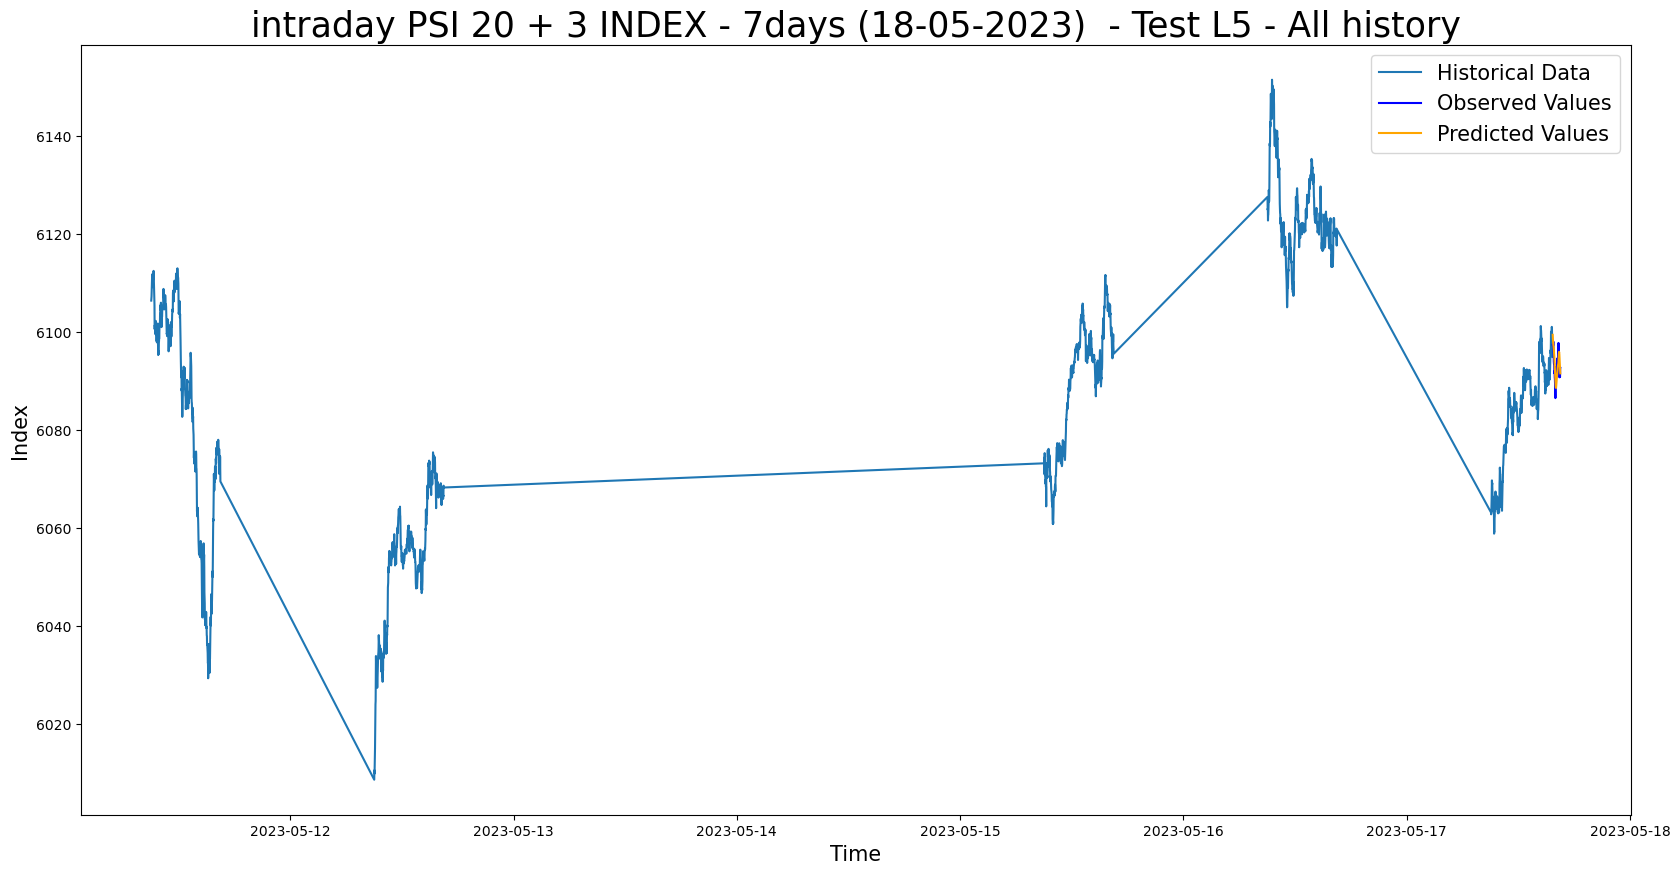

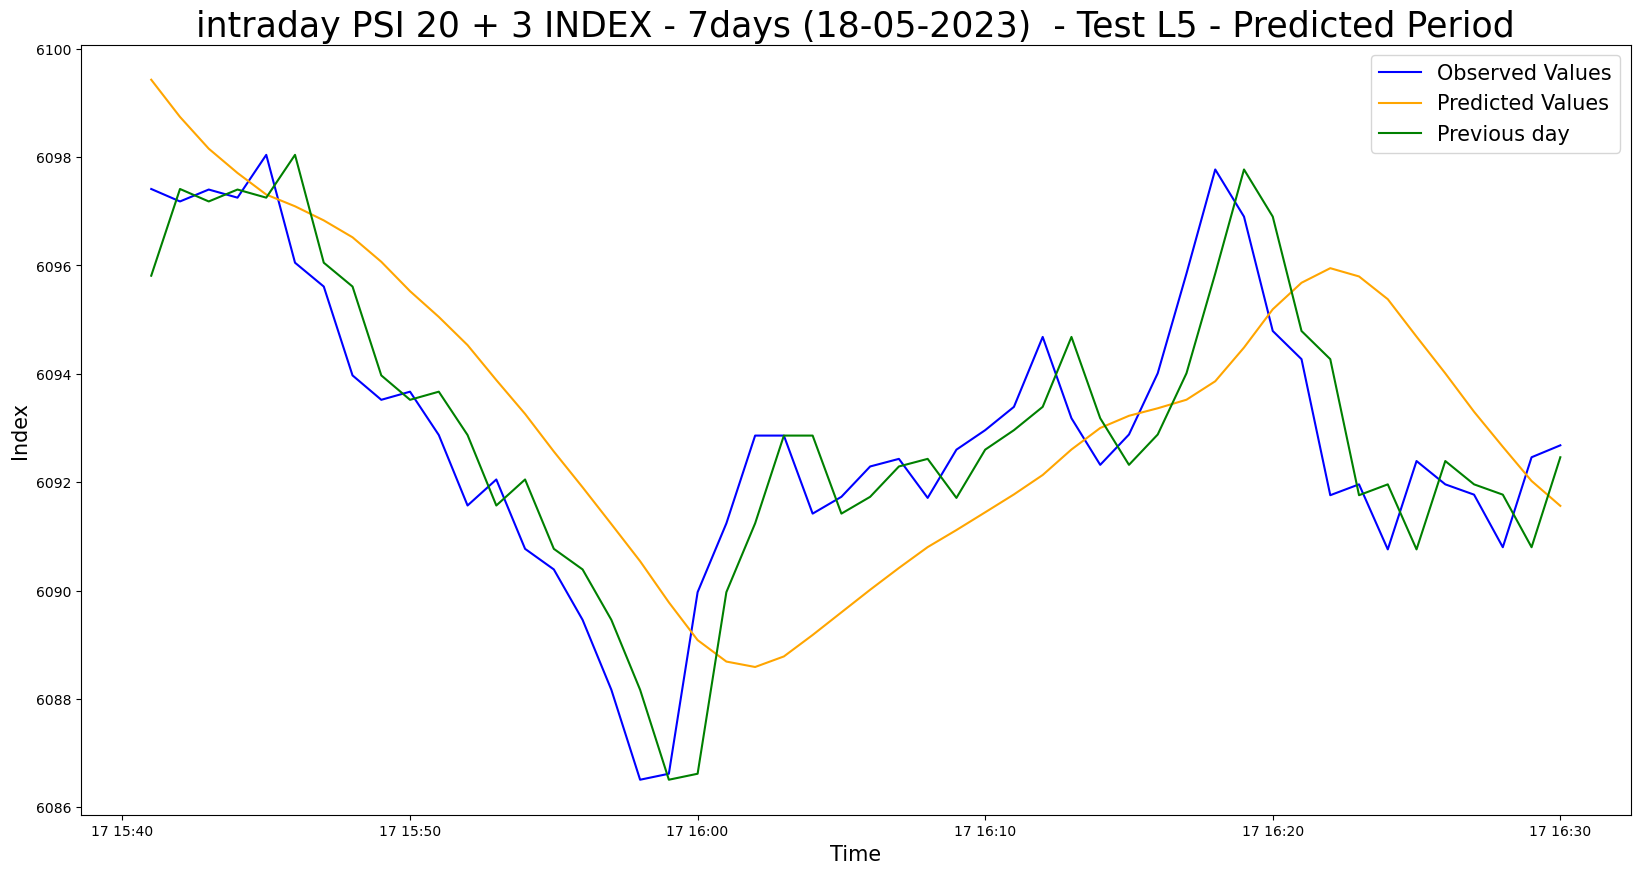

In [85]:
plotResults(history=global_data[['Close']],predicted=predicted_stock_price,benchmark=day_before_price, 
            title="intraday PSI 20 + 3 INDEX - 7days ("+dates[0] +")  - Test L5")

In [86]:
predicted_stock_evo, actual_stock_evo = generateEvolutionArray(predicted=predicted_stock_var, actual=actual_stock_var)

In [87]:
from sklearn.metrics import accuracy_score
print("Accuracy:" + str(accuracy_score(predicted_stock_evo, actual_stock_evo)*100) +"%.")

Accuracy:59.183673469387756%.


In [88]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, predicted_stock_evo)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix


array([[17,  8],
       [12, 12]], dtype=int64)

<AxesSubplot:title={'center':'"L5" Heatmap'}>

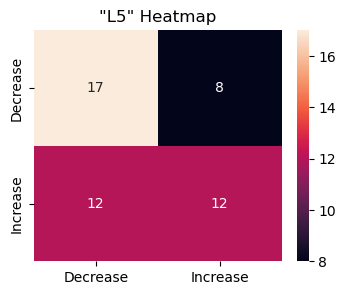

In [89]:

import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Increase"],
                  columns = ["Decrease", "Increase"])
plt.figure(figsize = (4,3))
plt.title('"L5" Heatmap')
sn.heatmap(df_cm,annot=True)


In [90]:
predicted_stock_evo, actual_stock_evo = generateEvolutionArray(predicted=predicted_stock_var, actual=actual_stock_var,numCat=3)

In [91]:
print("Accuracy:" + str(accuracy_score(predicted_stock_evo, actual_stock_evo)*100) +"%.")

Accuracy:38.775510204081634%.


In [92]:

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, predicted_stock_evo)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix

array([[ 5,  9,  2],
       [ 8, 14,  0],
       [ 3,  8,  0]], dtype=int64)

<AxesSubplot:title={'center':'"L5b" Heatmap'}>

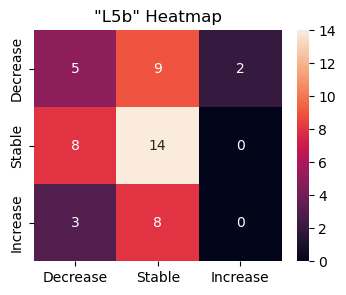

In [93]:
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable", "Increase"],
                  columns = ["Decrease", "Stable", "Increase"])
plt.figure(figsize = (4,3))
plt.title('"L5b" Heatmap')
sn.heatmap(df_cm,annot=True)

In [94]:
actual_stock_price=np.expand_dims(test_data[-PERIODS_TO_PREDICT:,0], axis=1)

In [95]:
#actual_stock_price=test_data[-PERIODS_TO_PREDICT:,0]
np.log(predicted_stock_price[1:].squeeze())-np.log(actual_stock_price[-1:].squeeze())


array([ 9.93728638e-04,  8.97407532e-04,  8.23974609e-04,  7.59124756e-04,
        7.22885132e-04,  6.80923462e-04,  6.29425049e-04,  5.55038452e-04,
        4.66346741e-04,  3.88145447e-04,  3.03268433e-04,  1.97410583e-04,
        9.44137573e-05, -1.90734863e-05, -1.27792358e-04, -2.39372253e-04,
       -3.50952148e-04, -4.75883484e-04, -5.90324402e-04, -6.55174255e-04,
       -6.72340393e-04, -6.39915466e-04, -5.75065613e-04, -5.06401062e-04,
       -4.37736511e-04, -3.71932983e-04, -3.08990479e-04, -2.57492065e-04,
       -2.03132629e-04, -1.48773193e-04, -9.05990601e-05, -1.33514404e-05,
        5.24520874e-05,  8.86917114e-05,  1.11579895e-04,  1.37329102e-04,
        1.93595886e-04,  2.95639038e-04,  4.11987305e-04,  4.92095947e-04,
        5.35964966e-04,  5.11169434e-04,  4.42504883e-04,  3.29017639e-04,
        2.17437744e-04,  1.01089478e-04, -4.76837158e-06, -1.08718872e-04,
       -1.84059143e-04], dtype=float32)

In [96]:
np.log(predicted_stock_price[1:].squeeze())-np.log(global_data.iloc[-PERIODS_TO_PREDICT+1:,0])



Datetime
2023-05-17 15:42:00    0.000256
2023-05-17 15:43:00    0.000123
2023-05-17 15:44:00    0.000075
2023-05-17 15:45:00   -0.000120
2023-05-17 15:46:00    0.000170
2023-05-17 15:47:00    0.000201
2023-05-17 15:48:00    0.000418
2023-05-17 15:49:00    0.000418
2023-05-17 15:50:00    0.000304
2023-05-17 15:51:00    0.000357
2023-05-17 15:52:00    0.000486
2023-05-17 15:53:00    0.000301
2023-05-17 15:54:00    0.000408
2023-05-17 15:55:00    0.000357
2023-05-17 15:56:00    0.000401
2023-05-17 15:57:00    0.000502
2023-05-17 15:58:00    0.000663
2023-05-17 15:59:00    0.000520
2023-05-17 16:00:00   -0.000145
2023-05-17 16:01:00   -0.000418
2023-05-17 16:02:00   -0.000701
2023-05-17 16:03:00   -0.000669
2023-05-17 16:04:00   -0.000368
2023-05-17 16:05:00   -0.000350
2023-05-17 16:06:00   -0.000373
2023-05-17 16:07:00   -0.000331
2023-05-17 16:08:00   -0.000149
2023-05-17 16:09:00   -0.000244
2023-05-17 16:10:00   -0.000249
2023-05-17 16:11:00   -0.000265
2023-05-17 16:12:00   -0.000418

# Clear All

# INTRA DAY - Models go

In [69]:
def execeutePredictions(date, X_test, numberOfGoes=30) :
    from keras.models import load_model
    predicted_stock_prices_scaled = []
    for testNumber in range(1, numberOfGoes+1) :
        filename = '.\models_go\model' + date +'_'+str(testNumber)+'.h5'
        #For single_stock
        #filename = '.\models_go\ss\model_ss_' + date +'_'+str(testNumber)+'.h5'
        model = load_model(filename)
        predicted_stock_prices_scaled.append(model.predict(X_test))
    return predicted_stock_prices_scaled         


In [76]:
def execeutePredictionsSS(date, X_test, startGo=1, numberOfGoes=30) :
    from keras.models import load_model
    predicted_stock_prices_scaled = []
    for testNumber in range(startGo, numberOfGoes+1) :
        filename = '.\models_go\ss\model_ss_' + date +'_'+str(testNumber)+'.h5'
        #For single_stock
        #filename = '.\models_go\ss\model_ss_' + date +'_'+str(testNumber)+'.h5'
        model = load_model(filename)
        predicted_stock_prices_scaled.append(model.predict(X_test))
    return predicted_stock_prices_scaled      

In [146]:
dateModel = dates[0]
testCode ='N3'

In [154]:
#predictions_scaled = execeutePredictions(dateModel,X_test,numberOfGoes=30)

#predictions_scaled = execeutePredictionsSS(dateModel,X_test,numberOfGoes=17)
#predictions_scaled2 = execeutePredictionsSS(dateModel,X_test,startGo=18,numberOfGoes=30)
predictions_scaled = predictions_scaled + predictions_scaled2

In [155]:
def unscaleResults(predicted_stock_prices_scaled, scaler) :
    predicted_stock_prices, predicted_stock_vars = [],[]
    
    for predicted_stock_price in predicted_stock_prices_scaled :
        
        p = scaler.inverse_transform(predicted_stock_price)

        predicted_stock_prices.append(p)
        predicted_stock_vars.append(diffLogData_new(p))
    
    
    return predicted_stock_prices,predicted_stock_vars
    
    

In [156]:
predicted_stock_prices,predicted_stock_vars = unscaleResults(predictions_scaled, testScaler[0])
actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))

In [157]:
predicted_stock_prices[1].squeeze()

array([5963.5728, 5964.9136, 5961.727 , 5961.533 , 5964.1777, 5964.19  ,
       5964.9526, 5965.927 , 5967.3403, 5968.6367, 5968.052 , 5967.3027,
       5967.174 , 5967.6074, 5967.9087, 5970.3   , 5969.8394, 5968.756 ,
       5967.0913, 5968.254 , 5968.651 , 5964.666 , 5965.6265, 5965.041 ,
       5964.3164, 5963.4214, 5962.8823, 5962.759 , 5961.358 , 5960.661 ,
       5960.909 , 5961.0645, 5961.403 , 5958.6743, 5959.4414, 5959.63  ,
       5957.879 , 5957.2676, 5955.8735, 5955.692 , 5958.232 , 5958.7944,
       5957.6694, 5960.2847, 5959.0674, 5960.2246, 5962.24  , 5962.114 ,
       5960.8833, 5957.55  ], dtype=float32)

In [158]:
def analysePredictions(predicted_stock_prices,predicted_stock_vars,actual_stock_var) : 
    from sklearn.metrics import accuracy_score
    import itertools
    rmses = []
    accuracies = []
    pred_evo = []

    actual_evo = generateEvolutionArray(predicted_stock_vars[0].squeeze(),actual_stock_var)[1]
    for (pred_price, pred_var) in itertools.zip_longest(predicted_stock_prices, predicted_stock_vars):
    
        rmses.append(np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], pred_price.squeeze())))
        p = generateEvolutionArray(pred_var.squeeze(),actual_stock_var)[0]
        accuracies.append(accuracy_score(p, actual_evo)*100)
        pred_evo.append(p)
    return rmses,accuracies, pred_evo, actual_evo

In [159]:
rmses, accuracies, pred_evo, actual_evo = analysePredictions(predicted_stock_prices,predicted_stock_vars, actual_stock_var )

In [160]:
indexBestAcc = accuracies.index(max(accuracies))
print ("Max Accuracy " + str(round(max(accuracies),2)) + "% on index " + str(indexBestAcc))

Max Accuracy 65.31% on index 17


In [161]:
indexBestRmse = rmses.index(min(rmses))
print ("Min RMSE " + str(round(min(rmses),2)) + " on index " + str(indexBestRmse))

Min RMSE 1.33 on index 15


In [162]:
predicted_stock_prices[indexBestRmse]

array([[5963.2393],
       [5964.5693],
       [5961.493 ],
       [5961.28  ],
       [5963.7183],
       [5964.017 ],
       [5964.452 ],
       [5965.613 ],
       [5967.013 ],
       [5968.286 ],
       [5967.76  ],
       [5966.933 ],
       [5966.895 ],
       [5967.334 ],
       [5967.5947],
       [5969.9805],
       [5969.598 ],
       [5968.368 ],
       [5966.8433],
       [5968.025 ],
       [5968.3613],
       [5964.589 ],
       [5965.214 ],
       [5964.969 ],
       [5964.0493],
       [5963.085 ],
       [5962.731 ],
       [5962.4204],
       [5961.159 ],
       [5960.3936],
       [5960.646 ],
       [5960.7856],
       [5961.0796],
       [5958.476 ],
       [5959.1997],
       [5959.3687],
       [5957.727 ],
       [5957.0166],
       [5955.7646],
       [5955.529 ],
       [5957.9805],
       [5958.54  ],
       [5957.4395],
       [5960.0195],
       [5958.8677],
       [5959.994 ],
       [5961.9214],
       [5961.9546],
       [5960.5527],
       [5957.526 ]],

In [163]:
#predicted_stock_price=testscaler[0].inverse_transform(predicted_stock_price)
#predicted_stock_var = diffLogData_new(predicted_stock_prices[16])
#actual_stock_var = diffLogData_new(np.expand_dims(test_data[-(PERIODS_TO_PREDICT):,0], axis=1))


In [164]:
np.sqrt(mean_squared_error(global_data.iloc[-PERIODS_TO_PREDICT:,0], predicted_stock_prices[indexBestRmse]))

1.325524620345526

In [165]:

day_before_price = generateBenchmark(data=global_data[['Close']], size=size_train_data)


In [166]:
np.sqrt(mean_squared_error(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0]))

1.3487550310778185

In [167]:
testDayBeforeScore(day_before_price, global_data.iloc[-PERIODS_TO_PREDICT:,0])

Test Score Day before: 1.35 RMSE


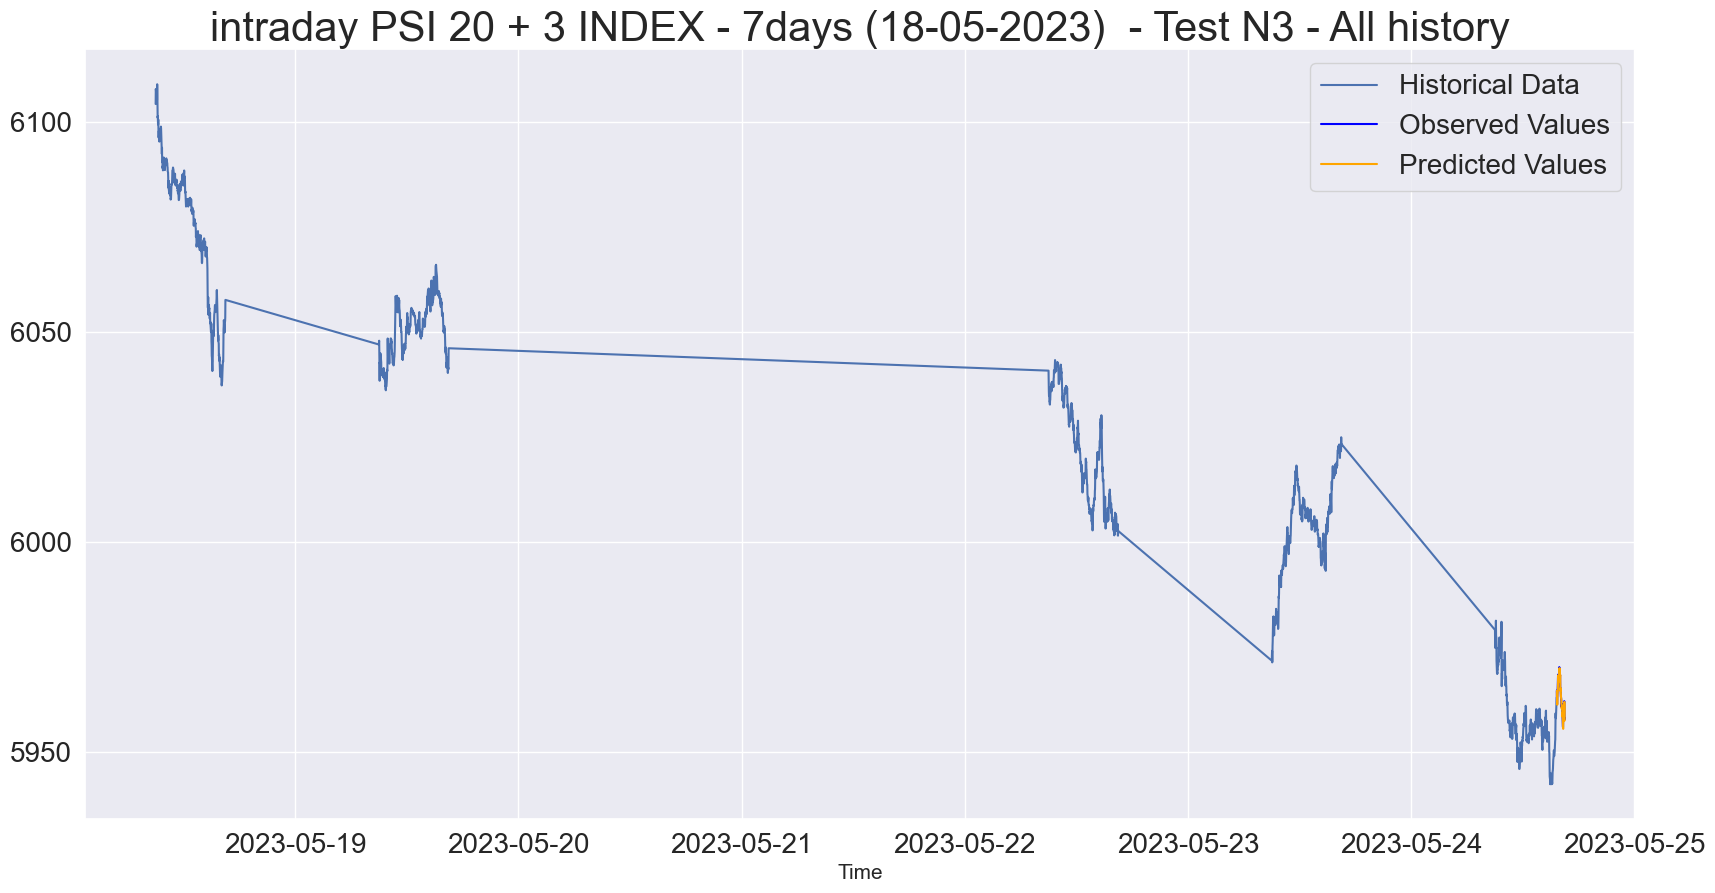

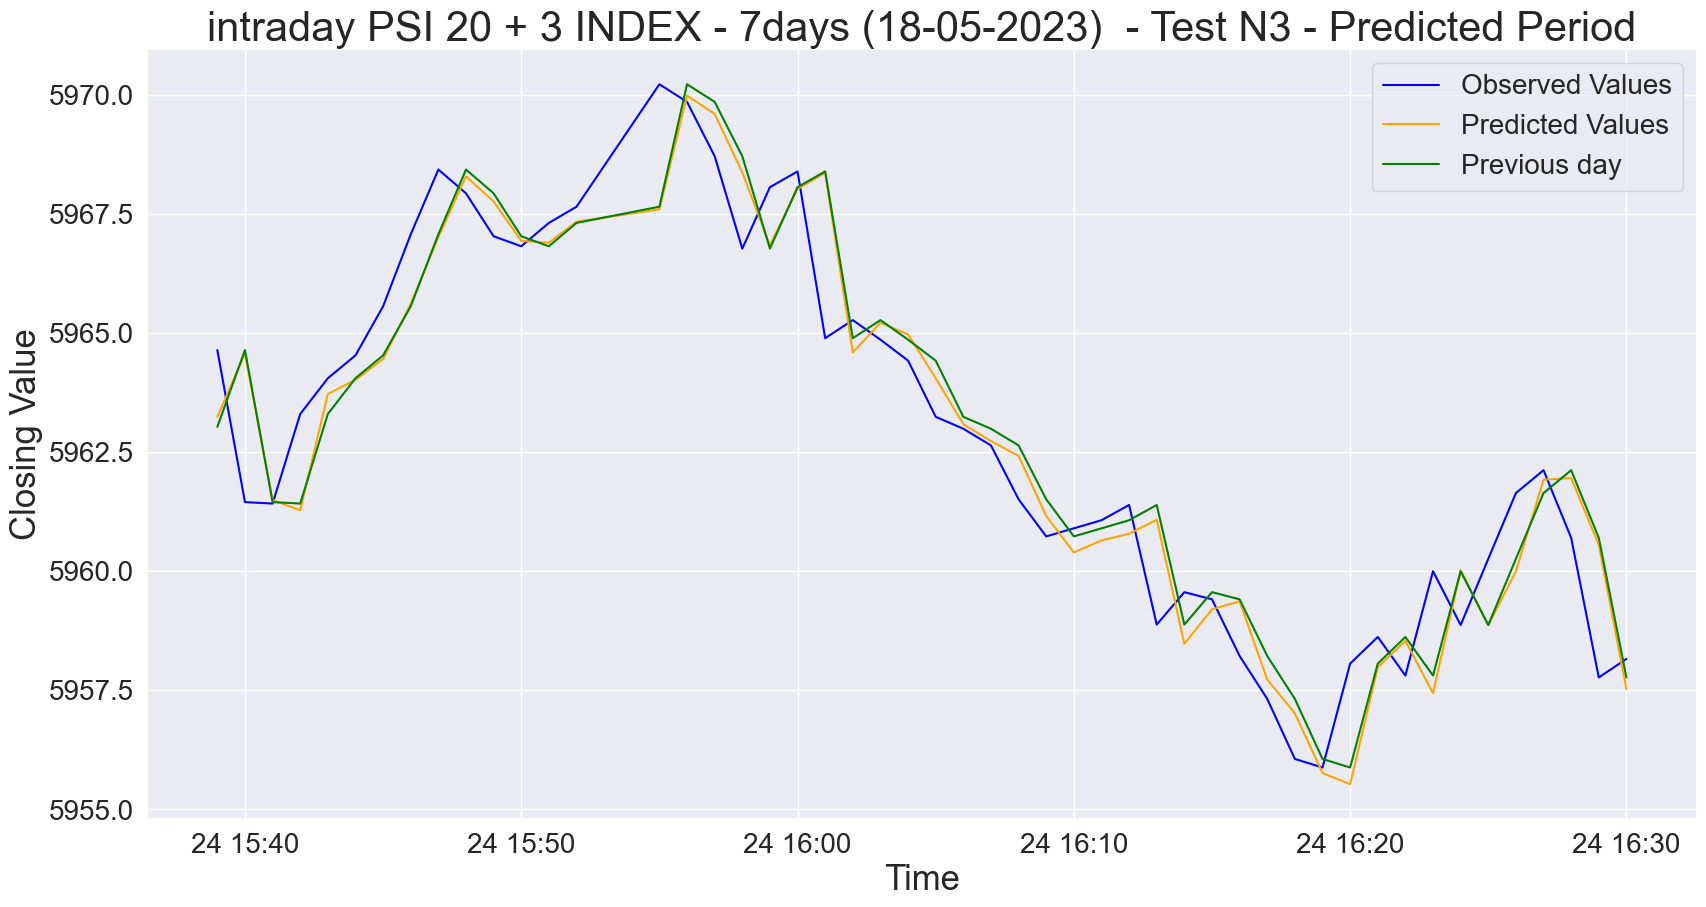

In [168]:
plotResults(history=global_data[['Close']],predicted=predicted_stock_prices[indexBestRmse],benchmark=day_before_price, 
            title="intraday PSI 20 + 3 INDEX - 7days ("+dateModel +")  - Test " + testCode)

In [169]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual_evo, pred_evo[indexBestAcc])
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix


array([[17,  9],
       [ 8, 15]], dtype=int64)

<AxesSubplot: title={'center': 'N3 - Heatmap'}>

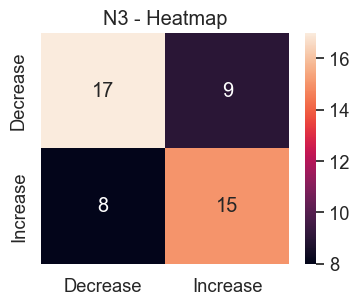

In [170]:

import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Increase"],
                  columns = ["Decrease", "Increase"])
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)
plt.title(testCode + ' - Heatmap')
sn.heatmap(df_cm,annot=True)


In [171]:
actual_stock_evo = generateEvolutionArray(predicted=predicted_stock_vars[indexBestAcc], actual=actual_stock_var,numCat=3)[1]

In [172]:
from sklearn.metrics import accuracy_score
accuracies3 =[]
pred_evo3 =[]
for pred_var in predicted_stock_vars :
    p = generateEvolutionArray(predicted=pred_var, actual=actual_stock_var,numCat=3)[0]
    pred_evo3.append(p)
    accuracies3.append(accuracy_score(p, actual_stock_evo)*100)



In [173]:
max(accuracies3)
indexBestAcc3 = accuracies3.index(max(accuracies3))

In [174]:
print ("Best Accuracy 3  " + str(round(max(accuracies3),2)) + "% on index " + str(indexBestAcc3))

Best Accuracy 3  36.73% on index 26


In [175]:

confusion_matrix = metrics.confusion_matrix(actual_stock_evo, pred_evo3[indexBestAcc3])
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix

array([[6, 7, 2],
       [7, 9, 8],
       [3, 4, 3]], dtype=int64)

<AxesSubplot: title={'center': 'N3b Heatmap'}>

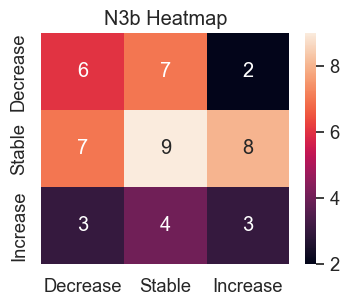

In [176]:
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "Stable", "Increase"],
                  columns = ["Decrease", "Stable", "Increase"])
plt.figure(figsize = (4,3))
sns.set(font_scale=1.2)
plt.title(testCode + 'b Heatmap')
sn.heatmap(df_cm,annot=True)

In [177]:
actual_stock_price=np.expand_dims(test_data[-PERIODS_TO_PREDICT:,0], axis=1)

<AxesSubplot: title={'center': 'Accuracy Histogram on test N3'}, ylabel='Count'>

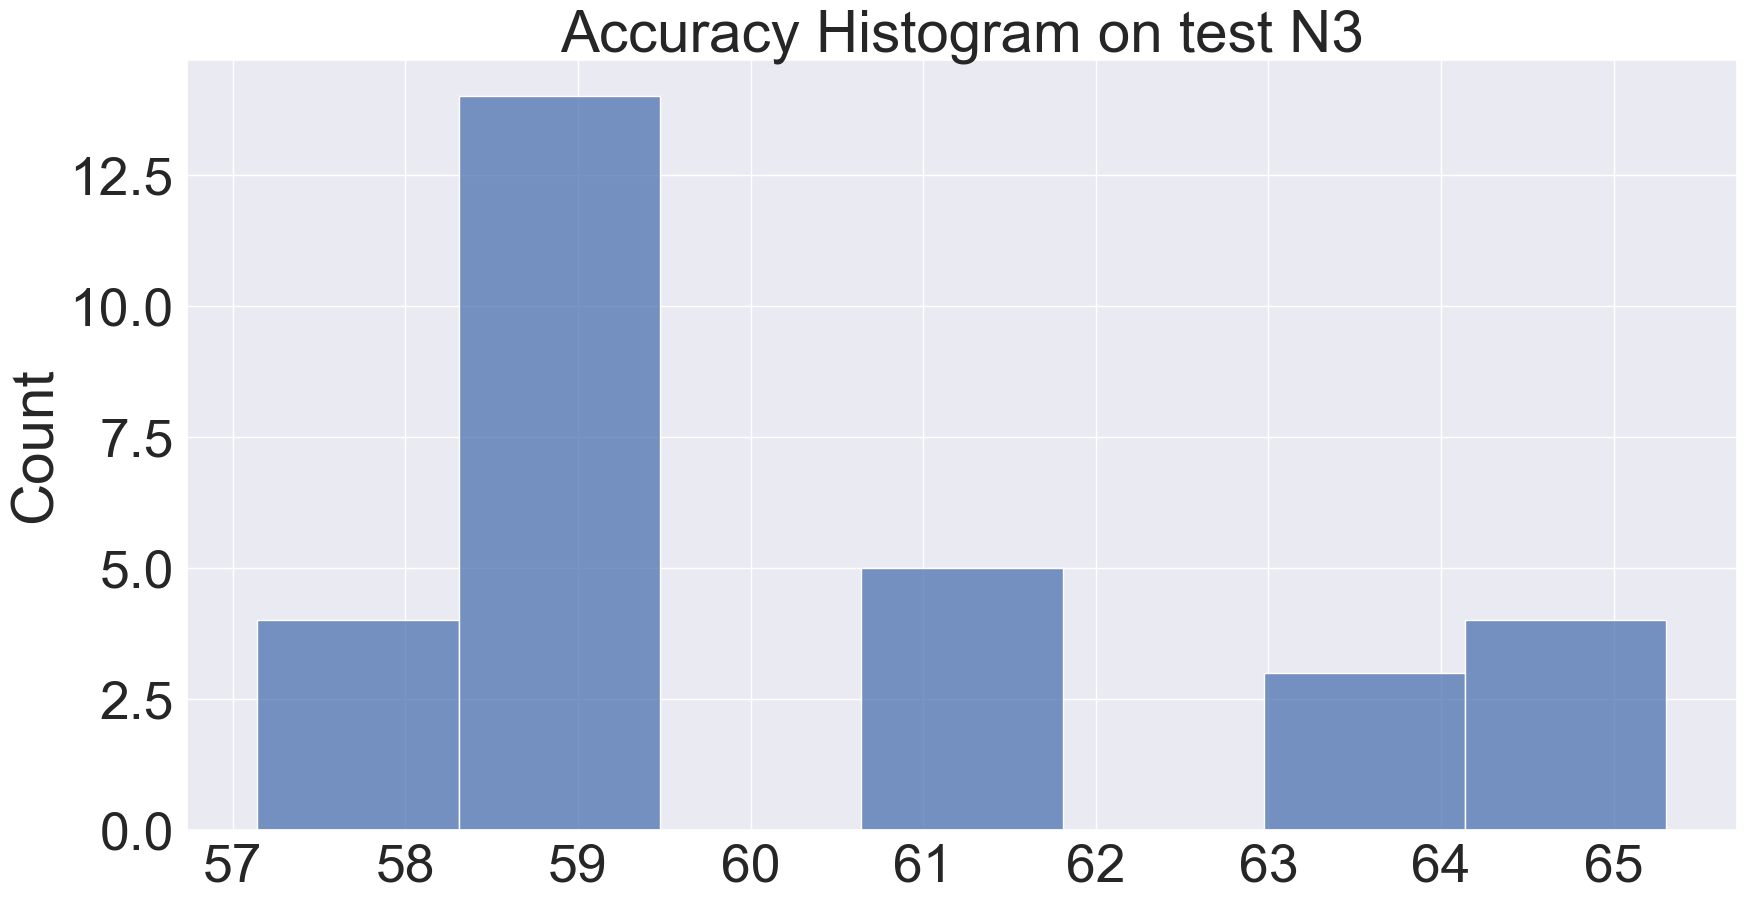

In [178]:
import seaborn as sns
#plt.hist(accuracies3)
#plt.show()
sns.set(font_scale=3.5)
plt.title("Accuracy Histogram on test " +testCode)
sns.histplot(data=accuracies)


<AxesSubplot: title={'center': 'Accuracy (3 possibilities) Histogram on test N3'}, ylabel='Count'>

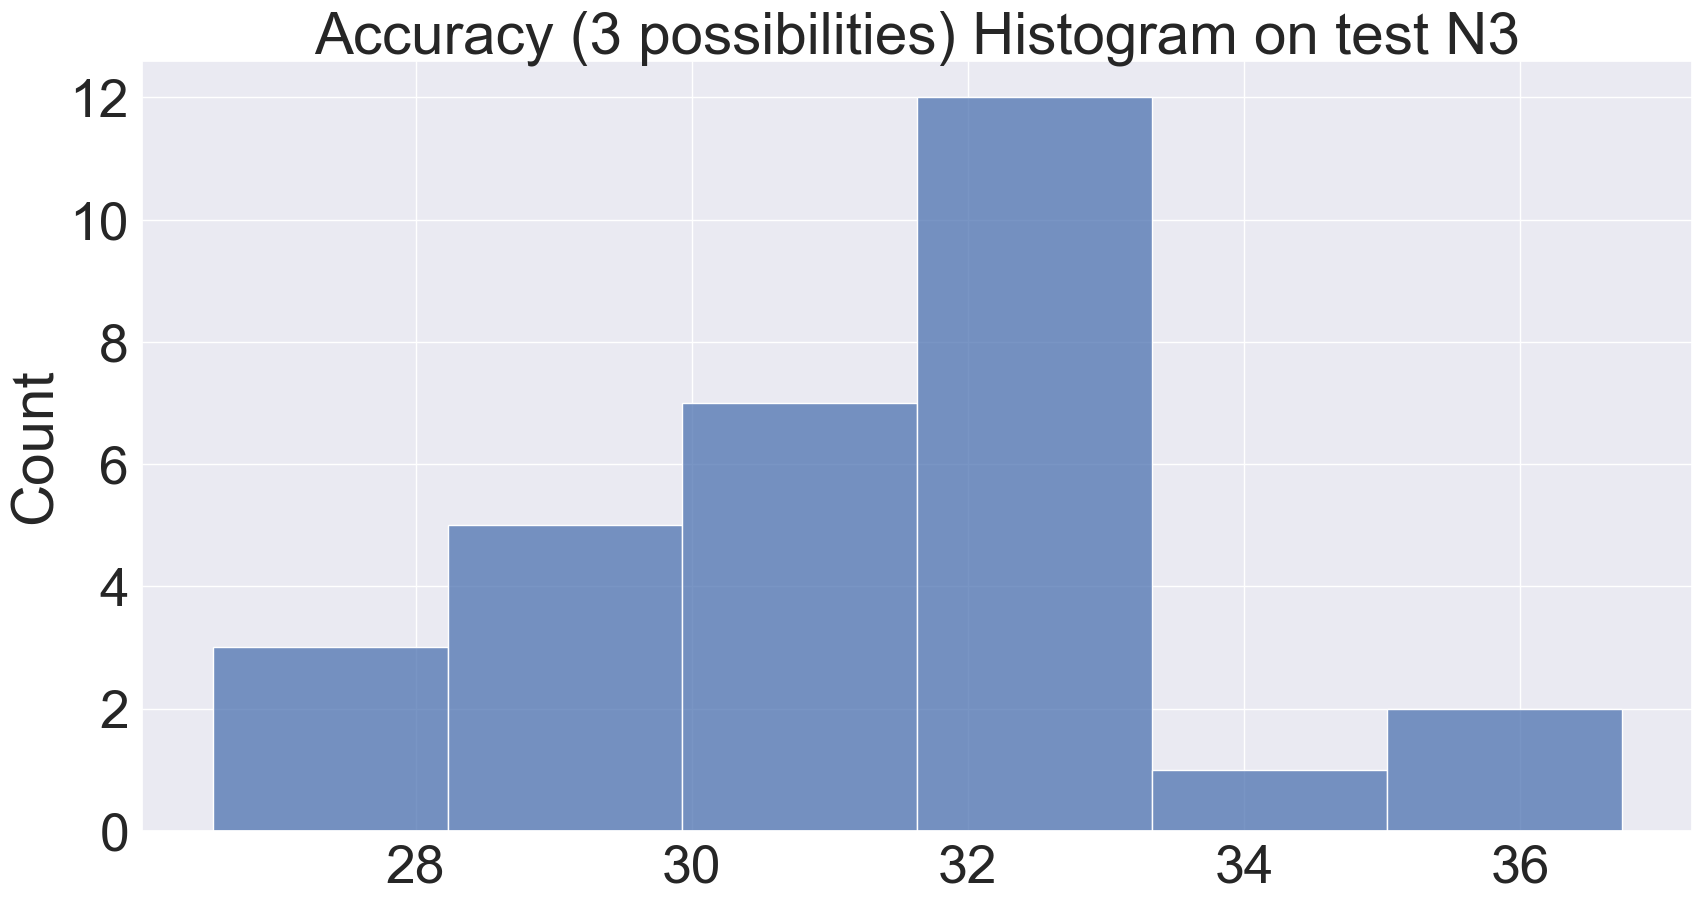

In [179]:
plt.title("Accuracy (3 possibilities) Histogram on test " +testCode)
sns.histplot(data=accuracies3)

In [180]:
print("******************")
print("The mean of the accuracies is " + str(round(sum(accuracies) / len(accuracies),2)) + "%.")
print("The mean of the accuracies with 3 outcomes is " + str(round(sum(accuracies3) / len(accuracies3),2)) + "%.")

print("******************")
import statistics
print("The median of the accuracies is " + str(round(statistics.median(accuracies),2)) + "%.")
print("The median of the accuracies with 3 outcomes is " + str(round(statistics.median(accuracies3),2)) + "%.")
print("******************")



******************
The mean of the accuracies is 60.48%.
The mean of the accuracies with 3 outcomes is 31.22%.
******************
The median of the accuracies is 59.18%.
The median of the accuracies with 3 outcomes is 31.63%.
******************


In [427]:
accuracies3

[28.57142857142857,
 32.6530612244898,
 30.612244897959183,
 32.6530612244898,
 30.612244897959183,
 28.57142857142857,
 34.69387755102041,
 30.612244897959183,
 34.69387755102041,
 32.6530612244898,
 32.6530612244898,
 28.57142857142857,
 32.6530612244898,
 28.57142857142857,
 34.69387755102041,
 32.6530612244898]

# Clear All

In [140]:
globals().clear()


<function dict.clear>

## Save / Load function

In [482]:

from keras.models import load_model

lstm_model.save('.\models\model_3B-E5_NYSE.h5')  # creates a HDF5 file 'my_model.h5'


In [109]:
#del model  # deletes the existing model

from keras.models import load_model
# returns a compiled model
# identical to the previous one
lstm_biv_model = load_model('.\models\model_B1.h5')


In [110]:
lstm_biv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
